In [ ]:
!pip uninstall torchaudio
!pip uninstall torchdata
!pip uninstall torchsummary
!pip uninstall torchtext
!pip uninstall torchvision

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):
  ! {sys.executable} -m pip install pytorch-lifestream
  !pip install "torch<2"
  !pip install torchvision==0.13.1

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import pytorch_lightning as pl

from sklearn.metrics import accuracy_score, classification_report


from sklearn.model_selection import KFold
import logging

from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
%matplotlib inline



from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F

In [7]:
import os
import pandas as pd

data_path = '/content/drive/MyDrive/data_age_pred/'

source_data = pd.read_csv(os.path.join(data_path, 'transactions_train.csv'))
source_data

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341
...,...,...,...,...
26450572,43300,727,25,7.602
26450573,43300,727,15,3.709
26450574,43300,727,1,6.448
26450575,43300,727,11,24.669


In [8]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='client_id',
    col_event_time='trans_date',
    event_time_transformation='none',
    cols_category=['small_group'],
    cols_numerical=['amount_rur'],
    return_records=True,
)

In [9]:
%%time

dataset = preprocessor.fit_transform(source_data)

CPU times: user 59.8 s, sys: 12.1 s, total: 1min 11s
Wall time: 1min 22s


In [10]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [11]:
dataset = sorted(dataset, key=lambda x: x['client_id'])

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(24000, 6000)

In [13]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [14]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=ColesDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[
                SeqLenFilter(min_seq_len=25),
            ],
        ),
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=200,
        ),
    ),
    train_num_workers=2,
    train_batch_size=256,
)

In [15]:
trainer = pl.Trainer(
    max_epochs=15,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


logger.version = 0


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 238 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
238 K     Trainable params
0         Non-trainable params
238 K     Total params
0.953     Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss': tensor(289.1466), 'seq_len': tensor(110.1844)}
CPU times: user 4min 57s, sys: 21.4 s, total: 5min 18s
Wall time: 6min 31s


In [17]:
torch.save(seq_encoder.state_dict(), "emb_part_age_pred.pt")

In [18]:
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)
seq_encoder.load_state_dict(torch.load("emb_part_age_pred.pt"))


<All keys matched successfully>

# Before down stream problem

In [19]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([24000, 256]), torch.Size([6000, 256]))

In [21]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

print(train_df.shape, test_df.shape)

(24000, 258) (6000, 258)


In [22]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

In [23]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.5805


# Downstream task

In [24]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

seq_encoder.load_state_dict(torch.load('emb_part_age_pred.pt'))

<All keys matched successfully>

In [25]:
from functools import partial
import torch
import torchmetrics
from ptls.frames.supervised import SequenceToTarget
from ptls.nn import Head

downstream_model = SequenceToTarget(
    seq_encoder=seq_encoder,
    head=Head(
        input_size=seq_encoder.embedding_size,
        use_batch_norm=True,
        objective='classification',
        num_classes=4,
    ),
    loss=torch.nn.NLLLoss(),
    metric_list=torchmetrics.Accuracy(compute_on_step=False),
    pretrained_lr=0.0001,
    optimizer_partial=partial(torch.optim.Adam, lr=0.02),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.2),
)

In [27]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))
df_target.set_index('client_id', inplace=True)
df_target.rename(columns={"bins": "target"}, inplace=True)

In [28]:
for el in dataset:
    el['target'] = df_target['target'][el['client_id']]

In [29]:

train, valid = train_test_split(train, test_size=0.1, random_state=42)

len(train), len(valid), len(test)

(21600, 2400, 6000)

In [30]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.frames.supervised import SeqToTargetDataset
from ptls.frames import PtlsDataModule

def get_dataset(data):
    return SeqToTargetDataset(
        MemoryMapDataset(
            data=data,
        ),
        target_col_name='target',
    )

finetune_dm = PtlsDataModule(
    train_data=get_dataset(train),
    valid_data=get_dataset(valid),
    test_data=get_dataset(test),
    train_num_workers=4,
    train_batch_size=256,
    test_batch_size=128,
)

In [31]:
trainer_ft = pl.Trainer(
    max_epochs=35,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [32]:
print(f'logger.version = {trainer_ft.logger.version}')
trainer_ft.fit(downstream_model, finetune_dm)
print(trainer_ft.logged_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | seq_encoder   | RnnSeqEncoder | 238 K 
1 | head          | Head          | 1.5 K 
2 | loss          | NLLLoss       | 0     
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.959     Total estimated model params size (MB)


logger.version = 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'loss': tensor(0.7683), 'seq_len': tensor(878.6562), 'y': tensor(1.4479), 'val_loss': tensor(0.8905), 'valid/Accuracy': tensor(0.6083), 'train/Accuracy': tensor(0.6371)}


In [33]:
trainer_ft.test(downstream_model, dataloaders=finetune_dm.test_dataloader())

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │     0.609000027179718     │
└───────────────────────────┴───────────────────────────┘

[{'test/Accuracy': 0.609000027179718}]

In [34]:
train = train + valid

In [35]:
train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer_ft.predict(downstream_model, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer_ft.predict(downstream_model, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([24000, 4]), torch.Size([6000, 4]))

In [36]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

print(train_df.shape, test_df.shape)

(24000, 6) (6000, 6)


In [37]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

In [38]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.5836666666666667


# Попробуем другие лоссы

## Softmax loss

In [40]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import SoftmaxLoss

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'log'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

model_new = CoLESModule(
    seq_encoder=seq_encoder,
    loss = SoftmaxLoss(0.03),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [41]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | SoftmaxLoss     | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 238 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0  

logger.version = 0
{}
CPU times: user 22 ms, sys: 3.15 ms, total: 25.1 ms
Wall time: 47.7 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([400, 256]), torch.Size([100, 256]))

In [ ]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

print(train_df.shape, test_df.shape)

(400, 258) (100, 258)


In [ ]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

In [43]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.57


## Triplet loss + all triplet selector

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import TripletLoss
from ptls.frames.coles.sampling_strategies import AllTripletSelector

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

sampling_st = AllTripletSelector()

model_new2 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = TripletLoss(0.03, sampling_st),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new2, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | TripletLoss     | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 238 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0  

logger.version = 1
{}
CPU times: user 23.1 ms, sys: 954 µs, total: 24.1 ms
Wall time: 27.2 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new2, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new2, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([400, 256]), torch.Size([100, 256]))

In [ ]:
df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

In [44]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))


accuracy for random forest: 0.58


## Triplet loss + hard triplet selector

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import TripletLoss
from ptls.frames.coles.sampling_strategies import HardTripletSelector

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

sampling_st = HardTripletSelector()

model_new3 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = TripletLoss(0.03, sampling_st),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new3, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | TripletLoss     | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 238 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0  

logger.version = 1
{}
CPU times: user 16.2 ms, sys: 1.14 ms, total: 17.3 ms
Wall time: 18.4 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new3, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new3, test_dl))

df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [45]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))


accuracy for random forest: 0.56


## Centroid loss

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import CentroidLoss


trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)


model_new4 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = CentroidLoss(4),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new4, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | CentroidLoss    | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 238 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0  

logger.version = 2
{}
CPU times: user 15.9 ms, sys: 4.03 ms, total: 20 ms
Wall time: 20.3 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new4, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new4, test_dl))

df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [46]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))



accuracy for random forest: 0.54


## Centroid SoftMax loss

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import CentroidSoftmaxLoss


trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)


model_new5 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = CentroidSoftmaxLoss(4, 5.0),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new5, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                | Params
-----------------------------------------------------------
0 | _loss              | CentroidSoftmaxLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder       | 238 K 
2 | _validation_metric | BatchRecallTopK     | 0     
3 | _head              | H

logger.version = 2
{}
CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 18.7 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new5, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new5, test_dl))

df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [47]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.58


## BinomialDevianceLoss + AllPositivePairSelector

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import BinomialDevianceLoss
from ptls.frames.coles.sampling_strategies import AllPositivePairSelector



trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

strategy = AllPositivePairSelector()

model_new6 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = BinomialDevianceLoss(strategy),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new6, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                 | Params
------------------------------------------------------------
0 | _loss              | BinomialDevianceLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder        | 238 K 
2 | _validation_metric | BatchRecallTopK      | 0     
3 | _head            

logger.version = 2
{}
CPU times: user 21.4 ms, sys: 1.04 ms, total: 22.5 ms
Wall time: 59.2 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new6, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new6, test_dl))

df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [48]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.56


## BinomialDevianceLoss + HardNegativePairSelector

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import BinomialDevianceLoss
from ptls.frames.coles.sampling_strategies import HardNegativePairSelector



trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

strategy = HardNegativePairSelector()

model_new7 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = BinomialDevianceLoss(strategy),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new7, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                 | Params
------------------------------------------------------------
0 | _loss              | BinomialDevianceLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder        | 238 K 
2 | _validation_metric | BatchRecallTopK      | 0     
3 | _head            

logger.version = 2
{}
CPU times: user 23.1 ms, sys: 985 µs, total: 24.1 ms
Wall time: 30.7 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new7, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new7, test_dl))

df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [49]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.5


## BarlowTwinsLoss

In [ ]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.losses import BarlowTwinsLoss




trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        'trans_date': {'in': 730, 'out': 16},
        'small_group': {'in': 170, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)



model_new8 = CoLESModule(
    seq_encoder=seq_encoder,
    loss = BarlowTwinsLoss(0.5),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

In [ ]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model_new8, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/lightning_logs/version_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | BarlowTwinsLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 238 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0  

logger.version = 2
{}
CPU times: user 23.4 ms, sys: 1.33 ms, total: 24.7 ms
Wall time: 46.9 ms


In [ ]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model_new8, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model_new8, test_dl))

df_target = pd.read_csv(os.path.join(data_path, 'train_target_age_pred_new.csv'))

df_target = df_target.set_index('client_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['client_id'] = [x['client_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='client_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['client_id'] = [x['client_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='client_id')

embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [50]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))


accuracy for random forest: 0.55


# Random Forest

In [51]:
clf_forest = RandomForestClassifier(random_state=42)
clf_forest.fit(x_train, y_train)
y_pred_forest = clf_forest.predict(x_test)
print('accuracy for random forest:', clf_forest.score(x_test, y_test))

accuracy for random forest: 0.54


# Light Gradient Boosting Machine

In [ ]:

d_train=lgb.Dataset(x_train, label=y_train)
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt'
params['objective']='multiclass'
params['metric']='multi_logloss'
params['max_depth']=10
params['num_class']=len(y_train.unique())
clf_lgb=lgb.train(params,d_train,10)

y_pred_1=clf_lgb.predict(x_test)


In [52]:

y_pred_1 = [np.argmax(line) for line in y_pred_1]
accuracy_score(y_test, y_pred_1)

0.57


In [ ]:

clf_lgb = lgb.LGBMClassifier(max_depth = 6, num_leaves = 20, learning_rate=0.1, random_state=42)
clf_lgb.fit(x_train, y_train)

In [53]:
y_pred_gb=clf_lgb.predict(x_test)
print('score, lgb:', clf_lgb.score(x_test, y_test))

score, lgb: 0.58


# One-vs-Rest

In [54]:
clf_ovsr = OneVsRestClassifier(LinearSVC(random_state=42, max_iter=100000)).fit(x_train, y_train)
y_pred_ovsr = clf_ovsr.predict(x_test)
accuracy_ovsr = accuracy_score(y_test, y_pred_ovsr)
report_ovsr = classification_report(y_test, y_pred_ovsr)
print(f"Accuracy One vs Rest: {accuracy_ovsr}")


Accuracy One vs Rest: 0.58


# One-vs-One

In [55]:
clf_ovso = OneVsOneClassifier(LinearSVC(random_state=42, max_iter=100000)).fit(x_train, y_train)
y_pred_ovso =clf_ovso.predict(x_test)
accuracy_ovso = accuracy_score(y_test, y_pred_ovso)
report_ovso = classification_report(y_test, y_pred_ovso)
print(f"Accuracy One vs One: {accuracy_ovso}")

Accuracy One vs One: 0.54


# Реккурентная нейронная сеть LSTM

In [ ]:
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']
x_train_val, x_val, y_train_val, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.dropout(lstm_out)
        output = self.fc(output)
        output = self.softmax(output)
        return output

In [ ]:
@torch.no_grad()
def test(model,criterion, loader, tqdm_desc):
    model.eval()
    acc = 0.0
    loss = 0.0
    for data, target in tqdm(loader, desc=tqdm_desc):
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        cur_loss = criterion(output.squeeze(), target)

        acc += (output.argmax(dim=1) == target).sum().item()
        loss += cur_loss.item() * target.shape[0]

    acc /= len(val_loader.dataset)
    loss /= len(val_loader.dataset)

    return loss, acc

def train_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    model.train()
    acc = 0.0
    loss = 0.0
    for data, target in tqdm(train_loader, desc=tqdm_desc):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)

        l = criterion(output.squeeze(), target)
        l.backward()

        acc += (output.argmax(dim=1) == target).sum()
        loss += l.item() * target.shape[0]
        optimizer.step()
    acc /= len(train_loader.dataset)
    loss /= len(train_loader.dataset)
    return loss, acc

def train(model, optimizer, criterion, scheduler,train_loader,  val_loader, n_epochs):
    train_loss = 0.0
    train_acc = 0.0

    val_loss = 0.0
    val_acc = 0.0
    train_losses = []
    val_losees = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader,  f'Training epoch {epoch + 1} /{n_epochs}')
        val_loss, val_acc = test(model,criterion, val_loader,  f'Validating epoch {epoch + 1}/{n_epochs}')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_losees.append(val_loss)



        print(f"Epoch {epoch + 1}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step(val_loss)
    return train_losses, val_losees, train_accuracies, val_accuracies



In [ ]:
num_epochs = 100

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = None



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/100: 100%|██████████| 2/2 [00:00<00:00, 436.50it/s]


Epoch 1
 train loss: 1.4230147123336792, train acc: 0.234375
 val loss: 1.4052335977554322, val acc: 0.2875



Validating epoch 2/100: 100%|██████████| 2/2 [00:00<00:00, 485.31it/s]


Epoch 2
 train loss: 1.387117123603821, train acc: 0.328125
 val loss: 1.3708201885223388, val acc: 0.3



Validating epoch 3/100: 100%|██████████| 2/2 [00:00<00:00, 520.45it/s]


Epoch 3
 train loss: 1.359829807281494, train acc: 0.3187499940395355
 val loss: 1.3691203832626342, val acc: 0.3



Validating epoch 4/100: 100%|██████████| 2/2 [00:00<00:00, 518.68it/s]


Epoch 4
 train loss: 1.3605792999267579, train acc: 0.30937501788139343
 val loss: 1.3631149530410767, val acc: 0.3125



Validating epoch 5/100: 100%|██████████| 2/2 [00:00<00:00, 493.94it/s]


Epoch 5
 train loss: 1.3427883863449097, train acc: 0.328125
 val loss: 1.360244870185852, val acc: 0.3375



Validating epoch 6/100: 100%|██████████| 2/2 [00:00<00:00, 468.30it/s]


Epoch 6
 train loss: 1.3518365383148194, train acc: 0.31562501192092896
 val loss: 1.3562206745147705, val acc: 0.325



Validating epoch 7/100: 100%|██████████| 2/2 [00:00<00:00, 367.47it/s]


Epoch 7
 train loss: 1.3302627563476563, train acc: 0.3656249940395355
 val loss: 1.357326292991638, val acc: 0.3625



Validating epoch 8/100: 100%|██████████| 2/2 [00:00<00:00, 436.04it/s]


Epoch 8
 train loss: 1.3355664014816284, train acc: 0.36250001192092896
 val loss: 1.3574006319046021, val acc: 0.3875



Validating epoch 9/100: 100%|██████████| 2/2 [00:00<00:00, 510.72it/s]


Epoch 9
 train loss: 1.3283610343933105, train acc: 0.375
 val loss: 1.3599010467529298, val acc: 0.375



Validating epoch 10/100: 100%|██████████| 2/2 [00:00<00:00, 421.52it/s]


Epoch 10
 train loss: 1.3235311031341552, train acc: 0.3343749940395355
 val loss: 1.3610005140304566, val acc: 0.375



Validating epoch 11/100: 100%|██████████| 2/2 [00:00<00:00, 494.03it/s]


Epoch 11
 train loss: 1.3156361818313598, train acc: 0.37187501788139343
 val loss: 1.3584035158157348, val acc: 0.3375



Validating epoch 12/100: 100%|██████████| 2/2 [00:00<00:00, 485.51it/s]


Epoch 12
 train loss: 1.3095298767089845, train acc: 0.3843750059604645
 val loss: 1.3589555978775025, val acc: 0.3125



Validating epoch 13/100: 100%|██████████| 2/2 [00:00<00:00, 404.04it/s]


Epoch 13
 train loss: 1.3200584650039673, train acc: 0.35625001788139343
 val loss: 1.3598581552505493, val acc: 0.2875



Validating epoch 14/100: 100%|██████████| 2/2 [00:00<00:00, 389.10it/s]


Epoch 14
 train loss: 1.3331240177154542, train acc: 0.328125
 val loss: 1.3521070718765258, val acc: 0.375



Validating epoch 15/100: 100%|██████████| 2/2 [00:00<00:00, 426.03it/s]


Epoch 15
 train loss: 1.3149320125579833, train acc: 0.36250001192092896
 val loss: 1.34839768409729, val acc: 0.375



Validating epoch 16/100: 100%|██████████| 2/2 [00:00<00:00, 449.69it/s]


Epoch 16
 train loss: 1.3312037706375122, train acc: 0.3531250059604645
 val loss: 1.3466694831848145, val acc: 0.35



Validating epoch 17/100: 100%|██████████| 2/2 [00:00<00:00, 412.95it/s]


Epoch 17
 train loss: 1.3119160175323485, train acc: 0.3843750059604645
 val loss: 1.3569931745529176, val acc: 0.3



Validating epoch 18/100: 100%|██████████| 2/2 [00:00<00:00, 409.06it/s]


Epoch 18
 train loss: 1.2958981275558472, train acc: 0.37812501192092896
 val loss: 1.3400216341018676, val acc: 0.4



Validating epoch 19/100: 100%|██████████| 2/2 [00:00<00:00, 414.50it/s]


Epoch 19
 train loss: 1.3027884006500243, train acc: 0.40312501788139343
 val loss: 1.340061092376709, val acc: 0.3625



Validating epoch 20/100: 100%|██████████| 2/2 [00:00<00:00, 468.09it/s]


Epoch 20
 train loss: 1.2980201959609985, train acc: 0.3843750059604645
 val loss: 1.3345290184020997, val acc: 0.3625



Validating epoch 21/100: 100%|██████████| 2/2 [00:00<00:00, 419.10it/s]


Epoch 21
 train loss: 1.3027591228485107, train acc: 0.35625001788139343
 val loss: 1.3319249153137207, val acc: 0.3125



Validating epoch 22/100: 100%|██████████| 2/2 [00:00<00:00, 389.68it/s]


Epoch 22
 train loss: 1.2980002641677857, train acc: 0.359375
 val loss: 1.3344183921813966, val acc: 0.35



Validating epoch 23/100: 100%|██████████| 2/2 [00:00<00:00, 392.95it/s]


Epoch 23
 train loss: 1.2821166515350342, train acc: 0.375
 val loss: 1.3292264223098755, val acc: 0.375



Validating epoch 24/100: 100%|██████████| 2/2 [00:00<00:00, 352.67it/s]


Epoch 24
 train loss: 1.2993389129638673, train acc: 0.40312501788139343
 val loss: 1.3285415649414063, val acc: 0.3625



Validating epoch 25/100: 100%|██████████| 2/2 [00:00<00:00, 359.67it/s]


Epoch 25
 train loss: 1.2775581359863282, train acc: 0.40937501192092896
 val loss: 1.3290048837661743, val acc: 0.3375



Validating epoch 26/100: 100%|██████████| 2/2 [00:00<00:00, 382.83it/s]


Epoch 26
 train loss: 1.2744229793548585, train acc: 0.40625
 val loss: 1.3246232271194458, val acc: 0.375



Validating epoch 27/100: 100%|██████████| 2/2 [00:00<00:00, 474.42it/s]


Epoch 27
 train loss: 1.2884024381637573, train acc: 0.37812501192092896
 val loss: 1.3215315341949463, val acc: 0.4



Validating epoch 28/100: 100%|██████████| 2/2 [00:00<00:00, 392.69it/s]


Epoch 28
 train loss: 1.2839112758636475, train acc: 0.38750001788139343
 val loss: 1.3268007040023804, val acc: 0.3125



Validating epoch 29/100: 100%|██████████| 2/2 [00:00<00:00, 386.39it/s]


Epoch 29
 train loss: 1.275429105758667, train acc: 0.40312501788139343
 val loss: 1.3254558563232421, val acc: 0.4125



Validating epoch 30/100: 100%|██████████| 2/2 [00:00<00:00, 411.77it/s]


Epoch 30
 train loss: 1.2757651567459107, train acc: 0.40937501192092896
 val loss: 1.324510931968689, val acc: 0.3875



Validating epoch 31/100: 100%|██████████| 2/2 [00:00<00:00, 399.46it/s]


Epoch 31
 train loss: 1.2834849596023559, train acc: 0.3531250059604645
 val loss: 1.3268575191497802, val acc: 0.3375



Validating epoch 32/100: 100%|██████████| 2/2 [00:00<00:00, 458.62it/s]


Epoch 32
 train loss: 1.2711608171463014, train acc: 0.3843750059604645
 val loss: 1.3219695806503295, val acc: 0.4



Validating epoch 33/100: 100%|██████████| 2/2 [00:00<00:00, 388.20it/s]


Epoch 33
 train loss: 1.2716519832611084, train acc: 0.421875
 val loss: 1.3202750205993652, val acc: 0.375



Validating epoch 34/100: 100%|██████████| 2/2 [00:00<00:00, 396.64it/s]


Epoch 34
 train loss: 1.2625133752822877, train acc: 0.4000000059604645
 val loss: 1.3152960062026977, val acc: 0.3875



Validating epoch 35/100: 100%|██████████| 2/2 [00:00<00:00, 394.98it/s]


Epoch 35
 train loss: 1.2540356874465943, train acc: 0.43437501788139343
 val loss: 1.3130895376205445, val acc: 0.35



Validating epoch 36/100: 100%|██████████| 2/2 [00:00<00:00, 404.72it/s]


Epoch 36
 train loss: 1.2717676877975463, train acc: 0.3968749940395355
 val loss: 1.3124480724334717, val acc: 0.35



Validating epoch 37/100: 100%|██████████| 2/2 [00:00<00:00, 381.37it/s]


Epoch 37
 train loss: 1.270036244392395, train acc: 0.38750001788139343
 val loss: 1.3110416412353516, val acc: 0.4375



Validating epoch 38/100: 100%|██████████| 2/2 [00:00<00:00, 394.13it/s]


Epoch 38
 train loss: 1.2462240934371949, train acc: 0.4124999940395355
 val loss: 1.3150282144546508, val acc: 0.3625



Validating epoch 39/100: 100%|██████████| 2/2 [00:00<00:00, 481.22it/s]


Epoch 39
 train loss: 1.263946533203125, train acc: 0.40625
 val loss: 1.3144335269927978, val acc: 0.35



Validating epoch 40/100: 100%|██████████| 2/2 [00:00<00:00, 379.27it/s]


Epoch 40
 train loss: 1.2624760389328002, train acc: 0.39375001192092896
 val loss: 1.3132456302642823, val acc: 0.375



Validating epoch 41/100: 100%|██████████| 2/2 [00:00<00:00, 381.40it/s]


Epoch 41
 train loss: 1.2531073093414307, train acc: 0.37812501192092896
 val loss: 1.3134137630462646, val acc: 0.3375



Validating epoch 42/100: 100%|██████████| 2/2 [00:00<00:00, 452.80it/s]


Epoch 42
 train loss: 1.2509824275970458, train acc: 0.3843750059604645
 val loss: 1.3108182907104493, val acc: 0.375



Validating epoch 43/100: 100%|██████████| 2/2 [00:00<00:00, 405.11it/s]


Epoch 43
 train loss: 1.237899661064148, train acc: 0.421875
 val loss: 1.3110466003417969, val acc: 0.35



Validating epoch 44/100: 100%|██████████| 2/2 [00:00<00:00, 413.19it/s]


Epoch 44
 train loss: 1.2518747329711915, train acc: 0.421875
 val loss: 1.312932586669922, val acc: 0.3



Validating epoch 45/100: 100%|██████████| 2/2 [00:00<00:00, 409.22it/s]


Epoch 45
 train loss: 1.2492940425872803, train acc: 0.40625
 val loss: 1.3156105518341064, val acc: 0.35



Validating epoch 46/100: 100%|██████████| 2/2 [00:00<00:00, 421.60it/s]


Epoch 46
 train loss: 1.2684655904769897, train acc: 0.4124999940395355
 val loss: 1.3137510776519776, val acc: 0.3375



Validating epoch 47/100: 100%|██████████| 2/2 [00:00<00:00, 381.65it/s]


Epoch 47
 train loss: 1.2640337705612184, train acc: 0.39375001192092896
 val loss: 1.3050874710083007, val acc: 0.3625



Validating epoch 48/100: 100%|██████████| 2/2 [00:00<00:00, 398.91it/s]


Epoch 48
 train loss: 1.249337339401245, train acc: 0.42500001192092896
 val loss: 1.302338719367981, val acc: 0.3625



Validating epoch 49/100: 100%|██████████| 2/2 [00:00<00:00, 411.59it/s]


Epoch 49
 train loss: 1.2572304248809814, train acc: 0.4000000059604645
 val loss: 1.3102458477020265, val acc: 0.3625



Validating epoch 50/100: 100%|██████████| 2/2 [00:00<00:00, 388.07it/s]


Epoch 50
 train loss: 1.2460005044937135, train acc: 0.45000001788139343
 val loss: 1.3108856916427611, val acc: 0.3375



Validating epoch 51/100: 100%|██████████| 2/2 [00:00<00:00, 436.47it/s]


Epoch 51
 train loss: 1.2230460405349732, train acc: 0.4312500059604645
 val loss: 1.3082214832305907, val acc: 0.3125



Validating epoch 52/100: 100%|██████████| 2/2 [00:00<00:00, 384.53it/s]


Epoch 52
 train loss: 1.2502787828445434, train acc: 0.3843750059604645
 val loss: 1.3085813999176026, val acc: 0.35



Validating epoch 53/100: 100%|██████████| 2/2 [00:00<00:00, 393.02it/s]


Epoch 53
 train loss: 1.246466374397278, train acc: 0.4000000059604645
 val loss: 1.310507845878601, val acc: 0.35



Validating epoch 54/100: 100%|██████████| 2/2 [00:00<00:00, 414.31it/s]


Epoch 54
 train loss: 1.252066969871521, train acc: 0.4437499940395355
 val loss: 1.3113423347473145, val acc: 0.35



Validating epoch 55/100: 100%|██████████| 2/2 [00:00<00:00, 423.62it/s]


Epoch 55
 train loss: 1.2541717529296874, train acc: 0.39375001192092896
 val loss: 1.3157460927963256, val acc: 0.3625



Validating epoch 56/100: 100%|██████████| 2/2 [00:00<00:00, 431.38it/s]


Epoch 56
 train loss: 1.233699631690979, train acc: 0.3968749940395355
 val loss: 1.3121665716171265, val acc: 0.325



Validating epoch 57/100: 100%|██████████| 2/2 [00:00<00:00, 229.32it/s]


Epoch 57
 train loss: 1.2427618741989135, train acc: 0.390625
 val loss: 1.3135094404220582, val acc: 0.3875



Validating epoch 58/100: 100%|██████████| 2/2 [00:00<00:00, 391.10it/s]


Epoch 58
 train loss: 1.2392767190933227, train acc: 0.4124999940395355
 val loss: 1.3180488109588624, val acc: 0.325



Validating epoch 59/100: 100%|██████████| 2/2 [00:00<00:00, 343.12it/s]


Epoch 59
 train loss: 1.2458759546279907, train acc: 0.4468750059604645
 val loss: 1.3123322010040284, val acc: 0.3375



Validating epoch 60/100: 100%|██████████| 2/2 [00:00<00:00, 393.55it/s]


Epoch 60
 train loss: 1.2133399724960328, train acc: 0.4625000059604645
 val loss: 1.3241677045822144, val acc: 0.325



Validating epoch 61/100: 100%|██████████| 2/2 [00:00<00:00, 378.79it/s]


Epoch 61
 train loss: 1.2189371824264525, train acc: 0.4625000059604645
 val loss: 1.3134529352188111, val acc: 0.325



Validating epoch 62/100: 100%|██████████| 2/2 [00:00<00:00, 464.61it/s]


Epoch 62
 train loss: 1.2069925785064697, train acc: 0.4000000059604645
 val loss: 1.3141693353652955, val acc: 0.3



Validating epoch 63/100: 100%|██████████| 2/2 [00:00<00:00, 450.64it/s]


Epoch 63
 train loss: 1.2299541234970093, train acc: 0.4124999940395355
 val loss: 1.3108689785003662, val acc: 0.35



Validating epoch 64/100: 100%|██████████| 2/2 [00:00<00:00, 310.33it/s]


Epoch 64
 train loss: 1.2293105363845824, train acc: 0.4312500059604645
 val loss: 1.3133676767349243, val acc: 0.325



Validating epoch 65/100: 100%|██████████| 2/2 [00:00<00:00, 414.21it/s]


Epoch 65
 train loss: 1.2321033477783203, train acc: 0.39375001192092896
 val loss: 1.3226094007492066, val acc: 0.35



Validating epoch 66/100: 100%|██████████| 2/2 [00:00<00:00, 332.09it/s]


Epoch 66
 train loss: 1.2180150508880616, train acc: 0.45000001788139343
 val loss: 1.3157135486602782, val acc: 0.3375



Validating epoch 67/100: 100%|██████████| 2/2 [00:00<00:00, 461.12it/s]


Epoch 67
 train loss: 1.222143816947937, train acc: 0.4312500059604645
 val loss: 1.3096138477325439, val acc: 0.3625



Validating epoch 68/100: 100%|██████████| 2/2 [00:00<00:00, 301.13it/s]


Epoch 68
 train loss: 1.2281563520431518, train acc: 0.4156250059604645
 val loss: 1.3076436042785644, val acc: 0.325



Validating epoch 69/100: 100%|██████████| 2/2 [00:00<00:00, 413.99it/s]


Epoch 69
 train loss: 1.2382866144180298, train acc: 0.40312501788139343
 val loss: 1.300111436843872, val acc: 0.3



Validating epoch 70/100: 100%|██████████| 2/2 [00:00<00:00, 481.33it/s]


Epoch 70
 train loss: 1.2169588088989258, train acc: 0.4156250059604645
 val loss: 1.2998777389526368, val acc: 0.35



Validating epoch 71/100: 100%|██████████| 2/2 [00:00<00:00, 298.96it/s]


Epoch 71
 train loss: 1.2029367446899415, train acc: 0.421875
 val loss: 1.3000091314315796, val acc: 0.325



Validating epoch 72/100: 100%|██████████| 2/2 [00:00<00:00, 428.25it/s]


Epoch 72
 train loss: 1.2193182945251464, train acc: 0.4281249940395355
 val loss: 1.302733302116394, val acc: 0.3



Validating epoch 73/100: 100%|██████████| 2/2 [00:00<00:00, 298.24it/s]


Epoch 73
 train loss: 1.2139997482299805, train acc: 0.4375
 val loss: 1.3016909837722779, val acc: 0.35



Validating epoch 74/100: 100%|██████████| 2/2 [00:00<00:00, 277.45it/s]


Epoch 74
 train loss: 1.2108271360397338, train acc: 0.4312500059604645
 val loss: 1.303336215019226, val acc: 0.325



Validating epoch 75/100: 100%|██████████| 2/2 [00:00<00:00, 397.30it/s]


Epoch 75
 train loss: 1.197862195968628, train acc: 0.4312500059604645
 val loss: 1.3057861089706422, val acc: 0.3



Validating epoch 76/100: 100%|██████████| 2/2 [00:00<00:00, 419.81it/s]


Epoch 76
 train loss: 1.2057039737701416, train acc: 0.4593749940395355
 val loss: 1.3081136465072631, val acc: 0.3125



Validating epoch 77/100: 100%|██████████| 2/2 [00:00<00:00, 418.51it/s]


Epoch 77
 train loss: 1.2299232482910156, train acc: 0.421875
 val loss: 1.3057211637496948, val acc: 0.3125



Validating epoch 78/100: 100%|██████████| 2/2 [00:00<00:00, 199.83it/s]


Epoch 78
 train loss: 1.2286266803741455, train acc: 0.4281249940395355
 val loss: 1.3038469791412353, val acc: 0.325



Validating epoch 79/100: 100%|██████████| 2/2 [00:00<00:00, 309.09it/s]


Epoch 79
 train loss: 1.227697491645813, train acc: 0.45000001788139343
 val loss: 1.313653326034546, val acc: 0.35



Validating epoch 80/100: 100%|██████████| 2/2 [00:00<00:00, 301.75it/s]


Epoch 80
 train loss: 1.2420500755310058, train acc: 0.37187501788139343
 val loss: 1.318141770362854, val acc: 0.3375



Validating epoch 81/100: 100%|██████████| 2/2 [00:00<00:00, 318.98it/s]


Epoch 81
 train loss: 1.241978907585144, train acc: 0.4124999940395355
 val loss: 1.3150522232055664, val acc: 0.4



Validating epoch 82/100: 100%|██████████| 2/2 [00:00<00:00, 299.75it/s]


Epoch 82
 train loss: 1.201528835296631, train acc: 0.45625001192092896
 val loss: 1.3238113403320313, val acc: 0.325



Validating epoch 83/100: 100%|██████████| 2/2 [00:00<00:00, 350.09it/s]


Epoch 83
 train loss: 1.1982678651809693, train acc: 0.44062501192092896
 val loss: 1.3025112867355346, val acc: 0.3125



Validating epoch 84/100: 100%|██████████| 2/2 [00:00<00:00, 442.81it/s]


Epoch 84
 train loss: 1.1930618762969971, train acc: 0.4437499940395355
 val loss: 1.302754855155945, val acc: 0.4



Validating epoch 85/100: 100%|██████████| 2/2 [00:00<00:00, 435.73it/s]


Epoch 85
 train loss: 1.1793202877044677, train acc: 0.46875
 val loss: 1.3010243892669677, val acc: 0.3



Validating epoch 86/100: 100%|██████████| 2/2 [00:00<00:00, 265.50it/s]


Epoch 86
 train loss: 1.19510498046875, train acc: 0.4312500059604645
 val loss: 1.3041054964065553, val acc: 0.3



Validating epoch 87/100: 100%|██████████| 2/2 [00:00<00:00, 435.07it/s]


Epoch 87
 train loss: 1.192457675933838, train acc: 0.4468750059604645
 val loss: 1.3007941246032715, val acc: 0.325



Validating epoch 88/100: 100%|██████████| 2/2 [00:00<00:00, 395.28it/s]


Epoch 88
 train loss: 1.1897818803787232, train acc: 0.49687501788139343
 val loss: 1.3017257452011108, val acc: 0.3625



Validating epoch 89/100: 100%|██████████| 2/2 [00:00<00:00, 437.43it/s]


Epoch 89
 train loss: 1.1977826356887817, train acc: 0.4593749940395355
 val loss: 1.3046321392059326, val acc: 0.3875



Validating epoch 90/100: 100%|██████████| 2/2 [00:00<00:00, 424.16it/s]


Epoch 90
 train loss: 1.18436439037323, train acc: 0.45625001192092896
 val loss: 1.3024544715881348, val acc: 0.3625



Validating epoch 91/100: 100%|██████████| 2/2 [00:00<00:00, 438.18it/s]


Epoch 91
 train loss: 1.1906683921813965, train acc: 0.4468750059604645
 val loss: 1.2998769283294678, val acc: 0.3625



Validating epoch 92/100: 100%|██████████| 2/2 [00:00<00:00, 459.52it/s]


Epoch 92
 train loss: 1.1970848798751832, train acc: 0.4593749940395355
 val loss: 1.3025835275650024, val acc: 0.4



Validating epoch 93/100: 100%|██████████| 2/2 [00:00<00:00, 429.37it/s]


Epoch 93
 train loss: 1.181683564186096, train acc: 0.4375
 val loss: 1.3041505813598633, val acc: 0.35



Validating epoch 94/100: 100%|██████████| 2/2 [00:00<00:00, 431.82it/s]


Epoch 94
 train loss: 1.179397416114807, train acc: 0.453125
 val loss: 1.3019699811935426, val acc: 0.3875



Validating epoch 95/100: 100%|██████████| 2/2 [00:00<00:00, 452.22it/s]


Epoch 95
 train loss: 1.1816325902938842, train acc: 0.43437501788139343
 val loss: 1.2943350315093993, val acc: 0.3875



Validating epoch 96/100: 100%|██████████| 2/2 [00:00<00:00, 349.31it/s]


Epoch 96
 train loss: 1.197250747680664, train acc: 0.46562501788139343
 val loss: 1.295795202255249, val acc: 0.3875



Validating epoch 97/100: 100%|██████████| 2/2 [00:00<00:00, 430.19it/s]


Epoch 97
 train loss: 1.1905897378921508, train acc: 0.44062501192092896
 val loss: 1.3005771398544312, val acc: 0.3625



Validating epoch 98/100: 100%|██████████| 2/2 [00:00<00:00, 440.93it/s]


Epoch 98
 train loss: 1.175012755393982, train acc: 0.4312500059604645
 val loss: 1.3048161268234253, val acc: 0.375



Validating epoch 99/100: 100%|██████████| 2/2 [00:00<00:00, 420.88it/s]


Epoch 99
 train loss: 1.1584764003753663, train acc: 0.484375
 val loss: 1.3056697368621826, val acc: 0.4



Validating epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 438.83it/s]

Epoch 100
 train loss: 1.1863818645477295, train acc: 0.46562501788139343
 val loss: 1.305369782447815, val acc: 0.3125



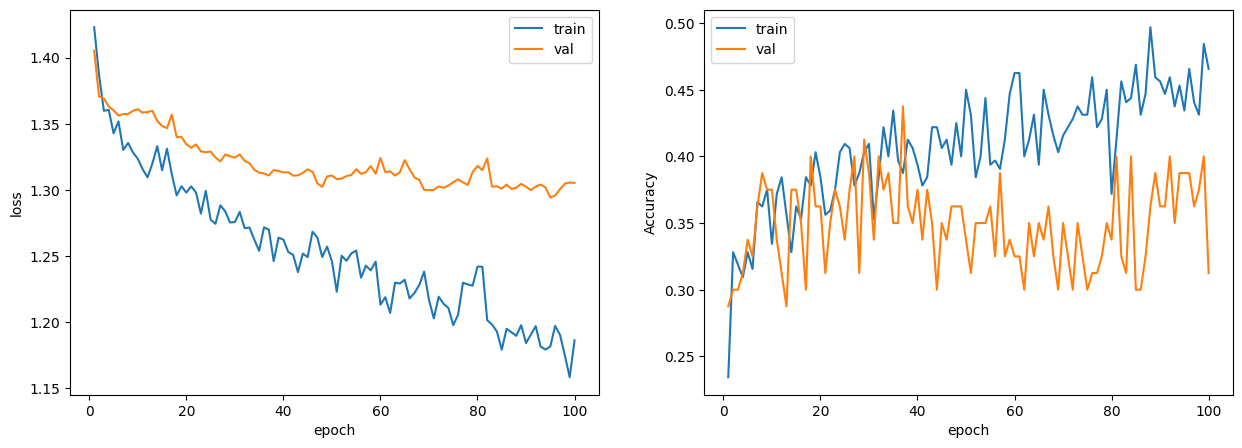

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
@torch.no_grad()
def predict(model, test_loader):
    model.eval()
    prediction = []

    for data, target in tqdm(test_loader, desc='Testing'):
        data = data.to(device)

        output = model(data)
        probabilities = torch.softmax(output, dim=1)
        prediction.append(probabilities)


    return prediction

In [ ]:
teset_dataset = TensorDataset(torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

test_loader = DataLoader(teset_dataset, batch_size=batch_size, shuffle=False)

preds = predict(model,test_loader)




Testing: 100%|██████████| 2/2 [00:00<00:00, 305.72it/s]


In [ ]:
conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()

In [62]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")


Accuracy: 0.57


## Попробуем другой оптимайзер

In [ ]:
num_epochs = 200

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = None



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/200: 100%|██████████| 2/2 [00:00<00:00, 447.97it/s]


Epoch 1
 train loss: 1.3994670867919923, train acc: 0.21875
 val loss: 1.3831697940826415, val acc: 0.2625



Validating epoch 2/200: 100%|██████████| 2/2 [00:00<00:00, 440.09it/s]


Epoch 2
 train loss: 1.3899255752563477, train acc: 0.28437501192092896
 val loss: 1.3838882446289062, val acc: 0.275



Validating epoch 3/200: 100%|██████████| 2/2 [00:00<00:00, 499.50it/s]


Epoch 3
 train loss: 1.3991365432739258, train acc: 0.23125000298023224
 val loss: 1.3719074726104736, val acc: 0.3125



Validating epoch 4/200: 100%|██████████| 2/2 [00:00<00:00, 405.38it/s]


Epoch 4
 train loss: 1.3779505491256714, train acc: 0.28437501192092896
 val loss: 1.3714675426483154, val acc: 0.2875



Validating epoch 5/200: 100%|██████████| 2/2 [00:00<00:00, 415.65it/s]


Epoch 5
 train loss: 1.3659009695053101, train acc: 0.3125
 val loss: 1.3712141036987304, val acc: 0.2875



Validating epoch 6/200: 100%|██████████| 2/2 [00:00<00:00, 399.23it/s]


Epoch 6
 train loss: 1.4186347484588624, train acc: 0.2750000059604645
 val loss: 1.4187685251235962, val acc: 0.2625



Validating epoch 7/200: 100%|██████████| 2/2 [00:00<00:00, 435.09it/s]


Epoch 7
 train loss: 1.4106971502304078, train acc: 0.3031249940395355
 val loss: 1.4264814138412476, val acc: 0.3



Validating epoch 8/200: 100%|██████████| 2/2 [00:00<00:00, 501.35it/s]


Epoch 8
 train loss: 1.390671467781067, train acc: 0.32500001788139343
 val loss: 1.4063119649887086, val acc: 0.325



Validating epoch 9/200: 100%|██████████| 2/2 [00:00<00:00, 474.07it/s]


Epoch 9
 train loss: 1.4010115146636963, train acc: 0.2718749940395355
 val loss: 1.4636156558990479, val acc: 0.225



Validating epoch 10/200: 100%|██████████| 2/2 [00:00<00:00, 474.93it/s]


Epoch 10
 train loss: 1.370041298866272, train acc: 0.3125
 val loss: 1.408263659477234, val acc: 0.3375



Validating epoch 11/200: 100%|██████████| 2/2 [00:00<00:00, 439.03it/s]


Epoch 11
 train loss: 1.399957799911499, train acc: 0.30000001192092896
 val loss: 1.4103177785873413, val acc: 0.3



Validating epoch 12/200: 100%|██████████| 2/2 [00:00<00:00, 461.34it/s]


Epoch 12
 train loss: 1.3888731241226195, train acc: 0.3187499940395355
 val loss: 1.3677246809005736, val acc: 0.3125



Validating epoch 13/200: 100%|██████████| 2/2 [00:00<00:00, 494.38it/s]


Epoch 13
 train loss: 1.3651793241500854, train acc: 0.3125
 val loss: 1.3587849617004395, val acc: 0.35



Validating epoch 14/200: 100%|██████████| 2/2 [00:00<00:00, 412.60it/s]


Epoch 14
 train loss: 1.340942096710205, train acc: 0.3375000059604645
 val loss: 1.3760413646697998, val acc: 0.3



Validating epoch 15/200: 100%|██████████| 2/2 [00:00<00:00, 470.35it/s]


Epoch 15
 train loss: 1.324807095527649, train acc: 0.37187501788139343
 val loss: 1.38619065284729, val acc: 0.275



Validating epoch 16/200: 100%|██████████| 2/2 [00:00<00:00, 432.80it/s]


Epoch 16
 train loss: 1.3545971870422364, train acc: 0.3531250059604645
 val loss: 1.3853002071380616, val acc: 0.3375



Validating epoch 17/200: 100%|██████████| 2/2 [00:00<00:00, 445.02it/s]


Epoch 17
 train loss: 1.352462601661682, train acc: 0.36250001192092896
 val loss: 1.3770176649093628, val acc: 0.2625



Validating epoch 18/200: 100%|██████████| 2/2 [00:00<00:00, 427.73it/s]


Epoch 18
 train loss: 1.3648502588272096, train acc: 0.32500001788139343
 val loss: 1.3692633628845214, val acc: 0.3875



Validating epoch 19/200: 100%|██████████| 2/2 [00:00<00:00, 401.97it/s]


Epoch 19
 train loss: 1.3778379440307618, train acc: 0.3218750059604645
 val loss: 1.3600670099258423, val acc: 0.3125



Validating epoch 20/200: 100%|██████████| 2/2 [00:00<00:00, 394.81it/s]


Epoch 20
 train loss: 1.3446979761123656, train acc: 0.3125
 val loss: 1.3461325407028197, val acc: 0.3875



Validating epoch 21/200: 100%|██████████| 2/2 [00:00<00:00, 404.99it/s]


Epoch 21
 train loss: 1.3160913467407227, train acc: 0.3843750059604645
 val loss: 1.3485218048095704, val acc: 0.325



Validating epoch 22/200: 100%|██████████| 2/2 [00:00<00:00, 397.64it/s]


Epoch 22
 train loss: 1.3333240032196045, train acc: 0.34687501192092896
 val loss: 1.3488448858261108, val acc: 0.3875



Validating epoch 23/200: 100%|██████████| 2/2 [00:00<00:00, 424.05it/s]


Epoch 23
 train loss: 1.3144890069961548, train acc: 0.34687501192092896
 val loss: 1.352964186668396, val acc: 0.325



Validating epoch 24/200: 100%|██████████| 2/2 [00:00<00:00, 404.00it/s]


Epoch 24
 train loss: 1.3376200437545775, train acc: 0.3187499940395355
 val loss: 1.3492431640625, val acc: 0.425



Validating epoch 25/200: 100%|██████████| 2/2 [00:00<00:00, 399.72it/s]


Epoch 25
 train loss: 1.2994766712188721, train acc: 0.3843750059604645
 val loss: 1.3472315311431884, val acc: 0.3875



Validating epoch 26/200: 100%|██████████| 2/2 [00:00<00:00, 402.22it/s]


Epoch 26
 train loss: 1.3383137941360475, train acc: 0.3375000059604645
 val loss: 1.3590537786483765, val acc: 0.3125



Validating epoch 27/200: 100%|██████████| 2/2 [00:00<00:00, 438.14it/s]


Epoch 27
 train loss: 1.3366017580032348, train acc: 0.3499999940395355
 val loss: 1.344729733467102, val acc: 0.375



Validating epoch 28/200: 100%|██████████| 2/2 [00:00<00:00, 478.53it/s]


Epoch 28
 train loss: 1.2840280294418336, train acc: 0.421875
 val loss: 1.356156849861145, val acc: 0.2875



Validating epoch 29/200: 100%|██████████| 2/2 [00:00<00:00, 411.59it/s]


Epoch 29
 train loss: 1.3246355533599854, train acc: 0.3375000059604645
 val loss: 1.341756558418274, val acc: 0.4



Validating epoch 30/200: 100%|██████████| 2/2 [00:00<00:00, 435.12it/s]


Epoch 30
 train loss: 1.3065338373184203, train acc: 0.375
 val loss: 1.3358013391494752, val acc: 0.375



Validating epoch 31/200: 100%|██████████| 2/2 [00:00<00:00, 372.74it/s]


Epoch 31
 train loss: 1.3138486862182617, train acc: 0.34687501192092896
 val loss: 1.3533538341522218, val acc: 0.3375



Validating epoch 32/200: 100%|██████████| 2/2 [00:00<00:00, 400.97it/s]


Epoch 32
 train loss: 1.3202523708343505, train acc: 0.33125001192092896
 val loss: 1.3363624095916748, val acc: 0.3875



Validating epoch 33/200: 100%|██████████| 2/2 [00:00<00:00, 411.89it/s]


Epoch 33
 train loss: 1.3067870140075684, train acc: 0.359375
 val loss: 1.3403100490570068, val acc: 0.375



Validating epoch 34/200: 100%|██████████| 2/2 [00:00<00:00, 307.33it/s]


Epoch 34
 train loss: 1.3307029008865356, train acc: 0.34062501788139343
 val loss: 1.336509346961975, val acc: 0.375



Validating epoch 35/200: 100%|██████████| 2/2 [00:00<00:00, 359.79it/s]


Epoch 35
 train loss: 1.3184520721435546, train acc: 0.3531250059604645
 val loss: 1.3431320190429688, val acc: 0.3625



Validating epoch 36/200: 100%|██████████| 2/2 [00:00<00:00, 276.94it/s]


Epoch 36
 train loss: 1.2976766586303712, train acc: 0.359375
 val loss: 1.3336227416992188, val acc: 0.4



Validating epoch 37/200: 100%|██████████| 2/2 [00:00<00:00, 199.26it/s]


Epoch 37
 train loss: 1.2709506511688233, train acc: 0.38750001788139343
 val loss: 1.328378939628601, val acc: 0.3625



Validating epoch 38/200: 100%|██████████| 2/2 [00:00<00:00, 250.79it/s]


Epoch 38
 train loss: 1.292817234992981, train acc: 0.37187501788139343
 val loss: 1.3484729528427124, val acc: 0.3125



Validating epoch 39/200: 100%|██████████| 2/2 [00:00<00:00, 350.28it/s]


Epoch 39
 train loss: 1.286861515045166, train acc: 0.3687500059604645
 val loss: 1.384312343597412, val acc: 0.4



Validating epoch 40/200: 100%|██████████| 2/2 [00:00<00:00, 402.78it/s]


Epoch 40
 train loss: 1.3734824895858764, train acc: 0.3499999940395355
 val loss: 1.3694876194000245, val acc: 0.275



Validating epoch 41/200: 100%|██████████| 2/2 [00:00<00:00, 382.50it/s]


Epoch 41
 train loss: 1.2881303071975707, train acc: 0.39375001192092896
 val loss: 1.347141146659851, val acc: 0.375



Validating epoch 42/200: 100%|██████████| 2/2 [00:00<00:00, 391.88it/s]


Epoch 42
 train loss: 1.3256872653961183, train acc: 0.3343749940395355
 val loss: 1.3374147891998291, val acc: 0.375



Validating epoch 43/200: 100%|██████████| 2/2 [00:00<00:00, 343.57it/s]


Epoch 43
 train loss: 1.3072994232177735, train acc: 0.40937501192092896
 val loss: 1.3425407886505127, val acc: 0.3375



Validating epoch 44/200: 100%|██████████| 2/2 [00:00<00:00, 409.10it/s]


Epoch 44
 train loss: 1.3125545740127564, train acc: 0.34375
 val loss: 1.3311343908309936, val acc: 0.3875



Validating epoch 45/200: 100%|██████████| 2/2 [00:00<00:00, 219.21it/s]


Epoch 45
 train loss: 1.2974604368209839, train acc: 0.375
 val loss: 1.327332615852356, val acc: 0.375



Validating epoch 46/200: 100%|██████████| 2/2 [00:00<00:00, 422.94it/s]


Epoch 46
 train loss: 1.286945104598999, train acc: 0.3843750059604645
 val loss: 1.328586745262146, val acc: 0.375



Validating epoch 47/200: 100%|██████████| 2/2 [00:00<00:00, 462.05it/s]


Epoch 47
 train loss: 1.2893829107284547, train acc: 0.38750001788139343
 val loss: 1.3311761617660522, val acc: 0.4



Validating epoch 48/200: 100%|██████████| 2/2 [00:00<00:00, 169.29it/s]


Epoch 48
 train loss: 1.2826433420181274, train acc: 0.3812499940395355
 val loss: 1.3286508798599244, val acc: 0.4125



Validating epoch 49/200: 100%|██████████| 2/2 [00:00<00:00, 62.44it/s]


Epoch 49
 train loss: 1.3075008869171143, train acc: 0.34687501192092896
 val loss: 1.3518458127975463, val acc: 0.275



Validating epoch 50/200: 100%|██████████| 2/2 [00:00<00:00, 71.63it/s]


Epoch 50
 train loss: 1.3013699531555176, train acc: 0.3687500059604645
 val loss: 1.3379988193511962, val acc: 0.3625



Validating epoch 51/200: 100%|██████████| 2/2 [00:00<00:00, 68.46it/s]


Epoch 51
 train loss: 1.3059591770172119, train acc: 0.3656249940395355
 val loss: 1.3205126762390136, val acc: 0.425



Validating epoch 52/200: 100%|██████████| 2/2 [00:00<00:00, 79.66it/s]


Epoch 52
 train loss: 1.3119284629821777, train acc: 0.3687500059604645
 val loss: 1.3376466989517213, val acc: 0.2875



Validating epoch 53/200: 100%|██████████| 2/2 [00:00<00:00, 74.15it/s]


Epoch 53
 train loss: 1.2929801940917969, train acc: 0.34062501788139343
 val loss: 1.3293444871902467, val acc: 0.3875



Validating epoch 54/200: 100%|██████████| 2/2 [00:00<00:00, 105.94it/s]


Epoch 54
 train loss: 1.2981881141662597, train acc: 0.375
 val loss: 1.3224782943725586, val acc: 0.4375



Validating epoch 55/200: 100%|██████████| 2/2 [00:00<00:00, 447.61it/s]


Epoch 55
 train loss: 1.2795615434646606, train acc: 0.4124999940395355
 val loss: 1.3220872163772583, val acc: 0.375



Validating epoch 56/200: 100%|██████████| 2/2 [00:00<00:00, 91.93it/s]


Epoch 56
 train loss: 1.2579169750213623, train acc: 0.4312500059604645
 val loss: 1.3287447690963745, val acc: 0.4



Validating epoch 57/200: 100%|██████████| 2/2 [00:00<00:00, 124.78it/s]


Epoch 57
 train loss: 1.2946624755859375, train acc: 0.3812499940395355
 val loss: 1.331705141067505, val acc: 0.3625



Validating epoch 58/200: 100%|██████████| 2/2 [00:00<00:00, 228.88it/s]


Epoch 58
 train loss: 1.2998926877975463, train acc: 0.3812499940395355
 val loss: 1.3386111974716186, val acc: 0.3125



Validating epoch 59/200: 100%|██████████| 2/2 [00:00<00:00, 411.11it/s]


Epoch 59
 train loss: 1.275987720489502, train acc: 0.40312501788139343
 val loss: 1.3128432035446167, val acc: 0.3625



Validating epoch 60/200: 100%|██████████| 2/2 [00:00<00:00, 252.39it/s]


Epoch 60
 train loss: 1.281086230278015, train acc: 0.40937501192092896
 val loss: 1.3280573606491088, val acc: 0.3875



Validating epoch 61/200: 100%|██████████| 2/2 [00:00<00:00, 278.97it/s]


Epoch 61
 train loss: 1.266866421699524, train acc: 0.3843750059604645
 val loss: 1.3209451913833619, val acc: 0.375



Validating epoch 62/200: 100%|██████████| 2/2 [00:00<00:00, 365.87it/s]


Epoch 62
 train loss: 1.2675793409347533, train acc: 0.38750001788139343
 val loss: 1.3193601846694947, val acc: 0.35



Validating epoch 63/200: 100%|██████████| 2/2 [00:00<00:00, 404.06it/s]


Epoch 63
 train loss: 1.3087939739227294, train acc: 0.34375
 val loss: 1.3195046663284302, val acc: 0.3875



Validating epoch 64/200: 100%|██████████| 2/2 [00:00<00:00, 300.38it/s]


Epoch 64
 train loss: 1.2906705856323242, train acc: 0.37187501788139343
 val loss: 1.3186233520507813, val acc: 0.3875



Validating epoch 65/200: 100%|██████████| 2/2 [00:00<00:00, 411.69it/s]


Epoch 65
 train loss: 1.2642019987106323, train acc: 0.4000000059604645
 val loss: 1.316600775718689, val acc: 0.3875



Validating epoch 66/200: 100%|██████████| 2/2 [00:00<00:00, 390.02it/s]


Epoch 66
 train loss: 1.2833462953567505, train acc: 0.4000000059604645
 val loss: 1.3157709121704102, val acc: 0.4



Validating epoch 67/200: 100%|██████████| 2/2 [00:00<00:00, 406.76it/s]


Epoch 67
 train loss: 1.2675915002822875, train acc: 0.38750001788139343
 val loss: 1.3126752614974975, val acc: 0.4125



Validating epoch 68/200: 100%|██████████| 2/2 [00:00<00:00, 424.25it/s]


Epoch 68
 train loss: 1.2808892011642456, train acc: 0.39375001192092896
 val loss: 1.3080476999282837, val acc: 0.3125



Validating epoch 69/200: 100%|██████████| 2/2 [00:00<00:00, 425.15it/s]


Epoch 69
 train loss: 1.27713303565979, train acc: 0.375
 val loss: 1.3157127618789672, val acc: 0.45



Validating epoch 70/200: 100%|██████████| 2/2 [00:00<00:00, 459.15it/s]


Epoch 70
 train loss: 1.2818666696548462, train acc: 0.390625
 val loss: 1.3186700105667115, val acc: 0.3625



Validating epoch 71/200: 100%|██████████| 2/2 [00:00<00:00, 411.85it/s]


Epoch 71
 train loss: 1.28552143573761, train acc: 0.38750001788139343
 val loss: 1.336879563331604, val acc: 0.4125



Validating epoch 72/200: 100%|██████████| 2/2 [00:00<00:00, 427.99it/s]


Epoch 72
 train loss: 1.3216055870056151, train acc: 0.34062501788139343
 val loss: 1.395491361618042, val acc: 0.1875



Validating epoch 73/200: 100%|██████████| 2/2 [00:00<00:00, 436.50it/s]


Epoch 73
 train loss: 1.3134864091873169, train acc: 0.3687500059604645
 val loss: 1.3276355266571045, val acc: 0.3875



Validating epoch 74/200: 100%|██████████| 2/2 [00:00<00:00, 440.19it/s]


Epoch 74
 train loss: 1.3202609777450562, train acc: 0.34375
 val loss: 1.3463557720184327, val acc: 0.3



Validating epoch 75/200: 100%|██████████| 2/2 [00:00<00:00, 234.46it/s]


Epoch 75
 train loss: 1.3049997091293335, train acc: 0.3499999940395355
 val loss: 1.3287364959716796, val acc: 0.375



Validating epoch 76/200: 100%|██████████| 2/2 [00:00<00:00, 322.51it/s]


Epoch 76
 train loss: 1.2821770906448364, train acc: 0.38750001788139343
 val loss: 1.3329986333847046, val acc: 0.3125



Validating epoch 77/200: 100%|██████████| 2/2 [00:00<00:00, 301.39it/s]


Epoch 77
 train loss: 1.288280153274536, train acc: 0.359375
 val loss: 1.3222296714782715, val acc: 0.4



Validating epoch 78/200: 100%|██████████| 2/2 [00:00<00:00, 404.58it/s]


Epoch 78
 train loss: 1.2845933437347412, train acc: 0.375
 val loss: 1.3165258646011353, val acc: 0.3125



Validating epoch 79/200: 100%|██████████| 2/2 [00:00<00:00, 457.22it/s]


Epoch 79
 train loss: 1.2599934101104737, train acc: 0.40312501788139343
 val loss: 1.3256978034973144, val acc: 0.4



Validating epoch 80/200: 100%|██████████| 2/2 [00:00<00:00, 411.17it/s]


Epoch 80
 train loss: 1.2790136337280273, train acc: 0.3812499940395355
 val loss: 1.3240842342376709, val acc: 0.45



Validating epoch 81/200: 100%|██████████| 2/2 [00:00<00:00, 433.27it/s]


Epoch 81
 train loss: 1.2750654935836792, train acc: 0.38750001788139343
 val loss: 1.3233397006988525, val acc: 0.3125



Validating epoch 82/200: 100%|██████████| 2/2 [00:00<00:00, 434.73it/s]


Epoch 82
 train loss: 1.268882155418396, train acc: 0.39375001192092896
 val loss: 1.3229353189468385, val acc: 0.4



Validating epoch 83/200: 100%|██████████| 2/2 [00:00<00:00, 438.21it/s]


Epoch 83
 train loss: 1.2586152315139771, train acc: 0.3687500059604645
 val loss: 1.316391611099243, val acc: 0.375



Validating epoch 84/200: 100%|██████████| 2/2 [00:00<00:00, 420.14it/s]


Epoch 84
 train loss: 1.2528027296066284, train acc: 0.4124999940395355
 val loss: 1.3073914051055908, val acc: 0.4



Validating epoch 85/200: 100%|██████████| 2/2 [00:00<00:00, 380.35it/s]


Epoch 85
 train loss: 1.2689126968383788, train acc: 0.375
 val loss: 1.315436840057373, val acc: 0.35



Validating epoch 86/200: 100%|██████████| 2/2 [00:00<00:00, 347.48it/s]


Epoch 86
 train loss: 1.2647809505462646, train acc: 0.4000000059604645
 val loss: 1.3149906873703003, val acc: 0.4125



Validating epoch 87/200: 100%|██████████| 2/2 [00:00<00:00, 352.23it/s]


Epoch 87
 train loss: 1.2697903156280517, train acc: 0.38750001788139343
 val loss: 1.3286728620529176, val acc: 0.2875



Validating epoch 88/200: 100%|██████████| 2/2 [00:00<00:00, 253.85it/s]


Epoch 88
 train loss: 1.2656351566314696, train acc: 0.4000000059604645
 val loss: 1.320340347290039, val acc: 0.4



Validating epoch 89/200: 100%|██████████| 2/2 [00:00<00:00, 411.73it/s]


Epoch 89
 train loss: 1.3080736160278321, train acc: 0.3531250059604645
 val loss: 1.3187079429626465, val acc: 0.4



Validating epoch 90/200: 100%|██████████| 2/2 [00:00<00:00, 397.36it/s]


Epoch 90
 train loss: 1.2784648656845092, train acc: 0.390625
 val loss: 1.3176927328109742, val acc: 0.3875



Validating epoch 91/200: 100%|██████████| 2/2 [00:00<00:00, 381.28it/s]


Epoch 91
 train loss: 1.2609459400177, train acc: 0.4000000059604645
 val loss: 1.3160608291625977, val acc: 0.35



Validating epoch 92/200: 100%|██████████| 2/2 [00:00<00:00, 423.92it/s]


Epoch 92
 train loss: 1.2510402917861938, train acc: 0.37187501788139343
 val loss: 1.3231437444686889, val acc: 0.3875



Validating epoch 93/200: 100%|██████████| 2/2 [00:00<00:00, 270.85it/s]


Epoch 93
 train loss: 1.2570576667785645, train acc: 0.42500001192092896
 val loss: 1.3189656734466553, val acc: 0.3625



Validating epoch 94/200: 100%|██████████| 2/2 [00:00<00:00, 457.17it/s]


Epoch 94
 train loss: 1.2510538578033448, train acc: 0.41875001788139343
 val loss: 1.3118074655532836, val acc: 0.4125



Validating epoch 95/200: 100%|██████████| 2/2 [00:00<00:00, 448.16it/s]


Epoch 95
 train loss: 1.2478873491287232, train acc: 0.40625
 val loss: 1.319335436820984, val acc: 0.4



Validating epoch 96/200: 100%|██████████| 2/2 [00:00<00:00, 287.39it/s]


Epoch 96
 train loss: 1.2190102577209472, train acc: 0.421875
 val loss: 1.319705605506897, val acc: 0.35



Validating epoch 97/200: 100%|██████████| 2/2 [00:00<00:00, 385.77it/s]


Epoch 97
 train loss: 1.2565907478332519, train acc: 0.4375
 val loss: 1.3374341487884522, val acc: 0.3625



Validating epoch 98/200: 100%|██████████| 2/2 [00:00<00:00, 408.26it/s]


Epoch 98
 train loss: 1.2607929229736328, train acc: 0.42500001192092896
 val loss: 1.3532280683517457, val acc: 0.3375



Validating epoch 99/200: 100%|██████████| 2/2 [00:00<00:00, 386.50it/s]


Epoch 99
 train loss: 1.2794348478317261, train acc: 0.35625001788139343
 val loss: 1.3185477256774902, val acc: 0.3375



Validating epoch 100/200: 100%|██████████| 2/2 [00:00<00:00, 450.73it/s]


Epoch 100
 train loss: 1.2423884868621826, train acc: 0.37187501788139343
 val loss: 1.3154255628585816, val acc: 0.375



Validating epoch 101/200: 100%|██████████| 2/2 [00:00<00:00, 413.01it/s]


Epoch 101
 train loss: 1.2505005598068237, train acc: 0.43437501788139343
 val loss: 1.3102046728134156, val acc: 0.4



Validating epoch 102/200: 100%|██████████| 2/2 [00:00<00:00, 408.68it/s]


Epoch 102
 train loss: 1.262085509300232, train acc: 0.359375
 val loss: 1.3113600969314576, val acc: 0.375



Validating epoch 103/200: 100%|██████████| 2/2 [00:00<00:00, 400.16it/s]


Epoch 103
 train loss: 1.2465579748153686, train acc: 0.40312501788139343
 val loss: 1.3039919853210449, val acc: 0.3875



Validating epoch 104/200: 100%|██████████| 2/2 [00:00<00:00, 257.79it/s]


Epoch 104
 train loss: 1.2640000581741333, train acc: 0.37812501192092896
 val loss: 1.3111242294311523, val acc: 0.375



Validating epoch 105/200: 100%|██████████| 2/2 [00:00<00:00, 386.79it/s]


Epoch 105
 train loss: 1.2709433078765868, train acc: 0.37812501192092896
 val loss: 1.3147998809814454, val acc: 0.4



Validating epoch 106/200: 100%|██████████| 2/2 [00:00<00:00, 464.82it/s]


Epoch 106
 train loss: 1.2520861387252809, train acc: 0.4312500059604645
 val loss: 1.3166018724441528, val acc: 0.375



Validating epoch 107/200: 100%|██████████| 2/2 [00:00<00:00, 356.14it/s]


Epoch 107
 train loss: 1.252526831626892, train acc: 0.37812501192092896
 val loss: 1.326629137992859, val acc: 0.2875



Validating epoch 108/200: 100%|██████████| 2/2 [00:00<00:00, 440.16it/s]


Epoch 108
 train loss: 1.2686545610427857, train acc: 0.3812499940395355
 val loss: 1.307196855545044, val acc: 0.425



Validating epoch 109/200: 100%|██████████| 2/2 [00:00<00:00, 436.02it/s]


Epoch 109
 train loss: 1.2424513578414917, train acc: 0.41875001788139343
 val loss: 1.3168694019317626, val acc: 0.3625



Validating epoch 110/200: 100%|██████████| 2/2 [00:00<00:00, 363.25it/s]


Epoch 110
 train loss: 1.2638714075088502, train acc: 0.37812501192092896
 val loss: 1.3173103094100953, val acc: 0.4375



Validating epoch 111/200: 100%|██████████| 2/2 [00:00<00:00, 385.12it/s]


Epoch 111
 train loss: 1.2448275327682494, train acc: 0.390625
 val loss: 1.3145477771759033, val acc: 0.35



Validating epoch 112/200: 100%|██████████| 2/2 [00:00<00:00, 424.48it/s]


Epoch 112
 train loss: 1.279746150970459, train acc: 0.37812501192092896
 val loss: 1.309789228439331, val acc: 0.4125



Validating epoch 113/200: 100%|██████████| 2/2 [00:00<00:00, 362.48it/s]


Epoch 113
 train loss: 1.252557063102722, train acc: 0.39375001192092896
 val loss: 1.3132545709609986, val acc: 0.4125



Validating epoch 114/200: 100%|██████████| 2/2 [00:00<00:00, 458.69it/s]


Epoch 114
 train loss: 1.240657114982605, train acc: 0.421875
 val loss: 1.304337167739868, val acc: 0.325



Validating epoch 115/200: 100%|██████████| 2/2 [00:00<00:00, 374.02it/s]


Epoch 115
 train loss: 1.239940881729126, train acc: 0.3968749940395355
 val loss: 1.3213963508605957, val acc: 0.3125



Validating epoch 116/200: 100%|██████████| 2/2 [00:00<00:00, 268.04it/s]


Epoch 116
 train loss: 1.256041979789734, train acc: 0.3968749940395355
 val loss: 1.3077253818511962, val acc: 0.3875



Validating epoch 117/200: 100%|██████████| 2/2 [00:00<00:00, 396.17it/s]


Epoch 117
 train loss: 1.2257633447647094, train acc: 0.40312501788139343
 val loss: 1.3150118827819823, val acc: 0.375



Validating epoch 118/200: 100%|██████████| 2/2 [00:00<00:00, 424.85it/s]


Epoch 118
 train loss: 1.2455188274383544, train acc: 0.38750001788139343
 val loss: 1.313467526435852, val acc: 0.4



Validating epoch 119/200: 100%|██████████| 2/2 [00:00<00:00, 405.70it/s]


Epoch 119
 train loss: 1.2719056606292725, train acc: 0.390625
 val loss: 1.3518560886383058, val acc: 0.2875



Validating epoch 120/200: 100%|██████████| 2/2 [00:00<00:00, 422.94it/s]


Epoch 120
 train loss: 1.2617742538452148, train acc: 0.37812501192092896
 val loss: 1.3118791341781617, val acc: 0.3375



Validating epoch 121/200: 100%|██████████| 2/2 [00:00<00:00, 433.63it/s]


Epoch 121
 train loss: 1.2648789882659912, train acc: 0.4124999940395355
 val loss: 1.3126357316970825, val acc: 0.3125



Validating epoch 122/200: 100%|██████████| 2/2 [00:00<00:00, 334.59it/s]


Epoch 122
 train loss: 1.278092050552368, train acc: 0.3812499940395355
 val loss: 1.3178528547286987, val acc: 0.375



Validating epoch 123/200: 100%|██████████| 2/2 [00:00<00:00, 344.61it/s]


Epoch 123
 train loss: 1.241448712348938, train acc: 0.4156250059604645
 val loss: 1.308121418952942, val acc: 0.4125



Validating epoch 124/200: 100%|██████████| 2/2 [00:00<00:00, 419.79it/s]


Epoch 124
 train loss: 1.2523910284042359, train acc: 0.390625
 val loss: 1.3147509098052979, val acc: 0.3625



Validating epoch 125/200: 100%|██████████| 2/2 [00:00<00:00, 357.51it/s]


Epoch 125
 train loss: 1.2285937786102294, train acc: 0.43437501788139343
 val loss: 1.3205079317092896, val acc: 0.3375



Validating epoch 126/200: 100%|██████████| 2/2 [00:00<00:00, 435.41it/s]


Epoch 126
 train loss: 1.2487674713134767, train acc: 0.40625
 val loss: 1.3624528646469116, val acc: 0.25



Validating epoch 127/200: 100%|██████████| 2/2 [00:00<00:00, 246.04it/s]


Epoch 127
 train loss: 1.2669905185699464, train acc: 0.421875
 val loss: 1.3184141397476197, val acc: 0.4125



Validating epoch 128/200: 100%|██████████| 2/2 [00:00<00:00, 287.36it/s]


Epoch 128
 train loss: 1.248353910446167, train acc: 0.41875001788139343
 val loss: 1.3078043937683106, val acc: 0.3125



Validating epoch 129/200: 100%|██████████| 2/2 [00:00<00:00, 438.21it/s]


Epoch 129
 train loss: 1.2422188520431519, train acc: 0.39375001192092896
 val loss: 1.3092551231384277, val acc: 0.4125



Validating epoch 130/200: 100%|██████████| 2/2 [00:00<00:00, 402.12it/s]


Epoch 130
 train loss: 1.22638041973114, train acc: 0.4375
 val loss: 1.3085600137710571, val acc: 0.325



Validating epoch 131/200: 100%|██████████| 2/2 [00:00<00:00, 334.90it/s]


Epoch 131
 train loss: 1.2178079605102539, train acc: 0.43437501788139343
 val loss: 1.3082982778549195, val acc: 0.4



Validating epoch 132/200: 100%|██████████| 2/2 [00:00<00:00, 423.05it/s]


Epoch 132
 train loss: 1.2252622842788696, train acc: 0.4124999940395355
 val loss: 1.3113741874694824, val acc: 0.3875



Validating epoch 133/200: 100%|██████████| 2/2 [00:00<00:00, 417.51it/s]


Epoch 133
 train loss: 1.2162413120269775, train acc: 0.4375
 val loss: 1.2998414516448975, val acc: 0.3125



Validating epoch 134/200: 100%|██████████| 2/2 [00:00<00:00, 370.08it/s]


Epoch 134
 train loss: 1.2398603916168214, train acc: 0.41875001788139343
 val loss: 1.3176947593688966, val acc: 0.375



Validating epoch 135/200: 100%|██████████| 2/2 [00:00<00:00, 448.52it/s]


Epoch 135
 train loss: 1.2481040000915526, train acc: 0.39375001192092896
 val loss: 1.3111843109130858, val acc: 0.3875



Validating epoch 136/200: 100%|██████████| 2/2 [00:00<00:00, 442.48it/s]


Epoch 136
 train loss: 1.2549397468566894, train acc: 0.3656249940395355
 val loss: 1.3097630977630614, val acc: 0.3375



Validating epoch 137/200: 100%|██████████| 2/2 [00:00<00:00, 425.34it/s]


Epoch 137
 train loss: 1.2338416814804076, train acc: 0.40937501192092896
 val loss: 1.3003042221069336, val acc: 0.3875



Validating epoch 138/200: 100%|██████████| 2/2 [00:00<00:00, 392.06it/s]


Epoch 138
 train loss: 1.2134533405303956, train acc: 0.40625
 val loss: 1.3004759788513183, val acc: 0.3375



Validating epoch 139/200: 100%|██████████| 2/2 [00:00<00:00, 260.25it/s]


Epoch 139
 train loss: 1.223323369026184, train acc: 0.43437501788139343
 val loss: 1.329862928390503, val acc: 0.3125



Validating epoch 140/200: 100%|██████████| 2/2 [00:00<00:00, 448.16it/s]


Epoch 140
 train loss: 1.2699501276016236, train acc: 0.4000000059604645
 val loss: 1.304711604118347, val acc: 0.3625



Validating epoch 141/200: 100%|██████████| 2/2 [00:00<00:00, 463.20it/s]


Epoch 141
 train loss: 1.2733813047409057, train acc: 0.390625
 val loss: 1.3108961582183838, val acc: 0.3375



Validating epoch 142/200: 100%|██████████| 2/2 [00:00<00:00, 440.56it/s]


Epoch 142
 train loss: 1.2707939386367797, train acc: 0.3687500059604645
 val loss: 1.3228308439254761, val acc: 0.3625



Validating epoch 143/200: 100%|██████████| 2/2 [00:00<00:00, 403.82it/s]


Epoch 143
 train loss: 1.2623396635055542, train acc: 0.3968749940395355
 val loss: 1.30638587474823, val acc: 0.3875



Validating epoch 144/200: 100%|██████████| 2/2 [00:00<00:00, 372.45it/s]


Epoch 144
 train loss: 1.2529221057891846, train acc: 0.4000000059604645
 val loss: 1.336272692680359, val acc: 0.35



Validating epoch 145/200: 100%|██████████| 2/2 [00:00<00:00, 422.03it/s]


Epoch 145
 train loss: 1.236827802658081, train acc: 0.40625
 val loss: 1.3060590982437135, val acc: 0.375



Validating epoch 146/200: 100%|██████████| 2/2 [00:00<00:00, 369.79it/s]


Epoch 146
 train loss: 1.246446967124939, train acc: 0.4156250059604645
 val loss: 1.3044634103775024, val acc: 0.3



Validating epoch 147/200: 100%|██████████| 2/2 [00:00<00:00, 241.76it/s]


Epoch 147
 train loss: 1.2084999799728393, train acc: 0.4281249940395355
 val loss: 1.3045624017715454, val acc: 0.3875



Validating epoch 148/200: 100%|██████████| 2/2 [00:00<00:00, 369.36it/s]


Epoch 148
 train loss: 1.2290806770324707, train acc: 0.4000000059604645
 val loss: 1.305110263824463, val acc: 0.425



Validating epoch 149/200: 100%|██████████| 2/2 [00:00<00:00, 448.40it/s]


Epoch 149
 train loss: 1.2190179347991943, train acc: 0.453125
 val loss: 1.3273375749588012, val acc: 0.3375



Validating epoch 150/200: 100%|██████████| 2/2 [00:00<00:00, 423.00it/s]


Epoch 150
 train loss: 1.1920292854309082, train acc: 0.45625001192092896
 val loss: 1.3182401418685914, val acc: 0.3625



Validating epoch 151/200: 100%|██████████| 2/2 [00:00<00:00, 346.48it/s]


Epoch 151
 train loss: 1.252782440185547, train acc: 0.38750001788139343
 val loss: 1.3094985485076904, val acc: 0.3



Validating epoch 152/200: 100%|██████████| 2/2 [00:00<00:00, 435.75it/s]


Epoch 152
 train loss: 1.215853786468506, train acc: 0.4312500059604645
 val loss: 1.305793857574463, val acc: 0.375



Validating epoch 153/200: 100%|██████████| 2/2 [00:00<00:00, 427.58it/s]


Epoch 153
 train loss: 1.2213469982147216, train acc: 0.4281249940395355
 val loss: 1.2970459938049317, val acc: 0.3875



Validating epoch 154/200: 100%|██████████| 2/2 [00:00<00:00, 420.99it/s]


Epoch 154
 train loss: 1.2149996280670166, train acc: 0.40312501788139343
 val loss: 1.3236128091812134, val acc: 0.375



Validating epoch 155/200: 100%|██████████| 2/2 [00:00<00:00, 417.88it/s]


Epoch 155
 train loss: 1.2081109523773192, train acc: 0.43437501788139343
 val loss: 1.3004479646682738, val acc: 0.3875



Validating epoch 156/200: 100%|██████████| 2/2 [00:00<00:00, 310.39it/s]


Epoch 156
 train loss: 1.218366551399231, train acc: 0.4156250059604645
 val loss: 1.30484299659729, val acc: 0.3375



Validating epoch 157/200: 100%|██████████| 2/2 [00:00<00:00, 329.17it/s]


Epoch 157
 train loss: 1.211220121383667, train acc: 0.4156250059604645
 val loss: 1.3058011054992675, val acc: 0.325



Validating epoch 158/200: 100%|██████████| 2/2 [00:00<00:00, 335.06it/s]


Epoch 158
 train loss: 1.2608247995376587, train acc: 0.375
 val loss: 1.3486790180206298, val acc: 0.35



Validating epoch 159/200: 100%|██████████| 2/2 [00:00<00:00, 323.45it/s]


Epoch 159
 train loss: 1.2642037630081178, train acc: 0.37187501788139343
 val loss: 1.3185426235198974, val acc: 0.35



Validating epoch 160/200: 100%|██████████| 2/2 [00:00<00:00, 398.79it/s]


Epoch 160
 train loss: 1.225570559501648, train acc: 0.4156250059604645
 val loss: 1.3025763034820557, val acc: 0.325



Validating epoch 161/200: 100%|██████████| 2/2 [00:00<00:00, 413.17it/s]


Epoch 161
 train loss: 1.1945917129516601, train acc: 0.453125
 val loss: 1.2926577091217042, val acc: 0.4125



Validating epoch 162/200: 100%|██████████| 2/2 [00:00<00:00, 232.32it/s]


Epoch 162
 train loss: 1.2110281944274903, train acc: 0.4375
 val loss: 1.305107593536377, val acc: 0.3



Validating epoch 163/200: 100%|██████████| 2/2 [00:00<00:00, 332.89it/s]


Epoch 163
 train loss: 1.240465807914734, train acc: 0.41875001788139343
 val loss: 1.2972174167633057, val acc: 0.3875



Validating epoch 164/200: 100%|██████████| 2/2 [00:00<00:00, 410.80it/s]


Epoch 164
 train loss: 1.2085993766784668, train acc: 0.4312500059604645
 val loss: 1.2964051723480225, val acc: 0.375



Validating epoch 165/200: 100%|██████████| 2/2 [00:00<00:00, 440.69it/s]


Epoch 165
 train loss: 1.2102259874343873, train acc: 0.4281249940395355
 val loss: 1.2857927560806275, val acc: 0.4125



Validating epoch 166/200: 100%|██████████| 2/2 [00:00<00:00, 368.23it/s]


Epoch 166
 train loss: 1.1977912187576294, train acc: 0.46875
 val loss: 1.340852642059326, val acc: 0.3



Validating epoch 167/200: 100%|██████████| 2/2 [00:00<00:00, 485.37it/s]


Epoch 167
 train loss: 1.2456703186035156, train acc: 0.40937501192092896
 val loss: 1.3062878608703614, val acc: 0.4



Validating epoch 168/200: 100%|██████████| 2/2 [00:00<00:00, 445.99it/s]


Epoch 168
 train loss: 1.2187018632888793, train acc: 0.40312501788139343
 val loss: 1.3122228622436523, val acc: 0.3625



Validating epoch 169/200: 100%|██████████| 2/2 [00:00<00:00, 409.10it/s]


Epoch 169
 train loss: 1.247376298904419, train acc: 0.4312500059604645
 val loss: 1.3118722915649415, val acc: 0.3125



Validating epoch 170/200: 100%|██████████| 2/2 [00:00<00:00, 428.38it/s]


Epoch 170
 train loss: 1.2410170078277587, train acc: 0.4156250059604645
 val loss: 1.3003506422042848, val acc: 0.3875



Validating epoch 171/200: 100%|██████████| 2/2 [00:00<00:00, 426.23it/s]


Epoch 171
 train loss: 1.2411438703536988, train acc: 0.4000000059604645
 val loss: 1.2974381685256957, val acc: 0.3625



Validating epoch 172/200: 100%|██████████| 2/2 [00:00<00:00, 351.58it/s]


Epoch 172
 train loss: 1.2093342781066894, train acc: 0.42500001192092896
 val loss: 1.3043530702590942, val acc: 0.3875



Validating epoch 173/200: 100%|██████████| 2/2 [00:00<00:00, 361.81it/s]


Epoch 173
 train loss: 1.2357842922210693, train acc: 0.40937501192092896
 val loss: 1.2963831901550293, val acc: 0.3625



Validating epoch 174/200: 100%|██████████| 2/2 [00:00<00:00, 364.64it/s]


Epoch 174
 train loss: 1.205228042602539, train acc: 0.4281249940395355
 val loss: 1.304246473312378, val acc: 0.4



Validating epoch 175/200: 100%|██████████| 2/2 [00:00<00:00, 412.58it/s]


Epoch 175
 train loss: 1.2205313205718995, train acc: 0.42500001192092896
 val loss: 1.3122973442077637, val acc: 0.4125



Validating epoch 176/200: 100%|██████████| 2/2 [00:00<00:00, 267.85it/s]


Epoch 176
 train loss: 1.218506145477295, train acc: 0.3812499940395355
 val loss: 1.317387628555298, val acc: 0.4125



Validating epoch 177/200: 100%|██████████| 2/2 [00:00<00:00, 407.31it/s]


Epoch 177
 train loss: 1.2107080459594726, train acc: 0.453125
 val loss: 1.2989857912063598, val acc: 0.425



Validating epoch 178/200: 100%|██████████| 2/2 [00:00<00:00, 335.57it/s]


Epoch 178
 train loss: 1.2010612487792969, train acc: 0.4281249940395355
 val loss: 1.31948983669281, val acc: 0.35



Validating epoch 179/200: 100%|██████████| 2/2 [00:00<00:00, 457.02it/s]


Epoch 179
 train loss: 1.2522631645202638, train acc: 0.4156250059604645
 val loss: 1.3142192363739014, val acc: 0.3



Validating epoch 180/200: 100%|██████████| 2/2 [00:00<00:00, 442.55it/s]


Epoch 180
 train loss: 1.2516993045806886, train acc: 0.40625
 val loss: 1.3405761241912841, val acc: 0.375



Validating epoch 181/200: 100%|██████████| 2/2 [00:00<00:00, 398.43it/s]


Epoch 181
 train loss: 1.3075308561325074, train acc: 0.36250001192092896
 val loss: 1.327073097229004, val acc: 0.325



Validating epoch 182/200: 100%|██████████| 2/2 [00:00<00:00, 416.85it/s]


Epoch 182
 train loss: 1.2599087476730346, train acc: 0.40625
 val loss: 1.3068884372711183, val acc: 0.3875



Validating epoch 183/200: 100%|██████████| 2/2 [00:00<00:00, 403.14it/s]


Epoch 183
 train loss: 1.2403172492980956, train acc: 0.40937501192092896
 val loss: 1.3097561120986938, val acc: 0.3125



Validating epoch 184/200: 100%|██████████| 2/2 [00:00<00:00, 305.43it/s]


Epoch 184
 train loss: 1.1897423267364502, train acc: 0.4437499940395355
 val loss: 1.3034615755081176, val acc: 0.425



Validating epoch 185/200: 100%|██████████| 2/2 [00:00<00:00, 413.07it/s]


Epoch 185
 train loss: 1.2015125274658203, train acc: 0.4625000059604645
 val loss: 1.3016784191131592, val acc: 0.325



Validating epoch 186/200: 100%|██████████| 2/2 [00:00<00:00, 424.20it/s]


Epoch 186
 train loss: 1.2149878025054932, train acc: 0.42500001192092896
 val loss: 1.3173991203308106, val acc: 0.3875



Validating epoch 187/200: 100%|██████████| 2/2 [00:00<00:00, 442.09it/s]


Epoch 187
 train loss: 1.204963779449463, train acc: 0.42500001192092896
 val loss: 1.3083719491958619, val acc: 0.3375



Validating epoch 188/200: 100%|██████████| 2/2 [00:00<00:00, 390.79it/s]


Epoch 188
 train loss: 1.2254752159118651, train acc: 0.42500001192092896
 val loss: 1.3062256574630737, val acc: 0.3875



Validating epoch 189/200: 100%|██████████| 2/2 [00:00<00:00, 424.83it/s]


Epoch 189
 train loss: 1.2116244316101075, train acc: 0.44062501192092896
 val loss: 1.313781976699829, val acc: 0.3125



Validating epoch 190/200: 100%|██████████| 2/2 [00:00<00:00, 414.70it/s]


Epoch 190
 train loss: 1.2185579299926759, train acc: 0.421875
 val loss: 1.290631604194641, val acc: 0.4125



Validating epoch 191/200: 100%|██████████| 2/2 [00:00<00:00, 434.96it/s]


Epoch 191
 train loss: 1.20052011013031, train acc: 0.43437501788139343
 val loss: 1.293898344039917, val acc: 0.3875



Validating epoch 192/200: 100%|██████████| 2/2 [00:00<00:00, 445.85it/s]


Epoch 192
 train loss: 1.1872958183288573, train acc: 0.4593749940395355
 val loss: 1.3359052181243896, val acc: 0.375



Validating epoch 193/200: 100%|██████████| 2/2 [00:00<00:00, 410.20it/s]


Epoch 193
 train loss: 1.201342558860779, train acc: 0.4281249940395355
 val loss: 1.3268563508987428, val acc: 0.4



Validating epoch 194/200: 100%|██████████| 2/2 [00:00<00:00, 438.39it/s]


Epoch 194
 train loss: 1.2231839179992676, train acc: 0.4124999940395355
 val loss: 1.3076592683792114, val acc: 0.375



Validating epoch 195/200: 100%|██████████| 2/2 [00:00<00:00, 426.75it/s]


Epoch 195
 train loss: 1.240045714378357, train acc: 0.45000001788139343
 val loss: 1.3374291896820067, val acc: 0.3



Validating epoch 196/200: 100%|██████████| 2/2 [00:00<00:00, 404.72it/s]


Epoch 196
 train loss: 1.238326072692871, train acc: 0.42500001192092896
 val loss: 1.3140008449554443, val acc: 0.3625



Validating epoch 197/200: 100%|██████████| 2/2 [00:00<00:00, 447.87it/s]


Epoch 197
 train loss: 1.2323835134506225, train acc: 0.4281249940395355
 val loss: 1.2980843544006349, val acc: 0.35



Validating epoch 198/200: 100%|██████████| 2/2 [00:00<00:00, 394.28it/s]


Epoch 198
 train loss: 1.216285729408264, train acc: 0.4124999940395355
 val loss: 1.3035492658615113, val acc: 0.4125



Validating epoch 199/200: 100%|██████████| 2/2 [00:00<00:00, 407.25it/s]


Epoch 199
 train loss: 1.2086781501770019, train acc: 0.40937501192092896
 val loss: 1.2952098369598388, val acc: 0.4125



Validating epoch 200/200: 100%|██████████| 2/2 [00:00<00:00, 418.32it/s]

Epoch 200
 train loss: 1.2208302736282348, train acc: 0.4124999940395355
 val loss: 1.2901926517486573, val acc: 0.4125



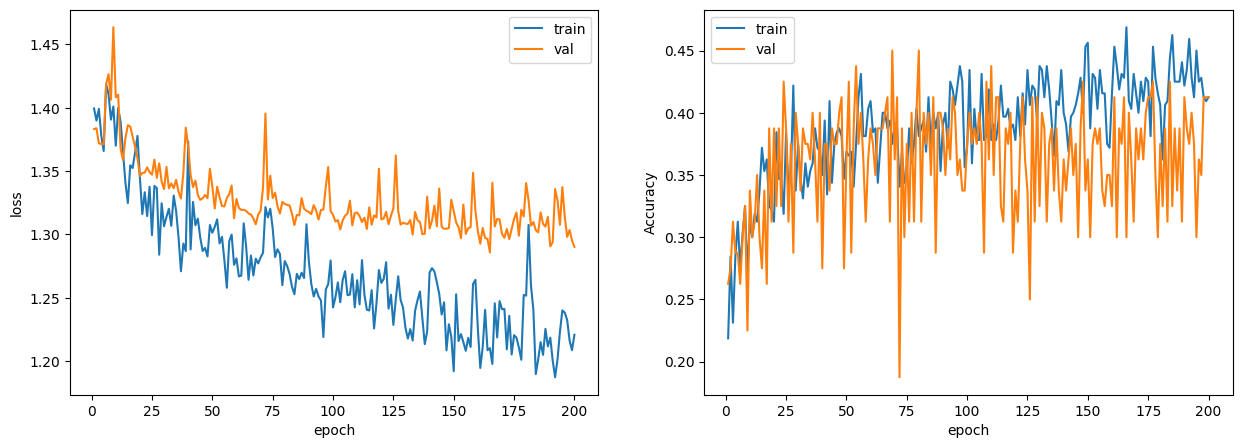

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
teset_dataset = TensorDataset(torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

test_loader = DataLoader(teset_dataset, batch_size=batch_size, shuffle=False)

preds = predict(model,test_loader)




Testing: 100%|██████████| 2/2 [00:00<00:00, 372.68it/s]


In [61]:
conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")


Accuracy: 0.49


## Попробуем добавить разные шедулеры

In [ ]:
num_epochs = 150

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/150: 100%|██████████| 2/2 [00:00<00:00, 483.13it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.3958009004592895, train acc: 0.265625
 val loss: 1.3854791879653932, val acc: 0.3



Validating epoch 2/150: 100%|██████████| 2/2 [00:00<00:00, 430.38it/s]


Epoch 2
 train loss: 1.4247705221176148, train acc: 0.22187499701976776
 val loss: 1.3903757333755493, val acc: 0.275



Validating epoch 3/150: 100%|██████████| 2/2 [00:00<00:00, 501.59it/s]


Epoch 3
 train loss: 1.3971587419509888, train acc: 0.28125
 val loss: 1.3792622566223145, val acc: 0.2125



Validating epoch 4/150: 100%|██████████| 2/2 [00:00<00:00, 454.45it/s]


Epoch 4
 train loss: 1.3847023248672485, train acc: 0.31562501192092896
 val loss: 1.367300820350647, val acc: 0.3625



Validating epoch 5/150: 100%|██████████| 2/2 [00:00<00:00, 421.79it/s]


Epoch 5
 train loss: 1.3593915462493897, train acc: 0.32500001788139343
 val loss: 1.385198187828064, val acc: 0.2875



Validating epoch 6/150: 100%|██████████| 2/2 [00:00<00:00, 287.43it/s]


Epoch 6
 train loss: 1.3863300800323486, train acc: 0.3031249940395355
 val loss: 1.3643946409225465, val acc: 0.3625



Validating epoch 7/150: 100%|██████████| 2/2 [00:00<00:00, 417.53it/s]


Epoch 7
 train loss: 1.3715885162353516, train acc: 0.3125
 val loss: 1.3784895658493042, val acc: 0.3625



Validating epoch 8/150: 100%|██████████| 2/2 [00:00<00:00, 435.18it/s]


Epoch 8
 train loss: 1.3953253269195556, train acc: 0.2750000059604645
 val loss: 1.422275185585022, val acc: 0.275



Validating epoch 9/150: 100%|██████████| 2/2 [00:00<00:00, 503.31it/s]


Epoch 9
 train loss: 1.419027328491211, train acc: 0.28437501192092896
 val loss: 1.383904504776001, val acc: 0.3



Validating epoch 10/150: 100%|██████████| 2/2 [00:00<00:00, 447.46it/s]


Epoch 10
 train loss: 1.3755733728408814, train acc: 0.34062501788139343
 val loss: 1.4133628845214843, val acc: 0.3375



Validating epoch 11/150: 100%|██████████| 2/2 [00:00<00:00, 369.92it/s]


Epoch 11
 train loss: 1.3808390855789185, train acc: 0.3218750059604645
 val loss: 1.4118994235992433, val acc: 0.25



Validating epoch 12/150: 100%|██████████| 2/2 [00:00<00:00, 378.65it/s]


Epoch 12
 train loss: 1.3781068086624146, train acc: 0.31562501192092896
 val loss: 1.3516887187957765, val acc: 0.3375



Validating epoch 13/150: 100%|██████████| 2/2 [00:00<00:00, 389.12it/s]


Epoch 13
 train loss: 1.3472219705581665, train acc: 0.34375
 val loss: 1.3496604204177856, val acc: 0.375



Validating epoch 14/150: 100%|██████████| 2/2 [00:00<00:00, 479.71it/s]


Epoch 14
 train loss: 1.3752026557922363, train acc: 0.328125
 val loss: 1.374312663078308, val acc: 0.275



Validating epoch 15/150: 100%|██████████| 2/2 [00:00<00:00, 403.43it/s]


Epoch 15
 train loss: 1.3953462362289428, train acc: 0.3218750059604645
 val loss: 1.4348140716552735, val acc: 0.35



Validating epoch 16/150: 100%|██████████| 2/2 [00:00<00:00, 455.11it/s]


Epoch 16
 train loss: 1.4527216672897338, train acc: 0.28125
 val loss: 1.4708776950836182, val acc: 0.225



Validating epoch 17/150: 100%|██████████| 2/2 [00:00<00:00, 406.66it/s]


Epoch 17
 train loss: 1.39585223197937, train acc: 0.27812501788139343
 val loss: 1.385050392150879, val acc: 0.4125



Validating epoch 18/150: 100%|██████████| 2/2 [00:00<00:00, 465.75it/s]


Epoch 18
 train loss: 1.3491700649261475, train acc: 0.31562501192092896
 val loss: 1.3526241064071656, val acc: 0.3125



Validating epoch 19/150: 100%|██████████| 2/2 [00:00<00:00, 442.27it/s]


Epoch 19
 train loss: 1.338443398475647, train acc: 0.3499999940395355
 val loss: 1.3510754823684692, val acc: 0.4



Validating epoch 20/150: 100%|██████████| 2/2 [00:00<00:00, 397.34it/s]


Epoch 20
 train loss: 1.3142518758773805, train acc: 0.3531250059604645
 val loss: 1.3528284549713134, val acc: 0.3375



Validating epoch 21/150: 100%|██████████| 2/2 [00:00<00:00, 442.41it/s]


Epoch 21
 train loss: 1.3320463180541993, train acc: 0.31562501192092896
 val loss: 1.3501631021499634, val acc: 0.375



Validating epoch 22/150: 100%|██████████| 2/2 [00:00<00:00, 410.04it/s]


Epoch 22
 train loss: 1.329537320137024, train acc: 0.3499999940395355
 val loss: 1.3532386302947998, val acc: 0.375



Validating epoch 23/150: 100%|██████████| 2/2 [00:00<00:00, 407.87it/s]


Epoch 23
 train loss: 1.3176766157150268, train acc: 0.32500001788139343
 val loss: 1.349685263633728, val acc: 0.3125



Validating epoch 24/150: 100%|██████████| 2/2 [00:00<00:00, 448.56it/s]


Epoch 24
 train loss: 1.3349579334259034, train acc: 0.3031249940395355
 val loss: 1.346584153175354, val acc: 0.3125



Validating epoch 25/150: 100%|██████████| 2/2 [00:00<00:00, 487.12it/s]


Epoch 25
 train loss: 1.3202691555023194, train acc: 0.37187501788139343
 val loss: 1.3454710721969605, val acc: 0.3875



Validating epoch 26/150: 100%|██████████| 2/2 [00:00<00:00, 460.26it/s]


Epoch 26
 train loss: 1.3469033718109131, train acc: 0.34687501192092896
 val loss: 1.3466854333877563, val acc: 0.35



Validating epoch 27/150: 100%|██████████| 2/2 [00:00<00:00, 337.75it/s]


Epoch 27
 train loss: 1.3224415063858033, train acc: 0.34687501192092896
 val loss: 1.3530073642730713, val acc: 0.35



Validating epoch 28/150: 100%|██████████| 2/2 [00:00<00:00, 422.37it/s]


Epoch 28
 train loss: 1.3063278436660766, train acc: 0.40312501788139343
 val loss: 1.3586639642715455, val acc: 0.3375



Validating epoch 29/150: 100%|██████████| 2/2 [00:00<00:00, 388.33it/s]


Epoch 29
 train loss: 1.3060219764709473, train acc: 0.37187501788139343
 val loss: 1.347544002532959, val acc: 0.325



Validating epoch 30/150: 100%|██████████| 2/2 [00:00<00:00, 395.00it/s]


Epoch 30
 train loss: 1.2970064878463745, train acc: 0.38750001788139343
 val loss: 1.348655605316162, val acc: 0.3625



Validating epoch 31/150: 100%|██████████| 2/2 [00:00<00:00, 421.41it/s]


Epoch 31
 train loss: 1.2941635608673097, train acc: 0.3968749940395355
 val loss: 1.3398056983947755, val acc: 0.3375



Validating epoch 32/150: 100%|██████████| 2/2 [00:00<00:00, 432.76it/s]


Epoch 32
 train loss: 1.315248465538025, train acc: 0.33125001192092896
 val loss: 1.3370128870010376, val acc: 0.3625



Validating epoch 33/150: 100%|██████████| 2/2 [00:00<00:00, 436.52it/s]


Epoch 33
 train loss: 1.3157052516937255, train acc: 0.3531250059604645
 val loss: 1.3352646350860595, val acc: 0.4375



Validating epoch 34/150: 100%|██████████| 2/2 [00:00<00:00, 407.89it/s]


Epoch 34
 train loss: 1.2763471364974976, train acc: 0.3968749940395355
 val loss: 1.3411409378051757, val acc: 0.3625



Validating epoch 35/150: 100%|██████████| 2/2 [00:00<00:00, 385.52it/s]


Epoch 35
 train loss: 1.307825231552124, train acc: 0.34375
 val loss: 1.3359327793121338, val acc: 0.3875



Validating epoch 36/150: 100%|██████████| 2/2 [00:00<00:00, 425.75it/s]


Epoch 36
 train loss: 1.3059032440185547, train acc: 0.38750001788139343
 val loss: 1.348466730117798, val acc: 0.3125



Validating epoch 37/150: 100%|██████████| 2/2 [00:00<00:00, 467.18it/s]


Epoch 37
 train loss: 1.3068503141403198, train acc: 0.390625
 val loss: 1.3333747863769532, val acc: 0.4



Validating epoch 38/150: 100%|██████████| 2/2 [00:00<00:00, 397.09it/s]


Epoch 38
 train loss: 1.2960417509078979, train acc: 0.38750001788139343
 val loss: 1.3446836471557617, val acc: 0.3



Validating epoch 39/150: 100%|██████████| 2/2 [00:00<00:00, 423.73it/s]


Epoch 39
 train loss: 1.3186257123947143, train acc: 0.36250001192092896
 val loss: 1.3522765159606933, val acc: 0.375



Validating epoch 40/150: 100%|██████████| 2/2 [00:00<00:00, 245.60it/s]


Epoch 40
 train loss: 1.2989959716796875, train acc: 0.375
 val loss: 1.336507749557495, val acc: 0.3875



Validating epoch 41/150: 100%|██████████| 2/2 [00:00<00:00, 415.71it/s]


Epoch 41
 train loss: 1.2982284784317017, train acc: 0.38750001788139343
 val loss: 1.328852939605713, val acc: 0.3625



Validating epoch 42/150: 100%|██████████| 2/2 [00:00<00:00, 443.44it/s]


Epoch 42
 train loss: 1.3103809595108031, train acc: 0.32500001788139343
 val loss: 1.3278427600860596, val acc: 0.3875



Validating epoch 43/150: 100%|██████████| 2/2 [00:00<00:00, 461.42it/s]


Epoch 43
 train loss: 1.3244195461273194, train acc: 0.3687500059604645
 val loss: 1.3386294841766357, val acc: 0.3125



Validating epoch 44/150: 100%|██████████| 2/2 [00:00<00:00, 392.23it/s]


Epoch 44
 train loss: 1.291721773147583, train acc: 0.36250001192092896
 val loss: 1.3402246475219726, val acc: 0.375



Validating epoch 45/150: 100%|██████████| 2/2 [00:00<00:00, 359.69it/s]


Epoch 45
 train loss: 1.310059142112732, train acc: 0.3499999940395355
 val loss: 1.3352551937103272, val acc: 0.3625



Validating epoch 46/150: 100%|██████████| 2/2 [00:00<00:00, 330.17it/s]


Epoch 46
 train loss: 1.2761082410812379, train acc: 0.3812499940395355
 val loss: 1.327298927307129, val acc: 0.4



Validating epoch 47/150: 100%|██████████| 2/2 [00:00<00:00, 394.16it/s]


Epoch 47
 train loss: 1.3010645627975463, train acc: 0.3843750059604645
 val loss: 1.3325176954269409, val acc: 0.3625



Validating epoch 48/150: 100%|██████████| 2/2 [00:00<00:00, 540.89it/s]


Epoch 48
 train loss: 1.2683897256851195, train acc: 0.3843750059604645
 val loss: 1.3287965774536132, val acc: 0.375



Validating epoch 49/150: 100%|██████████| 2/2 [00:00<00:00, 375.50it/s]


Epoch 49
 train loss: 1.3122320413589477, train acc: 0.375
 val loss: 1.3272099494934082, val acc: 0.3875



Validating epoch 50/150: 100%|██████████| 2/2 [00:00<00:00, 440.42it/s]


Epoch 50
 train loss: 1.320428204536438, train acc: 0.33125001192092896
 val loss: 1.3274928331375122, val acc: 0.3625



Validating epoch 51/150: 100%|██████████| 2/2 [00:00<00:00, 358.72it/s]


Epoch 51
 train loss: 1.3260093212127686, train acc: 0.34062501788139343
 val loss: 1.3298123359680176, val acc: 0.3875



Validating epoch 52/150: 100%|██████████| 2/2 [00:00<00:00, 343.64it/s]


Epoch 52
 train loss: 1.2899752378463745, train acc: 0.37187501788139343
 val loss: 1.3484467267990112, val acc: 0.375



Validating epoch 53/150: 100%|██████████| 2/2 [00:00<00:00, 489.59it/s]


Epoch 53
 train loss: 1.3188259840011596, train acc: 0.359375
 val loss: 1.3311668395996095, val acc: 0.325



Validating epoch 54/150: 100%|██████████| 2/2 [00:00<00:00, 364.44it/s]


Epoch 54
 train loss: 1.32024347782135, train acc: 0.34375
 val loss: 1.3355692386627198, val acc: 0.3375



Validating epoch 55/150: 100%|██████████| 2/2 [00:00<00:00, 432.02it/s]


Epoch 55
 train loss: 1.325508451461792, train acc: 0.3656249940395355
 val loss: 1.3373212099075318, val acc: 0.3



Validating epoch 56/150: 100%|██████████| 2/2 [00:00<00:00, 487.45it/s]


Epoch 56
 train loss: 1.2789741516113282, train acc: 0.37187501788139343
 val loss: 1.34464590549469, val acc: 0.4



Validating epoch 57/150: 100%|██████████| 2/2 [00:00<00:00, 373.79it/s]


Epoch 57
 train loss: 1.295502734184265, train acc: 0.37812501192092896
 val loss: 1.32722327709198, val acc: 0.425



Validating epoch 58/150: 100%|██████████| 2/2 [00:00<00:00, 423.00it/s]


Epoch 58
 train loss: 1.293360996246338, train acc: 0.3843750059604645
 val loss: 1.3244758129119873, val acc: 0.325



Validating epoch 59/150: 100%|██████████| 2/2 [00:00<00:00, 505.64it/s]


Epoch 59
 train loss: 1.2644371271133423, train acc: 0.40312501788139343
 val loss: 1.3238113641738891, val acc: 0.425



Validating epoch 60/150: 100%|██████████| 2/2 [00:00<00:00, 502.64it/s]


Epoch 60
 train loss: 1.2834237337112426, train acc: 0.390625
 val loss: 1.3256993293762207, val acc: 0.3375



Validating epoch 61/150: 100%|██████████| 2/2 [00:00<00:00, 395.65it/s]


Epoch 61
 train loss: 1.2773965835571288, train acc: 0.34687501192092896
 val loss: 1.316085433959961, val acc: 0.4



Validating epoch 62/150: 100%|██████████| 2/2 [00:00<00:00, 404.78it/s]


Epoch 62
 train loss: 1.2851776599884033, train acc: 0.3656249940395355
 val loss: 1.3178572177886962, val acc: 0.3875



Validating epoch 63/150: 100%|██████████| 2/2 [00:00<00:00, 441.16it/s]


Epoch 63
 train loss: 1.272974181175232, train acc: 0.390625
 val loss: 1.3206996202468873, val acc: 0.3625



Validating epoch 64/150: 100%|██████████| 2/2 [00:00<00:00, 435.57it/s]


Epoch 64
 train loss: 1.288370180130005, train acc: 0.36250001192092896
 val loss: 1.3210627555847168, val acc: 0.3875



Validating epoch 65/150: 100%|██████████| 2/2 [00:00<00:00, 359.76it/s]


Epoch 65
 train loss: 1.2663219928741456, train acc: 0.3687500059604645
 val loss: 1.315423035621643, val acc: 0.375



Validating epoch 66/150: 100%|██████████| 2/2 [00:00<00:00, 520.32it/s]


Epoch 66
 train loss: 1.2968230247497559, train acc: 0.37812501192092896
 val loss: 1.3199411392211915, val acc: 0.325



Validating epoch 67/150: 100%|██████████| 2/2 [00:00<00:00, 391.79it/s]


Epoch 67
 train loss: 1.2778815746307373, train acc: 0.375
 val loss: 1.3156688451766967, val acc: 0.375



Validating epoch 68/150: 100%|██████████| 2/2 [00:00<00:00, 407.25it/s]


Epoch 68
 train loss: 1.22348210811615, train acc: 0.42500001192092896
 val loss: 1.3151046991348267, val acc: 0.325



Validating epoch 69/150: 100%|██████████| 2/2 [00:00<00:00, 410.64it/s]


Epoch 69
 train loss: 1.281769609451294, train acc: 0.39375001192092896
 val loss: 1.3121851444244386, val acc: 0.3875



Validating epoch 70/150: 100%|██████████| 2/2 [00:00<00:00, 414.05it/s]


Epoch 70
 train loss: 1.2733048915863037, train acc: 0.37812501192092896
 val loss: 1.3357914447784425, val acc: 0.3375



Validating epoch 71/150: 100%|██████████| 2/2 [00:00<00:00, 430.21it/s]


Epoch 71
 train loss: 1.288363242149353, train acc: 0.4156250059604645
 val loss: 1.317663836479187, val acc: 0.4125



Validating epoch 72/150: 100%|██████████| 2/2 [00:00<00:00, 456.42it/s]


Epoch 72
 train loss: 1.2615070581436156, train acc: 0.3687500059604645
 val loss: 1.3174826860427857, val acc: 0.3125



Validating epoch 73/150: 100%|██████████| 2/2 [00:00<00:00, 328.94it/s]


Epoch 73
 train loss: 1.2614944696426391, train acc: 0.39375001192092896
 val loss: 1.3104507207870484, val acc: 0.3875



Validating epoch 74/150: 100%|██████████| 2/2 [00:00<00:00, 412.91it/s]


Epoch 74
 train loss: 1.2582622051239014, train acc: 0.39375001192092896
 val loss: 1.3093627214431762, val acc: 0.3625



Validating epoch 75/150: 100%|██████████| 2/2 [00:00<00:00, 398.02it/s]


Epoch 75
 train loss: 1.260434341430664, train acc: 0.35625001788139343
 val loss: 1.3107780933380127, val acc: 0.3625



Validating epoch 76/150: 100%|██████████| 2/2 [00:00<00:00, 376.26it/s]


Epoch 76
 train loss: 1.2848094701766968, train acc: 0.375
 val loss: 1.3140292167663574, val acc: 0.3875



Validating epoch 77/150: 100%|██████████| 2/2 [00:00<00:00, 437.34it/s]


Epoch 77
 train loss: 1.2434842109680175, train acc: 0.4000000059604645
 val loss: 1.3149907827377318, val acc: 0.3625



Validating epoch 78/150: 100%|██████████| 2/2 [00:00<00:00, 434.67it/s]


Epoch 78
 train loss: 1.265371608734131, train acc: 0.390625
 val loss: 1.3129775524139404, val acc: 0.3875



Validating epoch 79/150: 100%|██████████| 2/2 [00:00<00:00, 443.49it/s]


Epoch 79
 train loss: 1.3081740140914917, train acc: 0.3499999940395355
 val loss: 1.3224981069564818, val acc: 0.4



Validating epoch 80/150: 100%|██████████| 2/2 [00:00<00:00, 358.37it/s]


Epoch 80
 train loss: 1.2572811603546143, train acc: 0.4156250059604645
 val loss: 1.3346145629882813, val acc: 0.35



Validating epoch 81/150: 100%|██████████| 2/2 [00:00<00:00, 359.39it/s]


Epoch 81
 train loss: 1.2616149663925171, train acc: 0.38750001788139343
 val loss: 1.355314064025879, val acc: 0.3125



Validating epoch 82/150: 100%|██████████| 2/2 [00:00<00:00, 415.32it/s]


Epoch 82
 train loss: 1.312121295928955, train acc: 0.37187501788139343
 val loss: 1.3360645771026611, val acc: 0.375



Validating epoch 83/150: 100%|██████████| 2/2 [00:00<00:00, 385.90it/s]


Epoch 83
 train loss: 1.2984806537628173, train acc: 0.3812499940395355
 val loss: 1.3200707674026488, val acc: 0.35



Validating epoch 84/150: 100%|██████████| 2/2 [00:00<00:00, 439.77it/s]


Epoch 84
 train loss: 1.2445252895355225, train acc: 0.40937501192092896
 val loss: 1.3120343685150146, val acc: 0.3875



Validating epoch 85/150: 100%|██████████| 2/2 [00:00<00:00, 424.03it/s]


Epoch 85
 train loss: 1.2775738477706908, train acc: 0.359375
 val loss: 1.3165185689926147, val acc: 0.4125



Validating epoch 86/150: 100%|██████████| 2/2 [00:00<00:00, 442.32it/s]


Epoch 86
 train loss: 1.2688934564590455, train acc: 0.3812499940395355
 val loss: 1.3257801055908203, val acc: 0.35



Validating epoch 87/150: 100%|██████████| 2/2 [00:00<00:00, 390.17it/s]


Epoch 87
 train loss: 1.2759046316146851, train acc: 0.375
 val loss: 1.3347140550613403, val acc: 0.4



Validating epoch 88/150: 100%|██████████| 2/2 [00:00<00:00, 352.86it/s]


Epoch 88
 train loss: 1.257707166671753, train acc: 0.4000000059604645
 val loss: 1.3197898626327516, val acc: 0.3375



Validating epoch 89/150: 100%|██████████| 2/2 [00:00<00:00, 421.98it/s]


Epoch 89
 train loss: 1.2754228353500365, train acc: 0.3531250059604645
 val loss: 1.3112381935119628, val acc: 0.375



Validating epoch 90/150: 100%|██████████| 2/2 [00:00<00:00, 437.50it/s]


Epoch 90
 train loss: 1.2483155965805053, train acc: 0.421875
 val loss: 1.3162128686904908, val acc: 0.375



Validating epoch 91/150: 100%|██████████| 2/2 [00:00<00:00, 425.06it/s]


Epoch 91
 train loss: 1.2310279607772827, train acc: 0.4312500059604645
 val loss: 1.3102064371109008, val acc: 0.3875



Validating epoch 92/150: 100%|██████████| 2/2 [00:00<00:00, 401.14it/s]


Epoch 92
 train loss: 1.2391345739364623, train acc: 0.4000000059604645
 val loss: 1.317819857597351, val acc: 0.3125



Validating epoch 93/150: 100%|██████████| 2/2 [00:00<00:00, 413.25it/s]


Epoch 93
 train loss: 1.2517328262329102, train acc: 0.390625
 val loss: 1.3074210166931153, val acc: 0.375



Validating epoch 94/150: 100%|██████████| 2/2 [00:00<00:00, 357.88it/s]


Epoch 94
 train loss: 1.2847192287445068, train acc: 0.3531250059604645
 val loss: 1.3092591285705566, val acc: 0.375



Validating epoch 95/150: 100%|██████████| 2/2 [00:00<00:00, 368.60it/s]


Epoch 95
 train loss: 1.240885043144226, train acc: 0.39375001192092896
 val loss: 1.3122002363204956, val acc: 0.3875



Validating epoch 96/150: 100%|██████████| 2/2 [00:00<00:00, 285.92it/s]


Epoch 96
 train loss: 1.2431811094284058, train acc: 0.4124999940395355
 val loss: 1.318574595451355, val acc: 0.3125



Validating epoch 97/150: 100%|██████████| 2/2 [00:00<00:00, 354.05it/s]


Epoch 97
 train loss: 1.3012680053710937, train acc: 0.33125001192092896
 val loss: 1.3149290561676026, val acc: 0.425



Validating epoch 98/150: 100%|██████████| 2/2 [00:00<00:00, 315.15it/s]


Epoch 98
 train loss: 1.2477915048599244, train acc: 0.3812499940395355
 val loss: 1.3288513660430907, val acc: 0.4125



Validating epoch 99/150: 100%|██████████| 2/2 [00:00<00:00, 235.39it/s]


Epoch 99
 train loss: 1.3069337368011475, train acc: 0.3499999940395355
 val loss: 1.3253791570663451, val acc: 0.35



Validating epoch 100/150: 100%|██████████| 2/2 [00:00<00:00, 388.15it/s]


Epoch 100
 train loss: 1.276433491706848, train acc: 0.3687500059604645
 val loss: 1.320009708404541, val acc: 0.3875



Validating epoch 101/150: 100%|██████████| 2/2 [00:00<00:00, 438.67it/s]


Epoch 101
 train loss: 1.2365004777908326, train acc: 0.390625
 val loss: 1.3125107765197754, val acc: 0.35



Validating epoch 102/150: 100%|██████████| 2/2 [00:00<00:00, 432.00it/s]


Epoch 102
 train loss: 1.2655490159988403, train acc: 0.40312501788139343
 val loss: 1.328137183189392, val acc: 0.225



Validating epoch 103/150: 100%|██████████| 2/2 [00:00<00:00, 430.69it/s]


Epoch 103
 train loss: 1.2718624353408814, train acc: 0.38750001788139343
 val loss: 1.314898681640625, val acc: 0.4375



Validating epoch 104/150: 100%|██████████| 2/2 [00:00<00:00, 414.76it/s]


Epoch 104
 train loss: 1.2668617010116576, train acc: 0.4124999940395355
 val loss: 1.3351988792419434, val acc: 0.35



Validating epoch 105/150: 100%|██████████| 2/2 [00:00<00:00, 433.86it/s]


Epoch 105
 train loss: 1.2719640016555787, train acc: 0.4000000059604645
 val loss: 1.3383307695388793, val acc: 0.4



Validating epoch 106/150: 100%|██████████| 2/2 [00:00<00:00, 435.82it/s]


Epoch 106
 train loss: 1.2713298082351685, train acc: 0.3843750059604645
 val loss: 1.332323169708252, val acc: 0.3375



Validating epoch 107/150: 100%|██████████| 2/2 [00:00<00:00, 406.19it/s]


Epoch 107
 train loss: 1.2685208797454834, train acc: 0.3656249940395355
 val loss: 1.316910696029663, val acc: 0.4125



Validating epoch 108/150: 100%|██████████| 2/2 [00:00<00:00, 412.78it/s]


Epoch 108
 train loss: 1.24155912399292, train acc: 0.359375
 val loss: 1.3168148756027223, val acc: 0.4125



Validating epoch 109/150: 100%|██████████| 2/2 [00:00<00:00, 229.81it/s]


Epoch 109
 train loss: 1.2772725343704223, train acc: 0.35625001788139343
 val loss: 1.307941198348999, val acc: 0.4



Validating epoch 110/150: 100%|██████████| 2/2 [00:00<00:00, 308.52it/s]


Epoch 110
 train loss: 1.2466643571853637, train acc: 0.4000000059604645
 val loss: 1.3104227781295776, val acc: 0.3875



Validating epoch 111/150: 100%|██████████| 2/2 [00:00<00:00, 419.75it/s]


Epoch 111
 train loss: 1.2517429828643798, train acc: 0.3687500059604645
 val loss: 1.3060115575790405, val acc: 0.425



Validating epoch 112/150: 100%|██████████| 2/2 [00:00<00:00, 405.97it/s]


Epoch 112
 train loss: 1.2302509546279907, train acc: 0.4437499940395355
 val loss: 1.307734203338623, val acc: 0.3375



Validating epoch 113/150: 100%|██████████| 2/2 [00:00<00:00, 479.05it/s]


Epoch 113
 train loss: 1.2287609577178955, train acc: 0.45000001788139343
 val loss: 1.3172426223754883, val acc: 0.35



Validating epoch 114/150: 100%|██████████| 2/2 [00:00<00:00, 440.19it/s]


Epoch 114
 train loss: 1.233049178123474, train acc: 0.421875
 val loss: 1.309710645675659, val acc: 0.375



Validating epoch 115/150: 100%|██████████| 2/2 [00:00<00:00, 391.00it/s]


Epoch 115
 train loss: 1.2500904083251954, train acc: 0.40312501788139343
 val loss: 1.3074049711227418, val acc: 0.3125



Validating epoch 116/150: 100%|██████████| 2/2 [00:00<00:00, 439.52it/s]


Epoch 116
 train loss: 1.2411131620407105, train acc: 0.40312501788139343
 val loss: 1.3095618724822997, val acc: 0.3375



Validating epoch 117/150: 100%|██████████| 2/2 [00:00<00:00, 390.80it/s]


Epoch 117
 train loss: 1.239114761352539, train acc: 0.421875
 val loss: 1.3078655481338501, val acc: 0.3625



Validating epoch 118/150: 100%|██████████| 2/2 [00:00<00:00, 356.81it/s]


Epoch 118
 train loss: 1.2355323791503907, train acc: 0.421875
 val loss: 1.3066256523132325, val acc: 0.35



Validating epoch 119/150: 100%|██████████| 2/2 [00:00<00:00, 298.96it/s]


Epoch 119
 train loss: 1.2534528255462647, train acc: 0.421875
 val loss: 1.3263622522354126, val acc: 0.3



Validating epoch 120/150: 100%|██████████| 2/2 [00:00<00:00, 313.73it/s]


Epoch 120
 train loss: 1.2796258687973023, train acc: 0.3812499940395355
 val loss: 1.3134549140930176, val acc: 0.4125



Validating epoch 121/150: 100%|██████████| 2/2 [00:00<00:00, 279.25it/s]


Epoch 121
 train loss: 1.2705002069473266, train acc: 0.4000000059604645
 val loss: 1.309793186187744, val acc: 0.3875



Validating epoch 122/150: 100%|██████████| 2/2 [00:00<00:00, 391.53it/s]


Epoch 122
 train loss: 1.260151219367981, train acc: 0.38750001788139343
 val loss: 1.313592791557312, val acc: 0.3875



Validating epoch 123/150: 100%|██████████| 2/2 [00:00<00:00, 399.67it/s]


Epoch 123
 train loss: 1.2467341423034668, train acc: 0.39375001192092896
 val loss: 1.3101366758346558, val acc: 0.4125



Validating epoch 124/150: 100%|██████████| 2/2 [00:00<00:00, 385.77it/s]


Epoch 124
 train loss: 1.2484128713607787, train acc: 0.4124999940395355
 val loss: 1.3101300239562987, val acc: 0.3875



Validating epoch 125/150: 100%|██████████| 2/2 [00:00<00:00, 412.07it/s]


Epoch 125
 train loss: 1.2547593593597413, train acc: 0.3656249940395355
 val loss: 1.3146172523498536, val acc: 0.3875



Validating epoch 126/150: 100%|██████████| 2/2 [00:00<00:00, 441.32it/s]


Epoch 126
 train loss: 1.2366440296173096, train acc: 0.42500001192092896
 val loss: 1.3065598964691163, val acc: 0.3125



Validating epoch 127/150: 100%|██████████| 2/2 [00:00<00:00, 384.22it/s]


Epoch 127
 train loss: 1.2482118129730224, train acc: 0.4000000059604645
 val loss: 1.301837182044983, val acc: 0.325



Validating epoch 128/150: 100%|██████████| 2/2 [00:00<00:00, 472.30it/s]


Epoch 128
 train loss: 1.2427289247512818, train acc: 0.40312501788139343
 val loss: 1.327475905418396, val acc: 0.425



Validating epoch 129/150: 100%|██████████| 2/2 [00:00<00:00, 369.04it/s]


Epoch 129
 train loss: 1.273956561088562, train acc: 0.375
 val loss: 1.3469975233078002, val acc: 0.25



Validating epoch 130/150: 100%|██████████| 2/2 [00:00<00:00, 405.60it/s]


Epoch 130
 train loss: 1.2644277334213256, train acc: 0.39375001192092896
 val loss: 1.3110493659973144, val acc: 0.425



Validating epoch 131/150: 100%|██████████| 2/2 [00:00<00:00, 379.56it/s]


Epoch 131
 train loss: 1.261260747909546, train acc: 0.36250001192092896
 val loss: 1.3040803909301757, val acc: 0.3375



Validating epoch 132/150: 100%|██████████| 2/2 [00:00<00:00, 410.96it/s]


Epoch 132
 train loss: 1.2377713441848754, train acc: 0.4000000059604645
 val loss: 1.3043427228927613, val acc: 0.325



Validating epoch 133/150: 100%|██████████| 2/2 [00:00<00:00, 435.07it/s]


Epoch 133
 train loss: 1.2615085601806642, train acc: 0.40625
 val loss: 1.2990268468856812, val acc: 0.3875



Validating epoch 134/150: 100%|██████████| 2/2 [00:00<00:00, 355.04it/s]


Epoch 134
 train loss: 1.2647348642349243, train acc: 0.3968749940395355
 val loss: 1.3173203706741332, val acc: 0.2625



Validating epoch 135/150: 100%|██████████| 2/2 [00:00<00:00, 427.64it/s]


Epoch 135
 train loss: 1.2680316686630249, train acc: 0.3812499940395355
 val loss: 1.3108721494674682, val acc: 0.4



Validating epoch 136/150: 100%|██████████| 2/2 [00:00<00:00, 398.55it/s]


Epoch 136
 train loss: 1.2742462396621703, train acc: 0.39375001192092896
 val loss: 1.3205202102661133, val acc: 0.325



Validating epoch 137/150: 100%|██████████| 2/2 [00:00<00:00, 422.13it/s]


Epoch 137
 train loss: 1.2613758087158202, train acc: 0.40937501192092896
 val loss: 1.328015112876892, val acc: 0.425



Validating epoch 138/150: 100%|██████████| 2/2 [00:00<00:00, 425.13it/s]


Epoch 138
 train loss: 1.2499115943908692, train acc: 0.3812499940395355
 val loss: 1.3106119155883789, val acc: 0.3875



Validating epoch 139/150: 100%|██████████| 2/2 [00:00<00:00, 428.82it/s]


Epoch 139
 train loss: 1.2519027471542359, train acc: 0.359375
 val loss: 1.3177262544631958, val acc: 0.3875



Validating epoch 140/150: 100%|██████████| 2/2 [00:00<00:00, 410.80it/s]


Epoch 140
 train loss: 1.2211222887039184, train acc: 0.4281249940395355
 val loss: 1.3039058208465577, val acc: 0.4



Validating epoch 141/150: 100%|██████████| 2/2 [00:00<00:00, 433.54it/s]


Epoch 141
 train loss: 1.2187592267990113, train acc: 0.4375
 val loss: 1.2984320640563964, val acc: 0.4125



Validating epoch 142/150: 100%|██████████| 2/2 [00:00<00:00, 391.19it/s]


Epoch 142
 train loss: 1.2365101099014282, train acc: 0.40625
 val loss: 1.2986565828323364, val acc: 0.325



Validating epoch 143/150: 100%|██████████| 2/2 [00:00<00:00, 388.83it/s]


Epoch 143
 train loss: 1.2253271102905274, train acc: 0.4312500059604645
 val loss: 1.295482349395752, val acc: 0.4375



Validating epoch 144/150: 100%|██████████| 2/2 [00:00<00:00, 403.76it/s]


Epoch 144
 train loss: 1.225453782081604, train acc: 0.40625
 val loss: 1.3092798948287965, val acc: 0.4125



Validating epoch 145/150: 100%|██████████| 2/2 [00:00<00:00, 423.30it/s]


Epoch 145
 train loss: 1.2471081972122193, train acc: 0.41875001788139343
 val loss: 1.316101574897766, val acc: 0.3625



Validating epoch 146/150: 100%|██████████| 2/2 [00:00<00:00, 417.80it/s]


Epoch 146
 train loss: 1.242784357070923, train acc: 0.38750001788139343
 val loss: 1.306889820098877, val acc: 0.4



Validating epoch 147/150: 100%|██████████| 2/2 [00:00<00:00, 417.76it/s]


Epoch 147
 train loss: 1.2216702461242677, train acc: 0.4156250059604645
 val loss: 1.3148349285125733, val acc: 0.3875



Validating epoch 148/150: 100%|██████████| 2/2 [00:00<00:00, 413.76it/s]


Epoch 148
 train loss: 1.2303716659545898, train acc: 0.4124999940395355
 val loss: 1.3092750310897827, val acc: 0.4125



Validating epoch 149/150: 100%|██████████| 2/2 [00:00<00:00, 402.68it/s]


Epoch 149
 train loss: 1.2616052389144898, train acc: 0.37812501192092896
 val loss: 1.3055455684661865, val acc: 0.375



Validating epoch 150/150: 100%|██████████| 2/2 [00:00<00:00, 348.52it/s]

Epoch 150
 train loss: 1.2461079359054565, train acc: 0.39375001192092896
 val loss: 1.304673171043396, val acc: 0.375



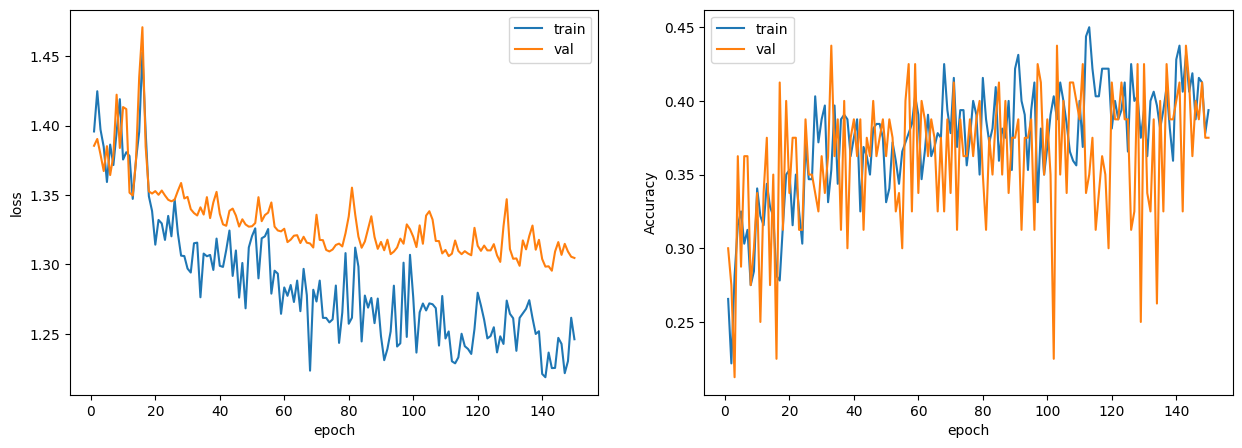

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:

preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 2/2 [00:00<00:00, 357.07it/s]


In [60]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")


Accuracy: 0.52


### Lambda LR

In [ ]:
num_epochs = 100

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/100: 100%|██████████| 2/2 [00:00<00:00, 162.10it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.3963998794555663, train acc: 0.2562499940395355
 val loss: 1.3896738052368165, val acc: 0.275



Validating epoch 2/100: 100%|██████████| 2/2 [00:00<00:00, 315.73it/s]


Epoch 2
 train loss: 1.389893937110901, train acc: 0.2750000059604645
 val loss: 1.3795921325683593, val acc: 0.275



Validating epoch 3/100: 100%|██████████| 2/2 [00:00<00:00, 244.29it/s]


Epoch 3
 train loss: 1.3969364166259766, train acc: 0.28437501192092896
 val loss: 1.3858207702636718, val acc: 0.3125



Validating epoch 4/100: 100%|██████████| 2/2 [00:00<00:00, 212.03it/s]


Epoch 4
 train loss: 1.3792068719863892, train acc: 0.2906250059604645
 val loss: 1.38092999458313, val acc: 0.2875



Validating epoch 5/100: 100%|██████████| 2/2 [00:00<00:00, 256.43it/s]


Epoch 5
 train loss: 1.3804275274276734, train acc: 0.24687500298023224
 val loss: 1.3712724208831788, val acc: 0.3



Validating epoch 6/100: 100%|██████████| 2/2 [00:00<00:00, 293.93it/s]


Epoch 6
 train loss: 1.371320128440857, train acc: 0.29375001788139343
 val loss: 1.365806245803833, val acc: 0.3625



Validating epoch 7/100: 100%|██████████| 2/2 [00:00<00:00, 194.43it/s]


Epoch 7
 train loss: 1.4160995483398438, train acc: 0.24062500894069672
 val loss: 1.3662155389785766, val acc: 0.325



Validating epoch 8/100: 100%|██████████| 2/2 [00:00<00:00, 160.10it/s]


Epoch 8
 train loss: 1.3795971870422363, train acc: 0.3031249940395355
 val loss: 1.3752185106277466, val acc: 0.3



Validating epoch 9/100: 100%|██████████| 2/2 [00:00<00:00, 267.28it/s]


Epoch 9
 train loss: 1.3679845809936524, train acc: 0.2750000059604645
 val loss: 1.3766378164291382, val acc: 0.3125



Validating epoch 10/100: 100%|██████████| 2/2 [00:00<00:00, 192.18it/s]


Epoch 10
 train loss: 1.3352795124053956, train acc: 0.33125001192092896
 val loss: 1.38828387260437, val acc: 0.3



Validating epoch 11/100: 100%|██████████| 2/2 [00:00<00:00, 333.24it/s]


Epoch 11
 train loss: 1.3550686597824098, train acc: 0.3187499940395355
 val loss: 1.369298791885376, val acc: 0.35



Validating epoch 12/100: 100%|██████████| 2/2 [00:00<00:00, 188.61it/s]


Epoch 12
 train loss: 1.3461135864257812, train acc: 0.29375001788139343
 val loss: 1.3696113586425782, val acc: 0.3375



Validating epoch 13/100: 100%|██████████| 2/2 [00:00<00:00, 137.59it/s]


Epoch 13
 train loss: 1.3398941278457641, train acc: 0.34375
 val loss: 1.3650031566619873, val acc: 0.2875



Validating epoch 14/100: 100%|██████████| 2/2 [00:00<00:00, 349.22it/s]


Epoch 14
 train loss: 1.346592617034912, train acc: 0.34687501192092896
 val loss: 1.3678308486938477, val acc: 0.2625



Validating epoch 15/100: 100%|██████████| 2/2 [00:00<00:00, 162.95it/s]


Epoch 15
 train loss: 1.3404690027236938, train acc: 0.34687501192092896
 val loss: 1.393796944618225, val acc: 0.35



Validating epoch 16/100: 100%|██████████| 2/2 [00:00<00:00, 234.40it/s]


Epoch 16
 train loss: 1.3455427646636964, train acc: 0.3343749940395355
 val loss: 1.4075690984725953, val acc: 0.2625



Validating epoch 17/100: 100%|██████████| 2/2 [00:00<00:00, 86.55it/s]


Epoch 17
 train loss: 1.3475217342376709, train acc: 0.30937501788139343
 val loss: 1.3876996994018556, val acc: 0.3875



Validating epoch 18/100: 100%|██████████| 2/2 [00:00<00:00, 119.05it/s]


Epoch 18
 train loss: 1.348648762702942, train acc: 0.34687501192092896
 val loss: 1.385180902481079, val acc: 0.2625



Validating epoch 19/100: 100%|██████████| 2/2 [00:00<00:00, 232.95it/s]


Epoch 19
 train loss: 1.3643084526062013, train acc: 0.3187499940395355
 val loss: 1.3939360618591308, val acc: 0.35



Validating epoch 20/100: 100%|██████████| 2/2 [00:00<00:00, 229.65it/s]


Epoch 20
 train loss: 1.3753304719924926, train acc: 0.3125
 val loss: 1.3674342155456543, val acc: 0.3



Validating epoch 21/100: 100%|██████████| 2/2 [00:00<00:00, 404.88it/s]


Epoch 21
 train loss: 1.3577417135238647, train acc: 0.3531250059604645
 val loss: 1.3704490184783935, val acc: 0.3



Validating epoch 22/100: 100%|██████████| 2/2 [00:00<00:00, 140.19it/s]


Epoch 22
 train loss: 1.3223537921905517, train acc: 0.34375
 val loss: 1.370284128189087, val acc: 0.375



Validating epoch 23/100: 100%|██████████| 2/2 [00:00<00:00, 209.47it/s]


Epoch 23
 train loss: 1.3394071340560914, train acc: 0.328125
 val loss: 1.358177614212036, val acc: 0.3375



Validating epoch 24/100: 100%|██████████| 2/2 [00:00<00:00, 161.44it/s]


Epoch 24
 train loss: 1.3343458414077758, train acc: 0.36250001192092896
 val loss: 1.3503161430358888, val acc: 0.3625



Validating epoch 25/100: 100%|██████████| 2/2 [00:00<00:00, 146.86it/s]


Epoch 25
 train loss: 1.3277315378189087, train acc: 0.3499999940395355
 val loss: 1.370008158683777, val acc: 0.3625



Validating epoch 26/100: 100%|██████████| 2/2 [00:00<00:00, 355.98it/s]


Epoch 26
 train loss: 1.3323715686798097, train acc: 0.34062501788139343
 val loss: 1.3835649728775024, val acc: 0.3375



Validating epoch 27/100: 100%|██████████| 2/2 [00:00<00:00, 345.20it/s]


Epoch 27
 train loss: 1.3336724519729615, train acc: 0.3343749940395355
 val loss: 1.3676405906677247, val acc: 0.3625



Validating epoch 28/100: 100%|██████████| 2/2 [00:00<00:00, 182.78it/s]


Epoch 28
 train loss: 1.317804718017578, train acc: 0.359375
 val loss: 1.3537458896636962, val acc: 0.4125



Validating epoch 29/100: 100%|██████████| 2/2 [00:00<00:00, 213.94it/s]


Epoch 29
 train loss: 1.3270193815231324, train acc: 0.3531250059604645
 val loss: 1.3680771589279175, val acc: 0.325



Validating epoch 30/100: 100%|██████████| 2/2 [00:00<00:00, 368.42it/s]


Epoch 30
 train loss: 1.30594322681427, train acc: 0.36250001192092896
 val loss: 1.3559390544891357, val acc: 0.4125



Validating epoch 31/100: 100%|██████████| 2/2 [00:00<00:00, 276.49it/s]


Epoch 31
 train loss: 1.3073683261871338, train acc: 0.359375
 val loss: 1.3457696914672852, val acc: 0.3625



Validating epoch 32/100: 100%|██████████| 2/2 [00:00<00:00, 161.72it/s]


Epoch 32
 train loss: 1.3423227787017822, train acc: 0.3531250059604645
 val loss: 1.3492944955825805, val acc: 0.35



Validating epoch 33/100: 100%|██████████| 2/2 [00:00<00:00, 139.91it/s]


Epoch 33
 train loss: 1.3290948390960693, train acc: 0.3687500059604645
 val loss: 1.348326849937439, val acc: 0.4



Validating epoch 34/100: 100%|██████████| 2/2 [00:00<00:00, 196.86it/s]


Epoch 34
 train loss: 1.3176000833511352, train acc: 0.359375
 val loss: 1.3660038232803344, val acc: 0.2875



Validating epoch 35/100: 100%|██████████| 2/2 [00:00<00:00, 226.14it/s]


Epoch 35
 train loss: 1.311880350112915, train acc: 0.34375
 val loss: 1.3479857921600342, val acc: 0.375



Validating epoch 36/100: 100%|██████████| 2/2 [00:00<00:00, 345.25it/s]


Epoch 36
 train loss: 1.326064944267273, train acc: 0.34062501788139343
 val loss: 1.3491011142730713, val acc: 0.275



Validating epoch 37/100: 100%|██████████| 2/2 [00:00<00:00, 142.56it/s]


Epoch 37
 train loss: 1.3167158365249634, train acc: 0.3687500059604645
 val loss: 1.3559656381607055, val acc: 0.375



Validating epoch 38/100: 100%|██████████| 2/2 [00:00<00:00, 318.24it/s]


Epoch 38
 train loss: 1.3437504768371582, train acc: 0.3343749940395355
 val loss: 1.3543320894241333, val acc: 0.2625



Validating epoch 39/100: 100%|██████████| 2/2 [00:00<00:00, 318.28it/s]


Epoch 39
 train loss: 1.2993541479110717, train acc: 0.3531250059604645
 val loss: 1.3423487663269043, val acc: 0.375



Validating epoch 40/100: 100%|██████████| 2/2 [00:00<00:00, 82.19it/s]


Epoch 40
 train loss: 1.2997104167938232, train acc: 0.3843750059604645
 val loss: 1.33289475440979, val acc: 0.3625



Validating epoch 41/100: 100%|██████████| 2/2 [00:00<00:00, 139.79it/s]


Epoch 41
 train loss: 1.2982442855834961, train acc: 0.3687500059604645
 val loss: 1.334472417831421, val acc: 0.4125



Validating epoch 42/100: 100%|██████████| 2/2 [00:00<00:00, 151.04it/s]


Epoch 42
 train loss: 1.3078040838241578, train acc: 0.36250001192092896
 val loss: 1.3377323150634766, val acc: 0.3625



Validating epoch 43/100: 100%|██████████| 2/2 [00:00<00:00, 169.42it/s]


Epoch 43
 train loss: 1.3052775144577027, train acc: 0.34687501192092896
 val loss: 1.3418907642364502, val acc: 0.3375



Validating epoch 44/100: 100%|██████████| 2/2 [00:00<00:00, 251.37it/s]


Epoch 44
 train loss: 1.2938278198242188, train acc: 0.375
 val loss: 1.342464542388916, val acc: 0.3625



Validating epoch 45/100: 100%|██████████| 2/2 [00:00<00:00, 196.18it/s]


Epoch 45
 train loss: 1.285348892211914, train acc: 0.3531250059604645
 val loss: 1.3309794664382935, val acc: 0.4375



Validating epoch 46/100: 100%|██████████| 2/2 [00:00<00:00, 295.09it/s]


Epoch 46
 train loss: 1.3068647623062133, train acc: 0.37187501788139343
 val loss: 1.3369692325592042, val acc: 0.3625



Validating epoch 47/100: 100%|██████████| 2/2 [00:00<00:00, 164.39it/s]


Epoch 47
 train loss: 1.3291717767715454, train acc: 0.35625001788139343
 val loss: 1.329747724533081, val acc: 0.3375



Validating epoch 48/100: 100%|██████████| 2/2 [00:00<00:00, 176.26it/s]


Epoch 48
 train loss: 1.2824039459228516, train acc: 0.3687500059604645
 val loss: 1.3326868534088134, val acc: 0.375



Validating epoch 49/100: 100%|██████████| 2/2 [00:00<00:00, 174.40it/s]


Epoch 49
 train loss: 1.2966333150863647, train acc: 0.375
 val loss: 1.324846911430359, val acc: 0.3875



Validating epoch 50/100: 100%|██████████| 2/2 [00:00<00:00, 145.73it/s]


Epoch 50
 train loss: 1.281912350654602, train acc: 0.38750001788139343
 val loss: 1.324005913734436, val acc: 0.3125



Validating epoch 51/100: 100%|██████████| 2/2 [00:00<00:00, 350.52it/s]


Epoch 51
 train loss: 1.2798052072525024, train acc: 0.3968749940395355
 val loss: 1.3274107933044434, val acc: 0.4



Validating epoch 52/100: 100%|██████████| 2/2 [00:00<00:00, 173.49it/s]


Epoch 52
 train loss: 1.282497262954712, train acc: 0.3843750059604645
 val loss: 1.329800534248352, val acc: 0.375



Validating epoch 53/100: 100%|██████████| 2/2 [00:00<00:00, 345.96it/s]


Epoch 53
 train loss: 1.3238762855529784, train acc: 0.34375
 val loss: 1.3282001256942748, val acc: 0.4



Validating epoch 54/100: 100%|██████████| 2/2 [00:00<00:00, 160.43it/s]


Epoch 54
 train loss: 1.3262030363082886, train acc: 0.35625001788139343
 val loss: 1.3296267986297607, val acc: 0.3625



Validating epoch 55/100: 100%|██████████| 2/2 [00:00<00:00, 300.76it/s]


Epoch 55
 train loss: 1.266923689842224, train acc: 0.3968749940395355
 val loss: 1.3319459199905395, val acc: 0.4125



Validating epoch 56/100: 100%|██████████| 2/2 [00:00<00:00, 289.91it/s]


Epoch 56
 train loss: 1.305279541015625, train acc: 0.375
 val loss: 1.337788987159729, val acc: 0.3125



Validating epoch 57/100: 100%|██████████| 2/2 [00:00<00:00, 373.46it/s]


Epoch 57
 train loss: 1.2685020208358764, train acc: 0.40312501788139343
 val loss: 1.3224453687667848, val acc: 0.4125



Validating epoch 58/100: 100%|██████████| 2/2 [00:00<00:00, 391.22it/s]


Epoch 58
 train loss: 1.2844112157821654, train acc: 0.3968749940395355
 val loss: 1.3282240152359008, val acc: 0.375



Validating epoch 59/100: 100%|██████████| 2/2 [00:00<00:00, 107.24it/s]


Epoch 59
 train loss: 1.2875543355941772, train acc: 0.3499999940395355
 val loss: 1.3223524808883667, val acc: 0.325



Validating epoch 60/100: 100%|██████████| 2/2 [00:00<00:00, 237.21it/s]


Epoch 60
 train loss: 1.278126335144043, train acc: 0.35625001788139343
 val loss: 1.3310699462890625, val acc: 0.325



Validating epoch 61/100: 100%|██████████| 2/2 [00:00<00:00, 208.85it/s]


Epoch 61
 train loss: 1.2969894647598266, train acc: 0.4000000059604645
 val loss: 1.3274604082107544, val acc: 0.425



Validating epoch 62/100: 100%|██████████| 2/2 [00:00<00:00, 219.82it/s]


Epoch 62
 train loss: 1.2888659238815308, train acc: 0.39375001192092896
 val loss: 1.328009009361267, val acc: 0.275



Validating epoch 63/100: 100%|██████████| 2/2 [00:00<00:00, 99.11it/s]


Epoch 63
 train loss: 1.30757315158844, train acc: 0.3531250059604645
 val loss: 1.3144047021865846, val acc: 0.375



Validating epoch 64/100: 100%|██████████| 2/2 [00:00<00:00, 426.79it/s]


Epoch 64
 train loss: 1.27169668674469, train acc: 0.35625001788139343
 val loss: 1.314133071899414, val acc: 0.4125



Validating epoch 65/100: 100%|██████████| 2/2 [00:00<00:00, 266.45it/s]


Epoch 65
 train loss: 1.262151575088501, train acc: 0.41875001788139343
 val loss: 1.3156319379806518, val acc: 0.35



Validating epoch 66/100: 100%|██████████| 2/2 [00:00<00:00, 259.76it/s]


Epoch 66
 train loss: 1.2672110557556153, train acc: 0.390625
 val loss: 1.316927719116211, val acc: 0.3875



Validating epoch 67/100: 100%|██████████| 2/2 [00:00<00:00, 173.35it/s]


Epoch 67
 train loss: 1.2800074100494385, train acc: 0.36250001192092896
 val loss: 1.3206442594528198, val acc: 0.375



Validating epoch 68/100: 100%|██████████| 2/2 [00:00<00:00, 419.83it/s]


Epoch 68
 train loss: 1.2633987188339233, train acc: 0.3968749940395355
 val loss: 1.3139220952987671, val acc: 0.4125



Validating epoch 69/100: 100%|██████████| 2/2 [00:00<00:00, 404.56it/s]


Epoch 69
 train loss: 1.2686889886856079, train acc: 0.40625
 val loss: 1.313066005706787, val acc: 0.375



Validating epoch 70/100: 100%|██████████| 2/2 [00:00<00:00, 58.10it/s]


Epoch 70
 train loss: 1.2645699024200439, train acc: 0.39375001192092896
 val loss: 1.3056812286376953, val acc: 0.375



Validating epoch 71/100: 100%|██████████| 2/2 [00:00<00:00, 106.07it/s]


Epoch 71
 train loss: 1.2794685125350953, train acc: 0.40625
 val loss: 1.3128779888153077, val acc: 0.3



Validating epoch 72/100: 100%|██████████| 2/2 [00:00<00:00, 105.52it/s]


Epoch 72
 train loss: 1.2608757734298706, train acc: 0.40312501788139343
 val loss: 1.3116163730621337, val acc: 0.4375



Validating epoch 73/100: 100%|██████████| 2/2 [00:00<00:00, 78.88it/s]


Epoch 73
 train loss: 1.2682440519332885, train acc: 0.3968749940395355
 val loss: 1.3409384727478026, val acc: 0.325



Validating epoch 74/100: 100%|██████████| 2/2 [00:00<00:00, 98.57it/s]


Epoch 74
 train loss: 1.2727368116378783, train acc: 0.4000000059604645
 val loss: 1.31186785697937, val acc: 0.4



Validating epoch 75/100: 100%|██████████| 2/2 [00:00<00:00, 373.84it/s]


Epoch 75
 train loss: 1.2826955318450928, train acc: 0.37812501192092896
 val loss: 1.3291285514831543, val acc: 0.2875



Validating epoch 76/100: 100%|██████████| 2/2 [00:00<00:00, 345.05it/s]


Epoch 76
 train loss: 1.295276165008545, train acc: 0.3968749940395355
 val loss: 1.3260942459106446, val acc: 0.4



Validating epoch 77/100: 100%|██████████| 2/2 [00:00<00:00, 390.97it/s]


Epoch 77
 train loss: 1.286649489402771, train acc: 0.375
 val loss: 1.3181621551513671, val acc: 0.35



Validating epoch 78/100: 100%|██████████| 2/2 [00:00<00:00, 304.66it/s]


Epoch 78
 train loss: 1.2893314123153687, train acc: 0.3687500059604645
 val loss: 1.3125314712524414, val acc: 0.3625



Validating epoch 79/100: 100%|██████████| 2/2 [00:00<00:00, 477.90it/s]


Epoch 79
 train loss: 1.2628697872161865, train acc: 0.375
 val loss: 1.307629942893982, val acc: 0.4125



Validating epoch 80/100: 100%|██████████| 2/2 [00:00<00:00, 413.48it/s]


Epoch 80
 train loss: 1.2875695705413819, train acc: 0.375
 val loss: 1.3166566371917725, val acc: 0.325



Validating epoch 81/100: 100%|██████████| 2/2 [00:00<00:00, 407.81it/s]


Epoch 81
 train loss: 1.2805213928222656, train acc: 0.35625001788139343
 val loss: 1.322676157951355, val acc: 0.4125



Validating epoch 82/100: 100%|██████████| 2/2 [00:00<00:00, 485.31it/s]


Epoch 82
 train loss: 1.26846182346344, train acc: 0.40312501788139343
 val loss: 1.3071130990982056, val acc: 0.3375



Validating epoch 83/100: 100%|██████████| 2/2 [00:00<00:00, 389.08it/s]


Epoch 83
 train loss: 1.2625818729400635, train acc: 0.3968749940395355
 val loss: 1.3165759086608886, val acc: 0.3125



Validating epoch 84/100: 100%|██████████| 2/2 [00:00<00:00, 420.88it/s]


Epoch 84
 train loss: 1.2534511089324951, train acc: 0.38750001788139343
 val loss: 1.3143528699874878, val acc: 0.4



Validating epoch 85/100: 100%|██████████| 2/2 [00:00<00:00, 403.47it/s]


Epoch 85
 train loss: 1.2487840890884399, train acc: 0.40937501192092896
 val loss: 1.3097664833068847, val acc: 0.325



Validating epoch 86/100: 100%|██████████| 2/2 [00:00<00:00, 394.65it/s]


Epoch 86
 train loss: 1.2593536376953125, train acc: 0.3812499940395355
 val loss: 1.303713822364807, val acc: 0.35



Validating epoch 87/100: 100%|██████████| 2/2 [00:00<00:00, 376.71it/s]


Epoch 87
 train loss: 1.265988254547119, train acc: 0.39375001192092896
 val loss: 1.322234606742859, val acc: 0.3375



Validating epoch 88/100: 100%|██████████| 2/2 [00:00<00:00, 372.86it/s]


Epoch 88
 train loss: 1.26535804271698, train acc: 0.4156250059604645
 val loss: 1.311475896835327, val acc: 0.4125



Validating epoch 89/100: 100%|██████████| 2/2 [00:00<00:00, 354.56it/s]


Epoch 89
 train loss: 1.2708048105239869, train acc: 0.42500001192092896
 val loss: 1.3150659084320069, val acc: 0.35



Validating epoch 90/100: 100%|██████████| 2/2 [00:00<00:00, 298.51it/s]


Epoch 90
 train loss: 1.2892609596252442, train acc: 0.37812501192092896
 val loss: 1.3089964389801025, val acc: 0.325



Validating epoch 91/100: 100%|██████████| 2/2 [00:00<00:00, 364.31it/s]


Epoch 91
 train loss: 1.2622004270553588, train acc: 0.4000000059604645
 val loss: 1.3039486885070801, val acc: 0.3875



Validating epoch 92/100: 100%|██████████| 2/2 [00:00<00:00, 441.78it/s]


Epoch 92
 train loss: 1.2420205116271972, train acc: 0.3968749940395355
 val loss: 1.3048636674880982, val acc: 0.3375



Validating epoch 93/100: 100%|██████████| 2/2 [00:00<00:00, 445.09it/s]


Epoch 93
 train loss: 1.2671190261840821, train acc: 0.390625
 val loss: 1.3046204805374146, val acc: 0.325



Validating epoch 94/100: 100%|██████████| 2/2 [00:00<00:00, 459.52it/s]


Epoch 94
 train loss: 1.2429033517837524, train acc: 0.40937501192092896
 val loss: 1.3009189367294312, val acc: 0.35



Validating epoch 95/100: 100%|██████████| 2/2 [00:00<00:00, 413.88it/s]


Epoch 95
 train loss: 1.2231048583984374, train acc: 0.4312500059604645
 val loss: 1.3061819553375245, val acc: 0.425



Validating epoch 96/100: 100%|██████████| 2/2 [00:00<00:00, 451.27it/s]


Epoch 96
 train loss: 1.247444224357605, train acc: 0.4124999940395355
 val loss: 1.3122865676879882, val acc: 0.35



Validating epoch 97/100: 100%|██████████| 2/2 [00:00<00:00, 427.68it/s]


Epoch 97
 train loss: 1.2462771892547608, train acc: 0.3968749940395355
 val loss: 1.3166144847869874, val acc: 0.45



Validating epoch 98/100: 100%|██████████| 2/2 [00:00<00:00, 427.08it/s]


Epoch 98
 train loss: 1.281843638420105, train acc: 0.36250001192092896
 val loss: 1.3359370946884155, val acc: 0.325



Validating epoch 99/100: 100%|██████████| 2/2 [00:00<00:00, 412.58it/s]


Epoch 99
 train loss: 1.2896350622177124, train acc: 0.40312501788139343
 val loss: 1.3112441301345825, val acc: 0.3625



Validating epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 401.52it/s]

Epoch 100
 train loss: 1.237229585647583, train acc: 0.4000000059604645
 val loss: 1.3079292535781861, val acc: 0.4



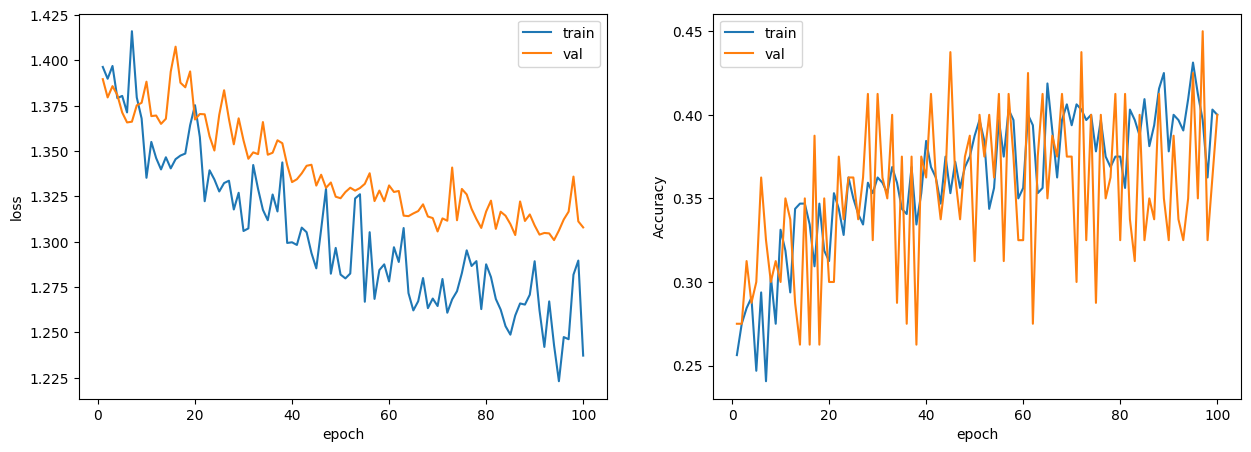

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:

preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



In [59]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")


Accuracy: 0.48


In [ ]:
num_epochs = 150

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)
lambda1 = lambda epoch: 0.67 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/150: 100%|██████████| 2/2 [00:00<00:00, 525.17it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.3991662740707398, train acc: 0.22187499701976776
 val loss: 1.3892608642578126, val acc: 0.2625



Validating epoch 2/150: 100%|██████████| 2/2 [00:00<00:00, 480.86it/s]


Epoch 2
 train loss: 1.3857215642929077, train acc: 0.3062500059604645
 val loss: 1.388070297241211, val acc: 0.2125



Validating epoch 3/150: 100%|██████████| 2/2 [00:00<00:00, 430.96it/s]


Epoch 3
 train loss: 1.4141744375228882, train acc: 0.22187499701976776
 val loss: 1.3903060674667358, val acc: 0.275



Validating epoch 4/150: 100%|██████████| 2/2 [00:00<00:00, 364.64it/s]


Epoch 4
 train loss: 1.40741708278656, train acc: 0.28125
 val loss: 1.3956509351730346, val acc: 0.2375



Validating epoch 5/150: 100%|██████████| 2/2 [00:00<00:00, 389.61it/s]


Epoch 5
 train loss: 1.409361481666565, train acc: 0.29375001788139343
 val loss: 1.3712273597717286, val acc: 0.35



Validating epoch 6/150: 100%|██████████| 2/2 [00:00<00:00, 444.10it/s]


Epoch 6
 train loss: 1.363044810295105, train acc: 0.28437501192092896
 val loss: 1.3699857950210572, val acc: 0.35



Validating epoch 7/150: 100%|██████████| 2/2 [00:00<00:00, 517.85it/s]


Epoch 7
 train loss: 1.3644783735275268, train acc: 0.3187499940395355
 val loss: 1.3677351951599122, val acc: 0.3



Validating epoch 8/150: 100%|██████████| 2/2 [00:00<00:00, 358.21it/s]


Epoch 8
 train loss: 1.3465909242630005, train acc: 0.32500001788139343
 val loss: 1.3672160863876344, val acc: 0.3125



Validating epoch 9/150: 100%|██████████| 2/2 [00:00<00:00, 434.53it/s]


Epoch 9
 train loss: 1.3491139173507691, train acc: 0.33125001192092896
 val loss: 1.3886395215988159, val acc: 0.3125



Validating epoch 10/150: 100%|██████████| 2/2 [00:00<00:00, 519.74it/s]


Epoch 10
 train loss: 1.3737562417984008, train acc: 0.33125001192092896
 val loss: 1.3663430690765381, val acc: 0.3125



Validating epoch 11/150: 100%|██████████| 2/2 [00:00<00:00, 462.64it/s]


Epoch 11
 train loss: 1.3792368173599243, train acc: 0.3218750059604645
 val loss: 1.4164401292800903, val acc: 0.325



Validating epoch 12/150: 100%|██████████| 2/2 [00:00<00:00, 448.01it/s]


Epoch 12
 train loss: 1.3310616970062257, train acc: 0.359375
 val loss: 1.4123323678970336, val acc: 0.35



Validating epoch 13/150: 100%|██████████| 2/2 [00:00<00:00, 374.27it/s]


Epoch 13
 train loss: 1.3633988857269288, train acc: 0.3187499940395355
 val loss: 1.377881407737732, val acc: 0.3375



Validating epoch 14/150: 100%|██████████| 2/2 [00:00<00:00, 404.52it/s]


Epoch 14
 train loss: 1.3515085220336913, train acc: 0.33125001192092896
 val loss: 1.3588151931762695, val acc: 0.3625



Validating epoch 15/150: 100%|██████████| 2/2 [00:00<00:00, 431.11it/s]


Epoch 15
 train loss: 1.3358787536621093, train acc: 0.328125
 val loss: 1.3873099565505982, val acc: 0.3625



Validating epoch 16/150: 100%|██████████| 2/2 [00:00<00:00, 494.47it/s]


Epoch 16
 train loss: 1.3757684469223022, train acc: 0.3031249940395355
 val loss: 1.3876344680786132, val acc: 0.275



Validating epoch 17/150: 100%|██████████| 2/2 [00:00<00:00, 429.96it/s]


Epoch 17
 train loss: 1.3406361579895019, train acc: 0.3499999940395355
 val loss: 1.3606520414352417, val acc: 0.425



Validating epoch 18/150: 100%|██████████| 2/2 [00:00<00:00, 322.18it/s]


Epoch 18
 train loss: 1.3444164037704467, train acc: 0.32500001788139343
 val loss: 1.3533089637756348, val acc: 0.3625



Validating epoch 19/150: 100%|██████████| 2/2 [00:00<00:00, 467.98it/s]


Epoch 19
 train loss: 1.3527825117111205, train acc: 0.3031249940395355
 val loss: 1.3547807455062866, val acc: 0.35



Validating epoch 20/150: 100%|██████████| 2/2 [00:00<00:00, 374.17it/s]


Epoch 20
 train loss: 1.3345183610916138, train acc: 0.37812501192092896
 val loss: 1.371102213859558, val acc: 0.2875



Validating epoch 21/150: 100%|██████████| 2/2 [00:00<00:00, 379.13it/s]


Epoch 21
 train loss: 1.3520344257354737, train acc: 0.30937501788139343
 val loss: 1.3582604646682739, val acc: 0.4125



Validating epoch 22/150: 100%|██████████| 2/2 [00:00<00:00, 407.79it/s]


Epoch 22
 train loss: 1.3300643682479858, train acc: 0.3531250059604645
 val loss: 1.3647531270980835, val acc: 0.3125



Validating epoch 23/150: 100%|██████████| 2/2 [00:00<00:00, 358.87it/s]


Epoch 23
 train loss: 1.3264183282852173, train acc: 0.3656249940395355
 val loss: 1.3566764354705811, val acc: 0.3625



Validating epoch 24/150: 100%|██████████| 2/2 [00:00<00:00, 372.31it/s]


Epoch 24
 train loss: 1.356616497039795, train acc: 0.3343749940395355
 val loss: 1.3578372955322267, val acc: 0.3125



Validating epoch 25/150: 100%|██████████| 2/2 [00:00<00:00, 364.33it/s]


Epoch 25
 train loss: 1.3105936527252198, train acc: 0.37187501788139343
 val loss: 1.3464096546173097, val acc: 0.375



Validating epoch 26/150: 100%|██████████| 2/2 [00:00<00:00, 393.65it/s]


Epoch 26
 train loss: 1.3162410497665404, train acc: 0.3687500059604645
 val loss: 1.3475438356399536, val acc: 0.2875



Validating epoch 27/150: 100%|██████████| 2/2 [00:00<00:00, 368.15it/s]


Epoch 27
 train loss: 1.3159053802490235, train acc: 0.36250001192092896
 val loss: 1.343008279800415, val acc: 0.3625



Validating epoch 28/150: 100%|██████████| 2/2 [00:00<00:00, 382.88it/s]


Epoch 28
 train loss: 1.302811861038208, train acc: 0.328125
 val loss: 1.3446874618530273, val acc: 0.3



Validating epoch 29/150: 100%|██████████| 2/2 [00:00<00:00, 405.29it/s]


Epoch 29
 train loss: 1.325330901145935, train acc: 0.35625001788139343
 val loss: 1.343027925491333, val acc: 0.375



Validating epoch 30/150: 100%|██████████| 2/2 [00:00<00:00, 423.32it/s]


Epoch 30
 train loss: 1.3097103595733643, train acc: 0.3656249940395355
 val loss: 1.3381148099899292, val acc: 0.3625



Validating epoch 31/150: 100%|██████████| 2/2 [00:00<00:00, 415.57it/s]


Epoch 31
 train loss: 1.3071777820587158, train acc: 0.4124999940395355
 val loss: 1.3373764038085938, val acc: 0.425



Validating epoch 32/150: 100%|██████████| 2/2 [00:00<00:00, 374.94it/s]


Epoch 32
 train loss: 1.3282586336135864, train acc: 0.36250001192092896
 val loss: 1.3390702962875367, val acc: 0.3625



Validating epoch 33/150: 100%|██████████| 2/2 [00:00<00:00, 387.27it/s]


Epoch 33
 train loss: 1.3402781248092652, train acc: 0.3531250059604645
 val loss: 1.3366286754608154, val acc: 0.45



Validating epoch 34/150: 100%|██████████| 2/2 [00:00<00:00, 387.34it/s]


Epoch 34
 train loss: 1.352584171295166, train acc: 0.359375
 val loss: 1.3536447286605835, val acc: 0.3



Validating epoch 35/150: 100%|██████████| 2/2 [00:00<00:00, 368.45it/s]


Epoch 35
 train loss: 1.3761101722717286, train acc: 0.3125
 val loss: 1.3578936100006103, val acc: 0.375



Validating epoch 36/150: 100%|██████████| 2/2 [00:00<00:00, 357.98it/s]


Epoch 36
 train loss: 1.3210989713668824, train acc: 0.3687500059604645
 val loss: 1.335401177406311, val acc: 0.3375



Validating epoch 37/150: 100%|██████████| 2/2 [00:00<00:00, 410.34it/s]


Epoch 37
 train loss: 1.3411967754364014, train acc: 0.31562501192092896
 val loss: 1.3351089715957642, val acc: 0.4125



Validating epoch 38/150: 100%|██████████| 2/2 [00:00<00:00, 448.90it/s]


Epoch 38
 train loss: 1.3195832014083861, train acc: 0.375
 val loss: 1.3338731050491333, val acc: 0.4125



Validating epoch 39/150: 100%|██████████| 2/2 [00:00<00:00, 365.84it/s]


Epoch 39
 train loss: 1.312245750427246, train acc: 0.33125001192092896
 val loss: 1.337154221534729, val acc: 0.325



Validating epoch 40/150: 100%|██████████| 2/2 [00:00<00:00, 436.02it/s]


Epoch 40
 train loss: 1.3148918151855469, train acc: 0.359375
 val loss: 1.3477372407913208, val acc: 0.3625



Validating epoch 41/150: 100%|██████████| 2/2 [00:00<00:00, 325.99it/s]


Epoch 41
 train loss: 1.3039607048034667, train acc: 0.34062501788139343
 val loss: 1.351630973815918, val acc: 0.3625



Validating epoch 42/150: 100%|██████████| 2/2 [00:00<00:00, 409.02it/s]


Epoch 42
 train loss: 1.2874574184417724, train acc: 0.37187501788139343
 val loss: 1.3252021551132203, val acc: 0.4



Validating epoch 43/150: 100%|██████████| 2/2 [00:00<00:00, 488.11it/s]


Epoch 43
 train loss: 1.3203310012817382, train acc: 0.34687501192092896
 val loss: 1.3298407077789307, val acc: 0.325



Validating epoch 44/150: 100%|██████████| 2/2 [00:00<00:00, 412.01it/s]


Epoch 44
 train loss: 1.2920461177825928, train acc: 0.35625001788139343
 val loss: 1.3309981107711792, val acc: 0.3875



Validating epoch 45/150: 100%|██████████| 2/2 [00:00<00:00, 496.54it/s]


Epoch 45
 train loss: 1.2998405694961548, train acc: 0.34375
 val loss: 1.326982855796814, val acc: 0.425



Validating epoch 46/150: 100%|██████████| 2/2 [00:00<00:00, 362.95it/s]


Epoch 46
 train loss: 1.277824831008911, train acc: 0.39375001192092896
 val loss: 1.3452536106109618, val acc: 0.375



Validating epoch 47/150: 100%|██████████| 2/2 [00:00<00:00, 401.68it/s]


Epoch 47
 train loss: 1.296358871459961, train acc: 0.3843750059604645
 val loss: 1.3255353450775147, val acc: 0.4125



Validating epoch 48/150: 100%|██████████| 2/2 [00:00<00:00, 372.64it/s]


Epoch 48
 train loss: 1.2979509115219117, train acc: 0.3687500059604645
 val loss: 1.3287943363189698, val acc: 0.35



Validating epoch 49/150: 100%|██████████| 2/2 [00:00<00:00, 412.20it/s]


Epoch 49
 train loss: 1.3021790742874146, train acc: 0.3687500059604645
 val loss: 1.314385747909546, val acc: 0.425



Validating epoch 50/150: 100%|██████████| 2/2 [00:00<00:00, 496.51it/s]


Epoch 50
 train loss: 1.2775318384170533, train acc: 0.375
 val loss: 1.3204114437103271, val acc: 0.3625



Validating epoch 51/150: 100%|██████████| 2/2 [00:00<00:00, 345.57it/s]


Epoch 51
 train loss: 1.3017112731933593, train acc: 0.375
 val loss: 1.3221075773239135, val acc: 0.4125



Validating epoch 52/150: 100%|██████████| 2/2 [00:00<00:00, 476.35it/s]


Epoch 52
 train loss: 1.2824360370635985, train acc: 0.3843750059604645
 val loss: 1.319771647453308, val acc: 0.35



Validating epoch 53/150: 100%|██████████| 2/2 [00:00<00:00, 347.21it/s]


Epoch 53
 train loss: 1.3047214508056642, train acc: 0.3656249940395355
 val loss: 1.3478549242019653, val acc: 0.2875



Validating epoch 54/150: 100%|██████████| 2/2 [00:00<00:00, 596.42it/s]


Epoch 54
 train loss: 1.2928773164749146, train acc: 0.36250001192092896
 val loss: 1.3497768640518188, val acc: 0.3875



Validating epoch 55/150: 100%|██████████| 2/2 [00:00<00:00, 428.27it/s]


Epoch 55
 train loss: 1.2766273021697998, train acc: 0.39375001192092896
 val loss: 1.3259289979934692, val acc: 0.325



Validating epoch 56/150: 100%|██████████| 2/2 [00:00<00:00, 608.09it/s]


Epoch 56
 train loss: 1.2770981550216676, train acc: 0.4000000059604645
 val loss: 1.3117814302444457, val acc: 0.4



Validating epoch 57/150: 100%|██████████| 2/2 [00:00<00:00, 394.89it/s]


Epoch 57
 train loss: 1.310201358795166, train acc: 0.35625001788139343
 val loss: 1.322423243522644, val acc: 0.375



Validating epoch 58/150: 100%|██████████| 2/2 [00:00<00:00, 249.88it/s]


Epoch 58
 train loss: 1.3008710622787476, train acc: 0.34375
 val loss: 1.312881350517273, val acc: 0.3625



Validating epoch 59/150: 100%|██████████| 2/2 [00:00<00:00, 426.66it/s]


Epoch 59
 train loss: 1.3183495998382568, train acc: 0.4000000059604645
 val loss: 1.3427280902862548, val acc: 0.3625



Validating epoch 60/150: 100%|██████████| 2/2 [00:00<00:00, 409.42it/s]


Epoch 60
 train loss: 1.3128459453582764, train acc: 0.37812501192092896
 val loss: 1.319707441329956, val acc: 0.3625



Validating epoch 61/150: 100%|██████████| 2/2 [00:00<00:00, 408.13it/s]


Epoch 61
 train loss: 1.3026235103607178, train acc: 0.375
 val loss: 1.3228582859039306, val acc: 0.4



Validating epoch 62/150: 100%|██████████| 2/2 [00:00<00:00, 416.49it/s]


Epoch 62
 train loss: 1.285278606414795, train acc: 0.359375
 val loss: 1.3517462968826295, val acc: 0.3125



Validating epoch 63/150: 100%|██████████| 2/2 [00:00<00:00, 410.86it/s]


Epoch 63
 train loss: 1.2781071186065673, train acc: 0.3843750059604645
 val loss: 1.3299614906311035, val acc: 0.4



Validating epoch 64/150: 100%|██████████| 2/2 [00:00<00:00, 436.54it/s]


Epoch 64
 train loss: 1.2733388185501098, train acc: 0.3812499940395355
 val loss: 1.3440194606781006, val acc: 0.2875



Validating epoch 65/150: 100%|██████████| 2/2 [00:00<00:00, 405.54it/s]


Epoch 65
 train loss: 1.2867158651351929, train acc: 0.375
 val loss: 1.3236629247665406, val acc: 0.4125



Validating epoch 66/150: 100%|██████████| 2/2 [00:00<00:00, 402.43it/s]


Epoch 66
 train loss: 1.2842548608779907, train acc: 0.3812499940395355
 val loss: 1.3313860177993775, val acc: 0.3375



Validating epoch 67/150: 100%|██████████| 2/2 [00:00<00:00, 431.16it/s]


Epoch 67
 train loss: 1.2737286806106567, train acc: 0.3843750059604645
 val loss: 1.3198460578918456, val acc: 0.375



Validating epoch 68/150: 100%|██████████| 2/2 [00:00<00:00, 433.77it/s]


Epoch 68
 train loss: 1.2680950880050659, train acc: 0.39375001192092896
 val loss: 1.33715500831604, val acc: 0.3



Validating epoch 69/150: 100%|██████████| 2/2 [00:00<00:00, 429.50it/s]


Epoch 69
 train loss: 1.2783329010009765, train acc: 0.3812499940395355
 val loss: 1.326991081237793, val acc: 0.4125



Validating epoch 70/150: 100%|██████████| 2/2 [00:00<00:00, 378.22it/s]


Epoch 70
 train loss: 1.2627586841583252, train acc: 0.3968749940395355
 val loss: 1.3368712663650513, val acc: 0.3



Validating epoch 71/150: 100%|██████████| 2/2 [00:00<00:00, 341.35it/s]


Epoch 71
 train loss: 1.2562107801437379, train acc: 0.390625
 val loss: 1.3280431985855103, val acc: 0.4



Validating epoch 72/150: 100%|██████████| 2/2 [00:00<00:00, 398.85it/s]


Epoch 72
 train loss: 1.2706456422805785, train acc: 0.375
 val loss: 1.3473040819168092, val acc: 0.2625



Validating epoch 73/150: 100%|██████████| 2/2 [00:00<00:00, 428.08it/s]


Epoch 73
 train loss: 1.295214581489563, train acc: 0.3812499940395355
 val loss: 1.3219834089279174, val acc: 0.425



Validating epoch 74/150: 100%|██████████| 2/2 [00:00<00:00, 419.35it/s]


Epoch 74
 train loss: 1.272621750831604, train acc: 0.3968749940395355
 val loss: 1.3148893117904663, val acc: 0.3375



Validating epoch 75/150: 100%|██████████| 2/2 [00:00<00:00, 418.93it/s]


Epoch 75
 train loss: 1.2594315528869628, train acc: 0.37812501192092896
 val loss: 1.3096240043640137, val acc: 0.4125



Validating epoch 76/150: 100%|██████████| 2/2 [00:00<00:00, 391.11it/s]


Epoch 76
 train loss: 1.2729019165039062, train acc: 0.3531250059604645
 val loss: 1.31279616355896, val acc: 0.4375



Validating epoch 77/150: 100%|██████████| 2/2 [00:00<00:00, 488.25it/s]


Epoch 77
 train loss: 1.2952494621276855, train acc: 0.375
 val loss: 1.3121248245239259, val acc: 0.3875



Validating epoch 78/150: 100%|██████████| 2/2 [00:00<00:00, 344.86it/s]


Epoch 78
 train loss: 1.3121365547180175, train acc: 0.34687501192092896
 val loss: 1.3174517154693604, val acc: 0.375



Validating epoch 79/150: 100%|██████████| 2/2 [00:00<00:00, 374.11it/s]


Epoch 79
 train loss: 1.2900212287902832, train acc: 0.3656249940395355
 val loss: 1.3108765840530396, val acc: 0.4



Validating epoch 80/150: 100%|██████████| 2/2 [00:00<00:00, 298.37it/s]


Epoch 80
 train loss: 1.270344877243042, train acc: 0.421875
 val loss: 1.314335560798645, val acc: 0.3875



Validating epoch 81/150: 100%|██████████| 2/2 [00:00<00:00, 472.70it/s]


Epoch 81
 train loss: 1.2641287565231323, train acc: 0.38750001788139343
 val loss: 1.3160847425460815, val acc: 0.3875



Validating epoch 82/150: 100%|██████████| 2/2 [00:00<00:00, 397.96it/s]


Epoch 82
 train loss: 1.2977496147155763, train acc: 0.3656249940395355
 val loss: 1.3212749242782593, val acc: 0.4



Validating epoch 83/150: 100%|██████████| 2/2 [00:00<00:00, 374.83it/s]


Epoch 83
 train loss: 1.2789241075515747, train acc: 0.38750001788139343
 val loss: 1.3320852756500243, val acc: 0.3375



Validating epoch 84/150: 100%|██████████| 2/2 [00:00<00:00, 392.17it/s]


Epoch 84
 train loss: 1.2562418460845948, train acc: 0.39375001192092896
 val loss: 1.317639207839966, val acc: 0.3875



Validating epoch 85/150: 100%|██████████| 2/2 [00:00<00:00, 369.84it/s]


Epoch 85
 train loss: 1.2581458806991577, train acc: 0.3968749940395355
 val loss: 1.3146262884140014, val acc: 0.325



Validating epoch 86/150: 100%|██████████| 2/2 [00:00<00:00, 473.37it/s]


Epoch 86
 train loss: 1.253403639793396, train acc: 0.421875
 val loss: 1.3090111494064331, val acc: 0.4



Validating epoch 87/150: 100%|██████████| 2/2 [00:00<00:00, 349.80it/s]


Epoch 87
 train loss: 1.2634244441986084, train acc: 0.390625
 val loss: 1.3241127252578735, val acc: 0.325



Validating epoch 88/150: 100%|██████████| 2/2 [00:00<00:00, 465.49it/s]


Epoch 88
 train loss: 1.2625842094421387, train acc: 0.3843750059604645
 val loss: 1.3191806077957153, val acc: 0.425



Validating epoch 89/150: 100%|██████████| 2/2 [00:00<00:00, 354.58it/s]


Epoch 89
 train loss: 1.2421537160873413, train acc: 0.37812501192092896
 val loss: 1.3121959209442138, val acc: 0.4125



Validating epoch 90/150: 100%|██████████| 2/2 [00:00<00:00, 322.04it/s]


Epoch 90
 train loss: 1.2647616147994996, train acc: 0.38750001788139343
 val loss: 1.3147284984588623, val acc: 0.325



Validating epoch 91/150: 100%|██████████| 2/2 [00:00<00:00, 396.46it/s]


Epoch 91
 train loss: 1.254029893875122, train acc: 0.390625
 val loss: 1.313453769683838, val acc: 0.4125



Validating epoch 92/150: 100%|██████████| 2/2 [00:00<00:00, 356.63it/s]


Epoch 92
 train loss: 1.268445038795471, train acc: 0.37187501788139343
 val loss: 1.314790940284729, val acc: 0.3625



Validating epoch 93/150: 100%|██████████| 2/2 [00:00<00:00, 351.30it/s]


Epoch 93
 train loss: 1.230564785003662, train acc: 0.421875
 val loss: 1.3141099452972411, val acc: 0.325



Validating epoch 94/150: 100%|██████████| 2/2 [00:00<00:00, 383.48it/s]


Epoch 94
 train loss: 1.2605090141296387, train acc: 0.35625001788139343
 val loss: 1.3090978622436524, val acc: 0.3375



Validating epoch 95/150: 100%|██████████| 2/2 [00:00<00:00, 391.13it/s]


Epoch 95
 train loss: 1.2535354852676392, train acc: 0.40312501788139343
 val loss: 1.304479146003723, val acc: 0.4



Validating epoch 96/150: 100%|██████████| 2/2 [00:00<00:00, 388.81it/s]


Epoch 96
 train loss: 1.2278388738632202, train acc: 0.41875001788139343
 val loss: 1.329892635345459, val acc: 0.3625



Validating epoch 97/150: 100%|██████████| 2/2 [00:00<00:00, 369.36it/s]


Epoch 97
 train loss: 1.273398494720459, train acc: 0.40937501192092896
 val loss: 1.3137425661087037, val acc: 0.4375



Validating epoch 98/150: 100%|██████████| 2/2 [00:00<00:00, 409.38it/s]


Epoch 98
 train loss: 1.2318288326263427, train acc: 0.4468750059604645
 val loss: 1.3137365579605103, val acc: 0.3625



Validating epoch 99/150: 100%|██████████| 2/2 [00:00<00:00, 430.85it/s]


Epoch 99
 train loss: 1.2441162586212158, train acc: 0.4000000059604645
 val loss: 1.320902156829834, val acc: 0.275



Validating epoch 100/150: 100%|██████████| 2/2 [00:00<00:00, 392.47it/s]


Epoch 100
 train loss: 1.2593420028686524, train acc: 0.390625
 val loss: 1.3113789081573486, val acc: 0.3875



Validating epoch 101/150: 100%|██████████| 2/2 [00:00<00:00, 429.24it/s]


Epoch 101
 train loss: 1.3025739669799805, train acc: 0.4156250059604645
 val loss: 1.31540789604187, val acc: 0.4



Validating epoch 102/150: 100%|██████████| 2/2 [00:00<00:00, 421.64it/s]


Epoch 102
 train loss: 1.2500500440597535, train acc: 0.40937501192092896
 val loss: 1.324365758895874, val acc: 0.3375



Validating epoch 103/150: 100%|██████████| 2/2 [00:00<00:00, 416.85it/s]


Epoch 103
 train loss: 1.2635236024856566, train acc: 0.3812499940395355
 val loss: 1.3194604158401488, val acc: 0.4125



Validating epoch 104/150: 100%|██████████| 2/2 [00:00<00:00, 315.02it/s]


Epoch 104
 train loss: 1.2744211196899413, train acc: 0.3687500059604645
 val loss: 1.3351499557495117, val acc: 0.35



Validating epoch 105/150: 100%|██████████| 2/2 [00:00<00:00, 464.87it/s]


Epoch 105
 train loss: 1.2656805038452148, train acc: 0.3968749940395355
 val loss: 1.3160690546035767, val acc: 0.35



Validating epoch 106/150: 100%|██████████| 2/2 [00:00<00:00, 433.63it/s]


Epoch 106
 train loss: 1.3223129510879517, train acc: 0.34687501192092896
 val loss: 1.3166125297546387, val acc: 0.3625



Validating epoch 107/150: 100%|██████████| 2/2 [00:00<00:00, 402.10it/s]


Epoch 107
 train loss: 1.252306294441223, train acc: 0.4124999940395355
 val loss: 1.317128849029541, val acc: 0.4



Validating epoch 108/150: 100%|██████████| 2/2 [00:00<00:00, 420.31it/s]


Epoch 108
 train loss: 1.2853745698928833, train acc: 0.37187501788139343
 val loss: 1.3181447505950927, val acc: 0.3375



Validating epoch 109/150: 100%|██████████| 2/2 [00:00<00:00, 400.76it/s]


Epoch 109
 train loss: 1.2304441452026367, train acc: 0.43437501788139343
 val loss: 1.316365361213684, val acc: 0.4125



Validating epoch 110/150: 100%|██████████| 2/2 [00:00<00:00, 411.75it/s]


Epoch 110
 train loss: 1.2458805322647095, train acc: 0.4124999940395355
 val loss: 1.304832434654236, val acc: 0.3625



Validating epoch 111/150: 100%|██████████| 2/2 [00:00<00:00, 463.61it/s]


Epoch 111
 train loss: 1.2458997249603272, train acc: 0.3968749940395355
 val loss: 1.3015113353729248, val acc: 0.3



Validating epoch 112/150: 100%|██████████| 2/2 [00:00<00:00, 359.46it/s]


Epoch 112
 train loss: 1.2405971527099608, train acc: 0.4000000059604645
 val loss: 1.308102059364319, val acc: 0.4375



Validating epoch 113/150: 100%|██████████| 2/2 [00:00<00:00, 347.04it/s]


Epoch 113
 train loss: 1.2265353679656983, train acc: 0.44062501192092896
 val loss: 1.3183642625808716, val acc: 0.35



Validating epoch 114/150: 100%|██████████| 2/2 [00:00<00:00, 411.83it/s]


Epoch 114
 train loss: 1.2516324996948243, train acc: 0.390625
 val loss: 1.3165094614028932, val acc: 0.4



Validating epoch 115/150: 100%|██████████| 2/2 [00:00<00:00, 420.08it/s]


Epoch 115
 train loss: 1.2313596963882447, train acc: 0.40937501192092896
 val loss: 1.3216315031051635, val acc: 0.3



Validating epoch 116/150: 100%|██████████| 2/2 [00:00<00:00, 418.78it/s]


Epoch 116
 train loss: 1.2744131565093995, train acc: 0.3968749940395355
 val loss: 1.3102069616317749, val acc: 0.4125



Validating epoch 117/150: 100%|██████████| 2/2 [00:00<00:00, 410.86it/s]


Epoch 117
 train loss: 1.2816231966018676, train acc: 0.38750001788139343
 val loss: 1.3217761993408204, val acc: 0.3125



Validating epoch 118/150: 100%|██████████| 2/2 [00:00<00:00, 450.11it/s]


Epoch 118
 train loss: 1.22413010597229, train acc: 0.40937501192092896
 val loss: 1.3151739120483399, val acc: 0.4375



Validating epoch 119/150: 100%|██████████| 2/2 [00:00<00:00, 406.23it/s]


Epoch 119
 train loss: 1.2511649131774902, train acc: 0.40937501192092896
 val loss: 1.312097930908203, val acc: 0.375



Validating epoch 120/150: 100%|██████████| 2/2 [00:00<00:00, 638.55it/s]


Epoch 120
 train loss: 1.262673807144165, train acc: 0.39375001192092896
 val loss: 1.3111340284347535, val acc: 0.3625



Validating epoch 121/150: 100%|██████████| 2/2 [00:00<00:00, 373.47it/s]


Epoch 121
 train loss: 1.2406224012374878, train acc: 0.4312500059604645
 val loss: 1.3210528135299682, val acc: 0.3375



Validating epoch 122/150: 100%|██████████| 2/2 [00:00<00:00, 420.21it/s]


Epoch 122
 train loss: 1.2285022258758544, train acc: 0.375
 val loss: 1.3148305416107178, val acc: 0.4



Validating epoch 123/150: 100%|██████████| 2/2 [00:00<00:00, 418.57it/s]


Epoch 123
 train loss: 1.2307013988494873, train acc: 0.40312501788139343
 val loss: 1.31443452835083, val acc: 0.4



Validating epoch 124/150: 100%|██████████| 2/2 [00:00<00:00, 415.94it/s]


Epoch 124
 train loss: 1.2520583391189575, train acc: 0.3843750059604645
 val loss: 1.314617681503296, val acc: 0.375



Validating epoch 125/150: 100%|██████████| 2/2 [00:00<00:00, 425.75it/s]


Epoch 125
 train loss: 1.245949625968933, train acc: 0.375
 val loss: 1.3454303979873656, val acc: 0.3625



Validating epoch 126/150: 100%|██████████| 2/2 [00:00<00:00, 429.35it/s]


Epoch 126
 train loss: 1.2884708166122436, train acc: 0.3843750059604645
 val loss: 1.3265631914138794, val acc: 0.3125



Validating epoch 127/150: 100%|██████████| 2/2 [00:00<00:00, 313.65it/s]


Epoch 127
 train loss: 1.2703820705413817, train acc: 0.40625
 val loss: 1.329083466529846, val acc: 0.3375



Validating epoch 128/150: 100%|██████████| 2/2 [00:00<00:00, 349.29it/s]


Epoch 128
 train loss: 1.2405339479446411, train acc: 0.4156250059604645
 val loss: 1.333499050140381, val acc: 0.3



Validating epoch 129/150: 100%|██████████| 2/2 [00:00<00:00, 293.17it/s]


Epoch 129
 train loss: 1.2884721755981445, train acc: 0.3218750059604645
 val loss: 1.3055586338043212, val acc: 0.45



Validating epoch 130/150: 100%|██████████| 2/2 [00:00<00:00, 428.54it/s]


Epoch 130
 train loss: 1.2465096473693849, train acc: 0.4312500059604645
 val loss: 1.3149407863616944, val acc: 0.325



Validating epoch 131/150: 100%|██████████| 2/2 [00:00<00:00, 255.74it/s]


Epoch 131
 train loss: 1.2386402845382691, train acc: 0.390625
 val loss: 1.3086878061294556, val acc: 0.3875



Validating epoch 132/150: 100%|██████████| 2/2 [00:00<00:00, 285.25it/s]


Epoch 132
 train loss: 1.2375773429870605, train acc: 0.41875001788139343
 val loss: 1.3104759454727173, val acc: 0.4125



Validating epoch 133/150: 100%|██████████| 2/2 [00:00<00:00, 393.61it/s]


Epoch 133
 train loss: 1.236851119995117, train acc: 0.41875001788139343
 val loss: 1.314005708694458, val acc: 0.375



Validating epoch 134/150: 100%|██████████| 2/2 [00:00<00:00, 380.85it/s]


Epoch 134
 train loss: 1.2319700002670289, train acc: 0.45000001788139343
 val loss: 1.3039506673812866, val acc: 0.425



Validating epoch 135/150: 100%|██████████| 2/2 [00:00<00:00, 376.76it/s]


Epoch 135
 train loss: 1.2519304990768432, train acc: 0.3843750059604645
 val loss: 1.3246524333953857, val acc: 0.35



Validating epoch 136/150: 100%|██████████| 2/2 [00:00<00:00, 405.76it/s]


Epoch 136
 train loss: 1.2483473777770997, train acc: 0.39375001192092896
 val loss: 1.322993016242981, val acc: 0.35



Validating epoch 137/150: 100%|██████████| 2/2 [00:00<00:00, 422.09it/s]


Epoch 137
 train loss: 1.2358575105667113, train acc: 0.41875001788139343
 val loss: 1.3170065879821777, val acc: 0.3875



Validating epoch 138/150: 100%|██████████| 2/2 [00:00<00:00, 418.57it/s]


Epoch 138
 train loss: 1.210449457168579, train acc: 0.421875
 val loss: 1.308367085456848, val acc: 0.375



Validating epoch 139/150: 100%|██████████| 2/2 [00:00<00:00, 422.90it/s]


Epoch 139
 train loss: 1.222465705871582, train acc: 0.43437501788139343
 val loss: 1.3332247495651246, val acc: 0.3375



Validating epoch 140/150: 100%|██████████| 2/2 [00:00<00:00, 214.32it/s]


Epoch 140
 train loss: 1.2697508335113525, train acc: 0.40312501788139343
 val loss: 1.3082874298095704, val acc: 0.375



Validating epoch 141/150: 100%|██████████| 2/2 [00:00<00:00, 390.28it/s]


Epoch 141
 train loss: 1.2531129837036132, train acc: 0.4156250059604645
 val loss: 1.334304976463318, val acc: 0.3



Validating epoch 142/150: 100%|██████████| 2/2 [00:00<00:00, 205.61it/s]


Epoch 142
 train loss: 1.2453765392303466, train acc: 0.4593749940395355
 val loss: 1.3248188018798828, val acc: 0.425



Validating epoch 143/150: 100%|██████████| 2/2 [00:00<00:00, 159.29it/s]


Epoch 143
 train loss: 1.246742343902588, train acc: 0.4156250059604645
 val loss: 1.3416392087936402, val acc: 0.2625



Validating epoch 144/150: 100%|██████████| 2/2 [00:00<00:00, 159.22it/s]


Epoch 144
 train loss: 1.2354223489761353, train acc: 0.44062501192092896
 val loss: 1.3035543441772461, val acc: 0.3875



Validating epoch 145/150: 100%|██████████| 2/2 [00:00<00:00, 354.29it/s]


Epoch 145
 train loss: 1.2379867553710937, train acc: 0.41875001788139343
 val loss: 1.2996634721755982, val acc: 0.4



Validating epoch 146/150: 100%|██████████| 2/2 [00:00<00:00, 372.93it/s]


Epoch 146
 train loss: 1.1891752481460571, train acc: 0.43437501788139343
 val loss: 1.3016037702560426, val acc: 0.375



Validating epoch 147/150: 100%|██████████| 2/2 [00:00<00:00, 99.05it/s]


Epoch 147
 train loss: 1.2262179136276246, train acc: 0.3968749940395355
 val loss: 1.3015533208847045, val acc: 0.35



Validating epoch 148/150: 100%|██████████| 2/2 [00:00<00:00, 234.79it/s]


Epoch 148
 train loss: 1.2381673812866212, train acc: 0.40625
 val loss: 1.302894616127014, val acc: 0.35



Validating epoch 149/150: 100%|██████████| 2/2 [00:00<00:00, 194.40it/s]


Epoch 149
 train loss: 1.247728443145752, train acc: 0.42500001192092896
 val loss: 1.3415568351745606, val acc: 0.3375



Validating epoch 150/150: 100%|██████████| 2/2 [00:00<00:00, 156.65it/s]


Epoch 150
 train loss: 1.2396265745162964, train acc: 0.4124999940395355
 val loss: 1.3167030334472656, val acc: 0.375



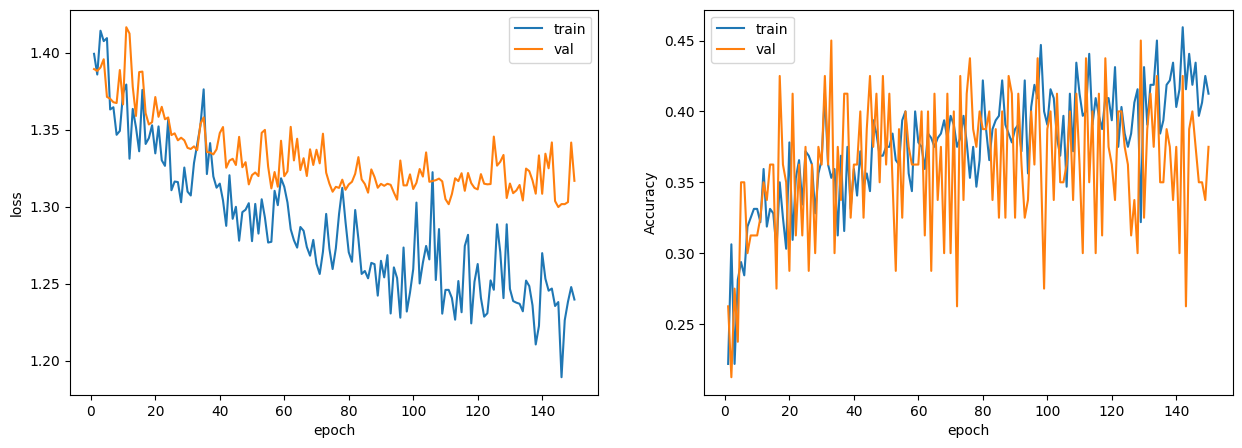

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()



Testing: 100%|██████████| 2/2 [00:00<00:00, 348.99it/s]


In [58]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")


Accuracy: 0.5


### Exponential

In [ ]:
num_epochs = 150

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)


Validating epoch 1/150: 100%|██████████| 2/2 [00:00<00:00, 240.19it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.4045114517211914, train acc: 0.25312501192092896
 val loss: 1.4019890308380127, val acc: 0.275



Validating epoch 2/150: 100%|██████████| 2/2 [00:00<00:00, 404.41it/s]


Epoch 2
 train loss: 1.397271466255188, train acc: 0.265625
 val loss: 1.3897853374481202, val acc: 0.275



Validating epoch 3/150: 100%|██████████| 2/2 [00:00<00:00, 188.85it/s]


Epoch 3
 train loss: 1.397627091407776, train acc: 0.2874999940395355
 val loss: 1.3837148666381835, val acc: 0.275



Validating epoch 4/150: 100%|██████████| 2/2 [00:00<00:00, 174.29it/s]


Epoch 4
 train loss: 1.4005369186401366, train acc: 0.27812501788139343
 val loss: 1.3795494794845582, val acc: 0.3375



Validating epoch 5/150: 100%|██████████| 2/2 [00:00<00:00, 214.64it/s]


Epoch 5
 train loss: 1.3922030925750732, train acc: 0.27812501788139343
 val loss: 1.3674890518188476, val acc: 0.325



Validating epoch 6/150: 100%|██████████| 2/2 [00:00<00:00, 85.98it/s]


Epoch 6
 train loss: 1.370310378074646, train acc: 0.296875
 val loss: 1.3660853385925293, val acc: 0.3



Validating epoch 7/150: 100%|██████████| 2/2 [00:00<00:00, 126.73it/s]


Epoch 7
 train loss: 1.3658819437026977, train acc: 0.30000001192092896
 val loss: 1.369003963470459, val acc: 0.35



Validating epoch 8/150: 100%|██████████| 2/2 [00:00<00:00, 74.77it/s]


Epoch 8
 train loss: 1.3550645351409911, train acc: 0.3031249940395355
 val loss: 1.3782907962799071, val acc: 0.325



Validating epoch 9/150: 100%|██████████| 2/2 [00:00<00:00, 343.61it/s]


Epoch 9
 train loss: 1.3762566328048706, train acc: 0.3218750059604645
 val loss: 1.3896478414535522, val acc: 0.325



Validating epoch 10/150: 100%|██████████| 2/2 [00:00<00:00, 90.16it/s]


Epoch 10
 train loss: 1.405988836288452, train acc: 0.29375001788139343
 val loss: 1.4013229608535767, val acc: 0.3375



Validating epoch 11/150: 100%|██████████| 2/2 [00:00<00:00, 81.08it/s]


Epoch 11
 train loss: 1.430567240715027, train acc: 0.3031249940395355
 val loss: 1.3850321531295777, val acc: 0.25



Validating epoch 12/150: 100%|██████████| 2/2 [00:00<00:00, 134.10it/s]


Epoch 12
 train loss: 1.3618642091751099, train acc: 0.3218750059604645
 val loss: 1.383220410346985, val acc: 0.3375



Validating epoch 13/150: 100%|██████████| 2/2 [00:00<00:00, 70.51it/s]


Epoch 13
 train loss: 1.3222862958908081, train acc: 0.35625001788139343
 val loss: 1.403661274909973, val acc: 0.3



Validating epoch 14/150: 100%|██████████| 2/2 [00:00<00:00, 397.13it/s]


Epoch 14
 train loss: 1.3897756814956665, train acc: 0.32500001788139343
 val loss: 1.3801609516143798, val acc: 0.325



Validating epoch 15/150: 100%|██████████| 2/2 [00:00<00:00, 96.13it/s]


Epoch 15
 train loss: 1.3272979497909545, train acc: 0.3531250059604645
 val loss: 1.3787512063980103, val acc: 0.3125



Validating epoch 16/150: 100%|██████████| 2/2 [00:00<00:00, 63.83it/s]


Epoch 16
 train loss: 1.3617204904556275, train acc: 0.3187499940395355
 val loss: 1.3643404245376587, val acc: 0.3625



Validating epoch 17/150: 100%|██████████| 2/2 [00:00<00:00, 110.43it/s]


Epoch 17
 train loss: 1.346283531188965, train acc: 0.34062501788139343
 val loss: 1.3574522256851196, val acc: 0.3125



Validating epoch 18/150: 100%|██████████| 2/2 [00:00<00:00, 159.58it/s]


Epoch 18
 train loss: 1.3344025611877441, train acc: 0.328125
 val loss: 1.3580173015594483, val acc: 0.325



Validating epoch 19/150: 100%|██████████| 2/2 [00:00<00:00, 67.83it/s]


Epoch 19
 train loss: 1.3339901924133302, train acc: 0.34687501192092896
 val loss: 1.3605585813522338, val acc: 0.325



Validating epoch 20/150: 100%|██████████| 2/2 [00:00<00:00, 147.10it/s]


Epoch 20
 train loss: 1.3359800338745118, train acc: 0.33125001192092896
 val loss: 1.3542182207107545, val acc: 0.3125



Validating epoch 21/150: 100%|██████████| 2/2 [00:00<00:00, 283.41it/s]


Epoch 21
 train loss: 1.3388583660125732, train acc: 0.3343749940395355
 val loss: 1.3501776218414308, val acc: 0.3875



Validating epoch 22/150: 100%|██████████| 2/2 [00:00<00:00, 266.83it/s]


Epoch 22
 train loss: 1.3244130849838256, train acc: 0.34687501192092896
 val loss: 1.3518684148788451, val acc: 0.3375



Validating epoch 23/150: 100%|██████████| 2/2 [00:00<00:00, 102.09it/s]


Epoch 23
 train loss: 1.32872474193573, train acc: 0.3687500059604645
 val loss: 1.3573344469070434, val acc: 0.375



Validating epoch 24/150: 100%|██████████| 2/2 [00:00<00:00, 254.79it/s]


Epoch 24
 train loss: 1.3505672931671142, train acc: 0.32500001788139343
 val loss: 1.3499326944351195, val acc: 0.35



Validating epoch 25/150: 100%|██████████| 2/2 [00:00<00:00, 355.69it/s]


Epoch 25
 train loss: 1.3394447088241577, train acc: 0.34687501192092896
 val loss: 1.3598151683807373, val acc: 0.3625



Validating epoch 26/150: 100%|██████████| 2/2 [00:00<00:00, 236.78it/s]


Epoch 26
 train loss: 1.3112470626831054, train acc: 0.3531250059604645
 val loss: 1.3677242279052735, val acc: 0.3375



Validating epoch 27/150: 100%|██████████| 2/2 [00:00<00:00, 192.66it/s]


Epoch 27
 train loss: 1.3305678844451905, train acc: 0.37187501788139343
 val loss: 1.3517268180847168, val acc: 0.35



Validating epoch 28/150: 100%|██████████| 2/2 [00:00<00:00, 112.06it/s]


Epoch 28
 train loss: 1.3254630088806152, train acc: 0.3656249940395355
 val loss: 1.3435497999191284, val acc: 0.375



Validating epoch 29/150: 100%|██████████| 2/2 [00:00<00:00, 245.43it/s]


Epoch 29
 train loss: 1.316611909866333, train acc: 0.3687500059604645
 val loss: 1.3497840881347656, val acc: 0.3875



Validating epoch 30/150: 100%|██████████| 2/2 [00:00<00:00, 321.27it/s]


Epoch 30
 train loss: 1.329980492591858, train acc: 0.359375
 val loss: 1.3524452447891235, val acc: 0.3



Validating epoch 31/150: 100%|██████████| 2/2 [00:00<00:00, 326.99it/s]


Epoch 31
 train loss: 1.3438591957092285, train acc: 0.3656249940395355
 val loss: 1.3425410509109497, val acc: 0.35



Validating epoch 32/150: 100%|██████████| 2/2 [00:00<00:00, 377.15it/s]


Epoch 32
 train loss: 1.3264544486999512, train acc: 0.3531250059604645
 val loss: 1.353924536705017, val acc: 0.3125



Validating epoch 33/150: 100%|██████████| 2/2 [00:00<00:00, 263.98it/s]


Epoch 33
 train loss: 1.2877962827682494, train acc: 0.3687500059604645
 val loss: 1.3540821075439453, val acc: 0.3125



Validating epoch 34/150: 100%|██████████| 2/2 [00:00<00:00, 372.31it/s]


Epoch 34
 train loss: 1.3124900579452514, train acc: 0.3687500059604645
 val loss: 1.3411702632904052, val acc: 0.3125



Validating epoch 35/150: 100%|██████████| 2/2 [00:00<00:00, 220.06it/s]


Epoch 35
 train loss: 1.2996224641799927, train acc: 0.3812499940395355
 val loss: 1.3482741355895995, val acc: 0.3375



Validating epoch 36/150: 100%|██████████| 2/2 [00:00<00:00, 280.12it/s]


Epoch 36
 train loss: 1.3013650894165039, train acc: 0.3656249940395355
 val loss: 1.336585783958435, val acc: 0.325



Validating epoch 37/150: 100%|██████████| 2/2 [00:00<00:00, 356.93it/s]


Epoch 37
 train loss: 1.290367889404297, train acc: 0.359375
 val loss: 1.3276618003845215, val acc: 0.3875



Validating epoch 38/150: 100%|██████████| 2/2 [00:00<00:00, 382.31it/s]


Epoch 38
 train loss: 1.2973751544952392, train acc: 0.3656249940395355
 val loss: 1.329513168334961, val acc: 0.375



Validating epoch 39/150: 100%|██████████| 2/2 [00:00<00:00, 361.52it/s]


Epoch 39
 train loss: 1.327327299118042, train acc: 0.3499999940395355
 val loss: 1.3263900756835938, val acc: 0.3875



Validating epoch 40/150: 100%|██████████| 2/2 [00:00<00:00, 396.44it/s]


Epoch 40
 train loss: 1.299107313156128, train acc: 0.37812501192092896
 val loss: 1.3266028881072998, val acc: 0.375



Validating epoch 41/150: 100%|██████████| 2/2 [00:00<00:00, 209.51it/s]


Epoch 41
 train loss: 1.2912606477737427, train acc: 0.3499999940395355
 val loss: 1.3245748043060304, val acc: 0.3875



Validating epoch 42/150: 100%|██████████| 2/2 [00:00<00:00, 258.83it/s]


Epoch 42
 train loss: 1.2826634168624877, train acc: 0.40625
 val loss: 1.3230052232742309, val acc: 0.4



Validating epoch 43/150: 100%|██████████| 2/2 [00:00<00:00, 202.84it/s]


Epoch 43
 train loss: 1.2838006496429444, train acc: 0.40312501788139343
 val loss: 1.3263196229934693, val acc: 0.325



Validating epoch 44/150: 100%|██████████| 2/2 [00:00<00:00, 136.94it/s]


Epoch 44
 train loss: 1.3029680490493774, train acc: 0.38750001788139343
 val loss: 1.3417219877243043, val acc: 0.4125



Validating epoch 45/150: 100%|██████████| 2/2 [00:00<00:00, 170.05it/s]


Epoch 45
 train loss: 1.3053282737731933, train acc: 0.3656249940395355
 val loss: 1.3375871658325196, val acc: 0.2875



Validating epoch 46/150: 100%|██████████| 2/2 [00:00<00:00, 405.44it/s]


Epoch 46
 train loss: 1.309583878517151, train acc: 0.3375000059604645
 val loss: 1.3247095108032227, val acc: 0.3125



Validating epoch 47/150: 100%|██████████| 2/2 [00:00<00:00, 405.82it/s]


Epoch 47
 train loss: 1.3011674404144287, train acc: 0.3656249940395355
 val loss: 1.3293041229248046, val acc: 0.3875



Validating epoch 48/150: 100%|██████████| 2/2 [00:00<00:00, 385.28it/s]


Epoch 48
 train loss: 1.2867331743240356, train acc: 0.375
 val loss: 1.3212815999984742, val acc: 0.3625



Validating epoch 49/150: 100%|██████████| 2/2 [00:00<00:00, 363.76it/s]


Epoch 49
 train loss: 1.2804839849472045, train acc: 0.375
 val loss: 1.3244320631027222, val acc: 0.375



Validating epoch 50/150: 100%|██████████| 2/2 [00:00<00:00, 412.85it/s]


Epoch 50
 train loss: 1.2865748643875121, train acc: 0.4000000059604645
 val loss: 1.3143864154815674, val acc: 0.375



Validating epoch 51/150: 100%|██████████| 2/2 [00:00<00:00, 243.48it/s]


Epoch 51
 train loss: 1.263311743736267, train acc: 0.42500001192092896
 val loss: 1.3343241453170775, val acc: 0.325



Validating epoch 52/150: 100%|██████████| 2/2 [00:00<00:00, 241.48it/s]


Epoch 52
 train loss: 1.3077654361724853, train acc: 0.3812499940395355
 val loss: 1.3386593580245971, val acc: 0.3375



Validating epoch 53/150: 100%|██████████| 2/2 [00:00<00:00, 285.45it/s]


Epoch 53
 train loss: 1.2958027839660644, train acc: 0.38750001788139343
 val loss: 1.3649553537368775, val acc: 0.3



Validating epoch 54/150: 100%|██████████| 2/2 [00:00<00:00, 306.23it/s]


Epoch 54
 train loss: 1.3176888704299927, train acc: 0.33125001192092896
 val loss: 1.3284886598587036, val acc: 0.4



Validating epoch 55/150: 100%|██████████| 2/2 [00:00<00:00, 160.22it/s]


Epoch 55
 train loss: 1.3163604021072388, train acc: 0.36250001192092896
 val loss: 1.3247766494750977, val acc: 0.375



Validating epoch 56/150: 100%|██████████| 2/2 [00:00<00:00, 367.49it/s]


Epoch 56
 train loss: 1.3021686315536498, train acc: 0.37812501192092896
 val loss: 1.3213565587997436, val acc: 0.3125



Validating epoch 57/150: 100%|██████████| 2/2 [00:00<00:00, 268.05it/s]


Epoch 57
 train loss: 1.2864912033081055, train acc: 0.3812499940395355
 val loss: 1.329839038848877, val acc: 0.375



Validating epoch 58/150: 100%|██████████| 2/2 [00:00<00:00, 321.19it/s]


Epoch 58
 train loss: 1.2955849885940551, train acc: 0.3499999940395355
 val loss: 1.3147363662719727, val acc: 0.4



Validating epoch 59/150: 100%|██████████| 2/2 [00:00<00:00, 153.59it/s]


Epoch 59
 train loss: 1.2903735876083373, train acc: 0.375
 val loss: 1.318597674369812, val acc: 0.325



Validating epoch 60/150: 100%|██████████| 2/2 [00:00<00:00, 138.74it/s]


Epoch 60
 train loss: 1.2863306999206543, train acc: 0.36250001192092896
 val loss: 1.3258420705795289, val acc: 0.3875



Validating epoch 61/150: 100%|██████████| 2/2 [00:00<00:00, 198.60it/s]


Epoch 61
 train loss: 1.2835388898849487, train acc: 0.3687500059604645
 val loss: 1.3106401205062865, val acc: 0.4



Validating epoch 62/150: 100%|██████████| 2/2 [00:00<00:00, 175.38it/s]


Epoch 62
 train loss: 1.3026076078414917, train acc: 0.3656249940395355
 val loss: 1.3115472793579102, val acc: 0.4125



Validating epoch 63/150: 100%|██████████| 2/2 [00:00<00:00, 403.45it/s]


Epoch 63
 train loss: 1.305389165878296, train acc: 0.36250001192092896
 val loss: 1.3312917470932006, val acc: 0.4



Validating epoch 64/150: 100%|██████████| 2/2 [00:00<00:00, 168.04it/s]


Epoch 64
 train loss: 1.2680109739303589, train acc: 0.3687500059604645
 val loss: 1.3195555210113525, val acc: 0.3375



Validating epoch 65/150: 100%|██████████| 2/2 [00:00<00:00, 264.03it/s]


Epoch 65
 train loss: 1.2704034090042113, train acc: 0.421875
 val loss: 1.3205681800842286, val acc: 0.3375



Validating epoch 66/150: 100%|██████████| 2/2 [00:00<00:00, 318.29it/s]


Epoch 66
 train loss: 1.3039317369461059, train acc: 0.4000000059604645
 val loss: 1.326421570777893, val acc: 0.375



Validating epoch 67/150: 100%|██████████| 2/2 [00:00<00:00, 165.02it/s]


Epoch 67
 train loss: 1.2892182111740111, train acc: 0.4000000059604645
 val loss: 1.3333420515060426, val acc: 0.325



Validating epoch 68/150: 100%|██████████| 2/2 [00:00<00:00, 406.39it/s]


Epoch 68
 train loss: 1.2871855974197388, train acc: 0.3812499940395355
 val loss: 1.336164164543152, val acc: 0.3125



Validating epoch 69/150: 100%|██████████| 2/2 [00:00<00:00, 377.39it/s]


Epoch 69
 train loss: 1.3138994216918944, train acc: 0.3531250059604645
 val loss: 1.3160133600234984, val acc: 0.4



Validating epoch 70/150: 100%|██████████| 2/2 [00:00<00:00, 411.45it/s]


Epoch 70
 train loss: 1.2691591501235961, train acc: 0.3812499940395355
 val loss: 1.324750018119812, val acc: 0.3375



Validating epoch 71/150: 100%|██████████| 2/2 [00:00<00:00, 277.38it/s]


Epoch 71
 train loss: 1.2812688589096068, train acc: 0.38750001788139343
 val loss: 1.3208675622940063, val acc: 0.425



Validating epoch 72/150: 100%|██████████| 2/2 [00:00<00:00, 361.25it/s]


Epoch 72
 train loss: 1.2651144027709962, train acc: 0.3843750059604645
 val loss: 1.3202680110931397, val acc: 0.325



Validating epoch 73/150: 100%|██████████| 2/2 [00:00<00:00, 408.70it/s]


Epoch 73
 train loss: 1.2829672813415527, train acc: 0.36250001192092896
 val loss: 1.3152074575424195, val acc: 0.3875



Validating epoch 74/150: 100%|██████████| 2/2 [00:00<00:00, 379.59it/s]


Epoch 74
 train loss: 1.2609265089035033, train acc: 0.390625
 val loss: 1.314587903022766, val acc: 0.4



Validating epoch 75/150: 100%|██████████| 2/2 [00:00<00:00, 423.67it/s]


Epoch 75
 train loss: 1.2939988136291505, train acc: 0.3812499940395355
 val loss: 1.3162890911102294, val acc: 0.4



Validating epoch 76/150: 100%|██████████| 2/2 [00:00<00:00, 413.97it/s]


Epoch 76
 train loss: 1.2885992765426635, train acc: 0.37187501788139343
 val loss: 1.309356117248535, val acc: 0.35



Validating epoch 77/150: 100%|██████████| 2/2 [00:00<00:00, 403.57it/s]


Epoch 77
 train loss: 1.2740957736968994, train acc: 0.40937501192092896
 val loss: 1.3310881853103638, val acc: 0.35



Validating epoch 78/150: 100%|██████████| 2/2 [00:00<00:00, 413.09it/s]


Epoch 78
 train loss: 1.2599448919296266, train acc: 0.40312501788139343
 val loss: 1.3190877199172975, val acc: 0.4125



Validating epoch 79/150: 100%|██████████| 2/2 [00:00<00:00, 392.95it/s]


Epoch 79
 train loss: 1.261476993560791, train acc: 0.3812499940395355
 val loss: 1.321461057662964, val acc: 0.3625



Validating epoch 80/150: 100%|██████████| 2/2 [00:00<00:00, 387.84it/s]


Epoch 80
 train loss: 1.2637990236282348, train acc: 0.3656249940395355
 val loss: 1.3262683868408203, val acc: 0.4125



Validating epoch 81/150: 100%|██████████| 2/2 [00:00<00:00, 377.51it/s]


Epoch 81
 train loss: 1.2741949558258057, train acc: 0.4124999940395355
 val loss: 1.3332315683364868, val acc: 0.325



Validating epoch 82/150: 100%|██████████| 2/2 [00:00<00:00, 415.42it/s]


Epoch 82
 train loss: 1.2559411764144897, train acc: 0.390625
 val loss: 1.3209673881530761, val acc: 0.375



Validating epoch 83/150: 100%|██████████| 2/2 [00:00<00:00, 189.97it/s]


Epoch 83
 train loss: 1.2774658679962159, train acc: 0.38750001788139343
 val loss: 1.3232049465179443, val acc: 0.3375



Validating epoch 84/150: 100%|██████████| 2/2 [00:00<00:00, 423.82it/s]


Epoch 84
 train loss: 1.2652331352233888, train acc: 0.390625
 val loss: 1.3241409301757812, val acc: 0.4375



Validating epoch 85/150: 100%|██████████| 2/2 [00:00<00:00, 300.32it/s]


Epoch 85
 train loss: 1.2703206539154053, train acc: 0.40937501192092896
 val loss: 1.3244315147399903, val acc: 0.3625



Validating epoch 86/150: 100%|██████████| 2/2 [00:00<00:00, 349.02it/s]


Epoch 86
 train loss: 1.2543339252471923, train acc: 0.39375001192092896
 val loss: 1.312612819671631, val acc: 0.275



Validating epoch 87/150: 100%|██████████| 2/2 [00:00<00:00, 442.44it/s]


Epoch 87
 train loss: 1.2534690856933595, train acc: 0.38750001788139343
 val loss: 1.3165080785751342, val acc: 0.3125



Validating epoch 88/150: 100%|██████████| 2/2 [00:00<00:00, 429.19it/s]


Epoch 88
 train loss: 1.2434505224227905, train acc: 0.37187501788139343
 val loss: 1.3101840257644652, val acc: 0.4375



Validating epoch 89/150: 100%|██████████| 2/2 [00:00<00:00, 421.81it/s]


Epoch 89
 train loss: 1.2580146789550781, train acc: 0.39375001192092896
 val loss: 1.306536817550659, val acc: 0.3875



Validating epoch 90/150: 100%|██████████| 2/2 [00:00<00:00, 411.35it/s]


Epoch 90
 train loss: 1.2365042686462402, train acc: 0.39375001192092896
 val loss: 1.2997127294540405, val acc: 0.3



Validating epoch 91/150: 100%|██████████| 2/2 [00:00<00:00, 403.90it/s]


Epoch 91
 train loss: 1.2619425535202027, train acc: 0.3812499940395355
 val loss: 1.3179876327514648, val acc: 0.3



Validating epoch 92/150: 100%|██████████| 2/2 [00:00<00:00, 401.12it/s]


Epoch 92
 train loss: 1.2308881998062133, train acc: 0.4281249940395355
 val loss: 1.3141982316970826, val acc: 0.4



Validating epoch 93/150: 100%|██████████| 2/2 [00:00<00:00, 290.45it/s]


Epoch 93
 train loss: 1.2728224515914917, train acc: 0.39375001192092896
 val loss: 1.3166271686553954, val acc: 0.3375



Validating epoch 94/150: 100%|██████████| 2/2 [00:00<00:00, 435.09it/s]


Epoch 94
 train loss: 1.2624729871749878, train acc: 0.39375001192092896
 val loss: 1.3197610139846803, val acc: 0.3875



Validating epoch 95/150: 100%|██████████| 2/2 [00:00<00:00, 421.09it/s]


Epoch 95
 train loss: 1.2917240619659425, train acc: 0.34687501192092896
 val loss: 1.3401580572128295, val acc: 0.325



Validating epoch 96/150: 100%|██████████| 2/2 [00:00<00:00, 378.77it/s]


Epoch 96
 train loss: 1.2535661935806275, train acc: 0.3968749940395355
 val loss: 1.3219282150268554, val acc: 0.425



Validating epoch 97/150: 100%|██████████| 2/2 [00:00<00:00, 378.43it/s]


Epoch 97
 train loss: 1.2307790279388429, train acc: 0.4156250059604645
 val loss: 1.3315853595733642, val acc: 0.3125



Validating epoch 98/150: 100%|██████████| 2/2 [00:00<00:00, 387.38it/s]


Epoch 98
 train loss: 1.2414314508438111, train acc: 0.4156250059604645
 val loss: 1.319100022315979, val acc: 0.375



Validating epoch 99/150: 100%|██████████| 2/2 [00:00<00:00, 403.96it/s]


Epoch 99
 train loss: 1.2651705503463746, train acc: 0.42500001192092896
 val loss: 1.336005163192749, val acc: 0.275



Validating epoch 100/150: 100%|██████████| 2/2 [00:00<00:00, 402.22it/s]


Epoch 100
 train loss: 1.2813742399215697, train acc: 0.3531250059604645
 val loss: 1.3247681617736817, val acc: 0.375



Validating epoch 101/150: 100%|██████████| 2/2 [00:00<00:00, 441.18it/s]


Epoch 101
 train loss: 1.2555486917495728, train acc: 0.38750001788139343
 val loss: 1.3117483854293823, val acc: 0.35



Validating epoch 102/150: 100%|██████████| 2/2 [00:00<00:00, 419.49it/s]


Epoch 102
 train loss: 1.2721805572509766, train acc: 0.34062501788139343
 val loss: 1.305994701385498, val acc: 0.4



Validating epoch 103/150: 100%|██████████| 2/2 [00:00<00:00, 396.77it/s]


Epoch 103
 train loss: 1.2806791305541991, train acc: 0.375
 val loss: 1.312433648109436, val acc: 0.3625



Validating epoch 104/150: 100%|██████████| 2/2 [00:00<00:00, 424.80it/s]


Epoch 104
 train loss: 1.2585524320602417, train acc: 0.40312501788139343
 val loss: 1.3138582706451416, val acc: 0.425



Validating epoch 105/150: 100%|██████████| 2/2 [00:00<00:00, 425.75it/s]


Epoch 105
 train loss: 1.2730818033218383, train acc: 0.34062501788139343
 val loss: 1.306870198249817, val acc: 0.3125



Validating epoch 106/150: 100%|██████████| 2/2 [00:00<00:00, 409.80it/s]


Epoch 106
 train loss: 1.2567038059234619, train acc: 0.40625
 val loss: 1.3131410598754882, val acc: 0.3125



Validating epoch 107/150: 100%|██████████| 2/2 [00:00<00:00, 359.98it/s]


Epoch 107
 train loss: 1.2717154502868653, train acc: 0.40312501788139343
 val loss: 1.309141492843628, val acc: 0.4125



Validating epoch 108/150: 100%|██████████| 2/2 [00:00<00:00, 277.26it/s]


Epoch 108
 train loss: 1.2555893659591675, train acc: 0.40625
 val loss: 1.3221016883850099, val acc: 0.375



Validating epoch 109/150: 100%|██████████| 2/2 [00:00<00:00, 362.14it/s]


Epoch 109
 train loss: 1.2620248556137086, train acc: 0.375
 val loss: 1.307956075668335, val acc: 0.4375



Validating epoch 110/150: 100%|██████████| 2/2 [00:00<00:00, 400.58it/s]


Epoch 110
 train loss: 1.2687581539154054, train acc: 0.41875001788139343
 val loss: 1.3163991928100587, val acc: 0.375



Validating epoch 111/150: 100%|██████████| 2/2 [00:00<00:00, 399.82it/s]


Epoch 111
 train loss: 1.2624218940734864, train acc: 0.39375001192092896
 val loss: 1.3173797845840454, val acc: 0.35



Validating epoch 112/150: 100%|██████████| 2/2 [00:00<00:00, 418.82it/s]


Epoch 112
 train loss: 1.2424497842788695, train acc: 0.39375001192092896
 val loss: 1.3106372356414795, val acc: 0.4375



Validating epoch 113/150: 100%|██████████| 2/2 [00:00<00:00, 399.23it/s]


Epoch 113
 train loss: 1.2865212917327882, train acc: 0.3812499940395355
 val loss: 1.306429386138916, val acc: 0.3875



Validating epoch 114/150: 100%|██████████| 2/2 [00:00<00:00, 425.67it/s]


Epoch 114
 train loss: 1.233496856689453, train acc: 0.421875
 val loss: 1.3145442724227905, val acc: 0.35



Validating epoch 115/150: 100%|██████████| 2/2 [00:00<00:00, 442.55it/s]


Epoch 115
 train loss: 1.2760600090026855, train acc: 0.37187501788139343
 val loss: 1.3194301128387451, val acc: 0.4



Validating epoch 116/150: 100%|██████████| 2/2 [00:00<00:00, 414.76it/s]


Epoch 116
 train loss: 1.2747650384902953, train acc: 0.37812501192092896
 val loss: 1.3312061548233032, val acc: 0.325



Validating epoch 117/150: 100%|██████████| 2/2 [00:00<00:00, 388.24it/s]


Epoch 117
 train loss: 1.272540283203125, train acc: 0.37187501788139343
 val loss: 1.3072484254837036, val acc: 0.35



Validating epoch 118/150: 100%|██████████| 2/2 [00:00<00:00, 292.18it/s]


Epoch 118
 train loss: 1.2754539251327515, train acc: 0.421875
 val loss: 1.3131813764572144, val acc: 0.3125



Validating epoch 119/150: 100%|██████████| 2/2 [00:00<00:00, 419.35it/s]


Epoch 119
 train loss: 1.2651052951812745, train acc: 0.390625
 val loss: 1.3043249368667602, val acc: 0.3875



Validating epoch 120/150: 100%|██████████| 2/2 [00:00<00:00, 453.24it/s]


Epoch 120
 train loss: 1.2492771863937377, train acc: 0.4156250059604645
 val loss: 1.3281874895095824, val acc: 0.375



Validating epoch 121/150: 100%|██████████| 2/2 [00:00<00:00, 403.53it/s]


Epoch 121
 train loss: 1.2564668893814086, train acc: 0.38750001788139343
 val loss: 1.3073389768600463, val acc: 0.4125



Validating epoch 122/150: 100%|██████████| 2/2 [00:00<00:00, 435.61it/s]


Epoch 122
 train loss: 1.255575466156006, train acc: 0.390625
 val loss: 1.3030679941177368, val acc: 0.4125



Validating epoch 123/150: 100%|██████████| 2/2 [00:00<00:00, 403.76it/s]


Epoch 123
 train loss: 1.2438483715057373, train acc: 0.421875
 val loss: 1.3248760461807252, val acc: 0.3875



Validating epoch 124/150: 100%|██████████| 2/2 [00:00<00:00, 419.14it/s]


Epoch 124
 train loss: 1.271386742591858, train acc: 0.3812499940395355
 val loss: 1.29873206615448, val acc: 0.4125



Validating epoch 125/150: 100%|██████████| 2/2 [00:00<00:00, 418.63it/s]


Epoch 125
 train loss: 1.2280378580093383, train acc: 0.4312500059604645
 val loss: 1.3203548431396483, val acc: 0.3125



Validating epoch 126/150: 100%|██████████| 2/2 [00:00<00:00, 520.68it/s]


Epoch 126
 train loss: 1.2639498472213746, train acc: 0.390625
 val loss: 1.3083993434906005, val acc: 0.3875



Validating epoch 127/150: 100%|██████████| 2/2 [00:00<00:00, 407.67it/s]


Epoch 127
 train loss: 1.258086657524109, train acc: 0.4312500059604645
 val loss: 1.3175356149673463, val acc: 0.3125



Validating epoch 128/150: 100%|██████████| 2/2 [00:00<00:00, 301.82it/s]


Epoch 128
 train loss: 1.2438261747360229, train acc: 0.38750001788139343
 val loss: 1.3205955028533936, val acc: 0.35



Validating epoch 129/150: 100%|██████████| 2/2 [00:00<00:00, 357.49it/s]


Epoch 129
 train loss: 1.255777907371521, train acc: 0.390625
 val loss: 1.3083497047424317, val acc: 0.3625



Validating epoch 130/150: 100%|██████████| 2/2 [00:00<00:00, 364.23it/s]


Epoch 130
 train loss: 1.2127557516098022, train acc: 0.44062501192092896
 val loss: 1.3203951597213746, val acc: 0.3375



Validating epoch 131/150: 100%|██████████| 2/2 [00:00<00:00, 400.54it/s]


Epoch 131
 train loss: 1.2460140705108642, train acc: 0.41875001788139343
 val loss: 1.3078423023223877, val acc: 0.375



Validating epoch 132/150: 100%|██████████| 2/2 [00:00<00:00, 415.96it/s]


Epoch 132
 train loss: 1.2492441177368163, train acc: 0.40312501788139343
 val loss: 1.3187581062316895, val acc: 0.275



Validating epoch 133/150: 100%|██████████| 2/2 [00:00<00:00, 418.36it/s]


Epoch 133
 train loss: 1.2564427137374878, train acc: 0.37812501192092896
 val loss: 1.3051947832107544, val acc: 0.4



Validating epoch 134/150: 100%|██████████| 2/2 [00:00<00:00, 422.51it/s]


Epoch 134
 train loss: 1.241276788711548, train acc: 0.40937501192092896
 val loss: 1.305861234664917, val acc: 0.3125



Validating epoch 135/150: 100%|██████████| 2/2 [00:00<00:00, 341.85it/s]


Epoch 135
 train loss: 1.253522276878357, train acc: 0.40625
 val loss: 1.3014225244522095, val acc: 0.35



Validating epoch 136/150: 100%|██████████| 2/2 [00:00<00:00, 419.51it/s]


Epoch 136
 train loss: 1.2407835006713868, train acc: 0.3968749940395355
 val loss: 1.3168583631515502, val acc: 0.375



Validating epoch 137/150: 100%|██████████| 2/2 [00:00<00:00, 408.86it/s]


Epoch 137
 train loss: 1.2553069591522217, train acc: 0.40312501788139343
 val loss: 1.3180188894271851, val acc: 0.375



Validating epoch 138/150: 100%|██████████| 2/2 [00:00<00:00, 379.92it/s]


Epoch 138
 train loss: 1.2563049793243408, train acc: 0.4000000059604645
 val loss: 1.3097572565078734, val acc: 0.3875



Validating epoch 139/150: 100%|██████████| 2/2 [00:00<00:00, 409.64it/s]


Epoch 139
 train loss: 1.2401052236557006, train acc: 0.4156250059604645
 val loss: 1.3115667343139648, val acc: 0.3625



Validating epoch 140/150: 100%|██████████| 2/2 [00:00<00:00, 413.15it/s]


Epoch 140
 train loss: 1.2366132736206055, train acc: 0.41875001788139343
 val loss: 1.3146084308624268, val acc: 0.4125



Validating epoch 141/150: 100%|██████████| 2/2 [00:00<00:00, 302.12it/s]


Epoch 141
 train loss: 1.2338058710098267, train acc: 0.4000000059604645
 val loss: 1.3141226291656494, val acc: 0.35



Validating epoch 142/150: 100%|██████████| 2/2 [00:00<00:00, 405.44it/s]


Epoch 142
 train loss: 1.22389976978302, train acc: 0.4124999940395355
 val loss: 1.3129376888275146, val acc: 0.375



Validating epoch 143/150: 100%|██████████| 2/2 [00:00<00:00, 404.37it/s]


Epoch 143
 train loss: 1.2648778438568116, train acc: 0.4375
 val loss: 1.3270426273345948, val acc: 0.3875



Validating epoch 144/150: 100%|██████████| 2/2 [00:00<00:00, 424.33it/s]


Epoch 144
 train loss: 1.2388757467269897, train acc: 0.3968749940395355
 val loss: 1.3144205331802368, val acc: 0.3125



Validating epoch 145/150: 100%|██████████| 2/2 [00:00<00:00, 404.89it/s]


Epoch 145
 train loss: 1.2139801502227783, train acc: 0.4375
 val loss: 1.31364905834198, val acc: 0.45



Validating epoch 146/150: 100%|██████████| 2/2 [00:00<00:00, 370.69it/s]


Epoch 146
 train loss: 1.2375215291976929, train acc: 0.3812499940395355
 val loss: 1.3076982498168945, val acc: 0.325



Validating epoch 147/150: 100%|██████████| 2/2 [00:00<00:00, 389.52it/s]


Epoch 147
 train loss: 1.2541761636734008, train acc: 0.4000000059604645
 val loss: 1.3096619606018067, val acc: 0.4



Validating epoch 148/150: 100%|██████████| 2/2 [00:00<00:00, 439.03it/s]


Epoch 148
 train loss: 1.2453556537628174, train acc: 0.40312501788139343
 val loss: 1.3135809898376465, val acc: 0.325



Validating epoch 149/150: 100%|██████████| 2/2 [00:00<00:00, 414.31it/s]


Epoch 149
 train loss: 1.24944748878479, train acc: 0.375
 val loss: 1.315283465385437, val acc: 0.3625



Validating epoch 150/150: 100%|██████████| 2/2 [00:00<00:00, 284.69it/s]

Epoch 150
 train loss: 1.230561661720276, train acc: 0.40937501192092896
 val loss: 1.330687928199768, val acc: 0.375



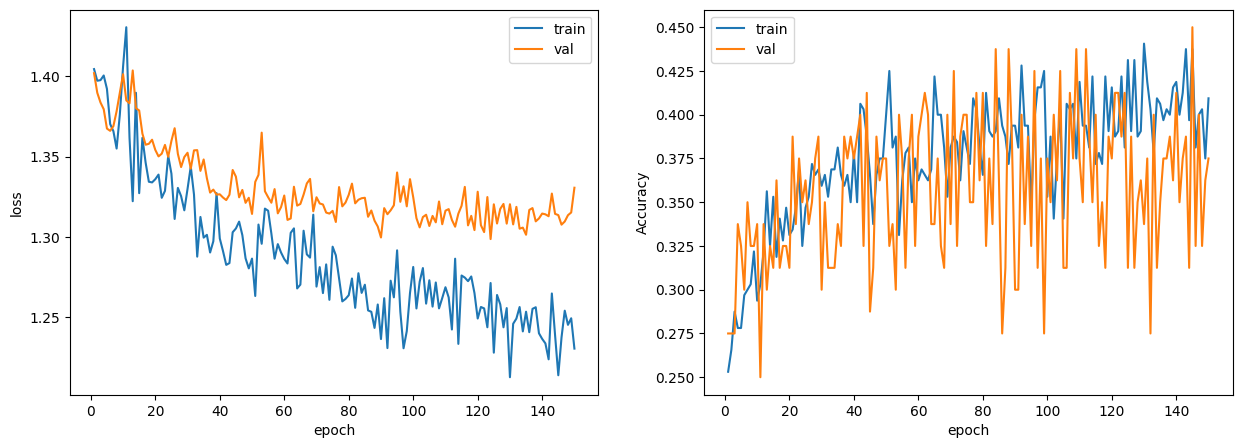

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()

Testing: 100%|██████████| 2/2 [00:00<00:00, 352.20it/s]


In [57]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")

Accuracy: 0.48


### Cyclic LR

In [ ]:
num_epochs = 150

batch_size = 64
dropout_prob = 0.5
hidden_size = 512

input_size = x_train.shape[1]
output_size = y_train.max().item() + 1

train_dataset = TensorDataset(torch.tensor(x_train_val.values, dtype=torch.float32), torch.tensor(y_train_val.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTMClassifier(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)


scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.15, max_lr=0.5,step_size_up=5,mode="triangular")



train_loss, val_loss, train_acc, val_acc = train(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)

Validating epoch 1/150: 100%|██████████| 2/2 [00:00<00:00, 462.03it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.4020928144454956, train acc: 0.22812500596046448
 val loss: 1.4041180849075316, val acc: 0.2375



Validating epoch 2/150: 100%|██████████| 2/2 [00:00<00:00, 414.05it/s]


Epoch 2
 train loss: 1.4387804746627808, train acc: 0.2750000059604645
 val loss: 1.410044002532959, val acc: 0.3



Validating epoch 3/150: 100%|██████████| 2/2 [00:00<00:00, 479.05it/s]


Epoch 3
 train loss: 1.4390305995941162, train acc: 0.30000001192092896
 val loss: 1.427294373512268, val acc: 0.25



Validating epoch 4/150: 100%|██████████| 2/2 [00:00<00:00, 418.47it/s]


Epoch 4
 train loss: 1.492901587486267, train acc: 0.3031249940395355
 val loss: 1.7213147163391114, val acc: 0.275



Validating epoch 5/150: 100%|██████████| 2/2 [00:00<00:00, 424.37it/s]


Epoch 5
 train loss: 1.5492984294891357, train acc: 0.26250001788139343
 val loss: 1.3937853813171386, val acc: 0.275



Validating epoch 6/150: 100%|██████████| 2/2 [00:00<00:00, 419.47it/s]


Epoch 6
 train loss: 1.399060606956482, train acc: 0.26875001192092896
 val loss: 1.3977212190628052, val acc: 0.275



Validating epoch 7/150: 100%|██████████| 2/2 [00:00<00:00, 409.14it/s]


Epoch 7
 train loss: 1.3720363616943358, train acc: 0.3343749940395355
 val loss: 1.3810571908950806, val acc: 0.3125



Validating epoch 8/150: 100%|██████████| 2/2 [00:00<00:00, 474.12it/s]


Epoch 8
 train loss: 1.3638834476470947, train acc: 0.3218750059604645
 val loss: 1.3739662647247315, val acc: 0.3



Validating epoch 9/150: 100%|██████████| 2/2 [00:00<00:00, 407.45it/s]


Epoch 9
 train loss: 1.3467113733291627, train acc: 0.3187499940395355
 val loss: 1.361948847770691, val acc: 0.3625



Validating epoch 10/150: 100%|██████████| 2/2 [00:00<00:00, 373.59it/s]


Epoch 10
 train loss: 1.2984349012374878, train acc: 0.3812499940395355
 val loss: 1.445604681968689, val acc: 0.275



Validating epoch 11/150: 100%|██████████| 2/2 [00:00<00:00, 450.06it/s]


Epoch 11
 train loss: 1.412632155418396, train acc: 0.30937501788139343
 val loss: 1.3838022708892823, val acc: 0.275



Validating epoch 12/150: 100%|██████████| 2/2 [00:00<00:00, 452.78it/s]


Epoch 12
 train loss: 1.3663766145706178, train acc: 0.328125
 val loss: 1.3533603429794312, val acc: 0.375



Validating epoch 13/150: 100%|██████████| 2/2 [00:00<00:00, 429.41it/s]


Epoch 13
 train loss: 1.3275276184082032, train acc: 0.32500001788139343
 val loss: 1.3599526405334472, val acc: 0.3625



Validating epoch 14/150: 100%|██████████| 2/2 [00:00<00:00, 423.65it/s]


Epoch 14
 train loss: 1.3651047945022583, train acc: 0.3499999940395355
 val loss: 1.3762313604354859, val acc: 0.275



Validating epoch 15/150: 100%|██████████| 2/2 [00:00<00:00, 385.38it/s]


Epoch 15
 train loss: 1.3403918027877808, train acc: 0.3218750059604645
 val loss: 1.3758193254470825, val acc: 0.3875



Validating epoch 16/150: 100%|██████████| 2/2 [00:00<00:00, 326.37it/s]


Epoch 16
 train loss: 1.375033187866211, train acc: 0.3031249940395355
 val loss: 1.382580327987671, val acc: 0.25



Validating epoch 17/150: 100%|██████████| 2/2 [00:00<00:00, 360.30it/s]


Epoch 17
 train loss: 1.3582433223724366, train acc: 0.34062501788139343
 val loss: 1.3653905630111693, val acc: 0.4125



Validating epoch 18/150: 100%|██████████| 2/2 [00:00<00:00, 429.33it/s]


Epoch 18
 train loss: 1.3434975147247314, train acc: 0.34062501788139343
 val loss: 1.3574974060058593, val acc: 0.2875



Validating epoch 19/150: 100%|██████████| 2/2 [00:00<00:00, 382.94it/s]


Epoch 19
 train loss: 1.3265036582946776, train acc: 0.37187501788139343
 val loss: 1.3528346776962281, val acc: 0.3375



Validating epoch 20/150: 100%|██████████| 2/2 [00:00<00:00, 397.96it/s]


Epoch 20
 train loss: 1.3202433347702027, train acc: 0.32500001788139343
 val loss: 1.3497642517089843, val acc: 0.375



Validating epoch 21/150: 100%|██████████| 2/2 [00:00<00:00, 368.50it/s]


Epoch 21
 train loss: 1.307108187675476, train acc: 0.37187501788139343
 val loss: 1.3486058235168457, val acc: 0.35



Validating epoch 22/150: 100%|██████████| 2/2 [00:00<00:00, 386.96it/s]


Epoch 22
 train loss: 1.3192429780960082, train acc: 0.36250001192092896
 val loss: 1.3509284019470216, val acc: 0.275



Validating epoch 23/150: 100%|██████████| 2/2 [00:00<00:00, 407.00it/s]


Epoch 23
 train loss: 1.3128378629684447, train acc: 0.38750001788139343
 val loss: 1.3517512798309326, val acc: 0.325



Validating epoch 24/150: 100%|██████████| 2/2 [00:00<00:00, 426.23it/s]


Epoch 24
 train loss: 1.3502351284027099, train acc: 0.34062501788139343
 val loss: 1.353294277191162, val acc: 0.3125



Validating epoch 25/150: 100%|██████████| 2/2 [00:00<00:00, 487.99it/s]


Epoch 25
 train loss: 1.2992964029312133, train acc: 0.40312501788139343
 val loss: 1.3513853549957275, val acc: 0.4



Validating epoch 26/150: 100%|██████████| 2/2 [00:00<00:00, 367.99it/s]


Epoch 26
 train loss: 1.302223515510559, train acc: 0.390625
 val loss: 1.342998743057251, val acc: 0.3125



Validating epoch 27/150: 100%|██████████| 2/2 [00:00<00:00, 460.41it/s]


Epoch 27
 train loss: 1.3047275066375732, train acc: 0.34062501788139343
 val loss: 1.3434097528457642, val acc: 0.375



Validating epoch 28/150: 100%|██████████| 2/2 [00:00<00:00, 414.07it/s]


Epoch 28
 train loss: 1.3186994791030884, train acc: 0.3687500059604645
 val loss: 1.3946422815322876, val acc: 0.2625



Validating epoch 29/150: 100%|██████████| 2/2 [00:00<00:00, 429.28it/s]


Epoch 29
 train loss: 1.3298523902893067, train acc: 0.328125
 val loss: 1.3442425012588501, val acc: 0.3875



Validating epoch 30/150: 100%|██████████| 2/2 [00:00<00:00, 379.51it/s]


Epoch 30
 train loss: 1.3074273824691773, train acc: 0.3656249940395355
 val loss: 1.3446832180023194, val acc: 0.375



Validating epoch 31/150: 100%|██████████| 2/2 [00:00<00:00, 409.30it/s]


Epoch 31
 train loss: 1.3183029651641847, train acc: 0.34687501192092896
 val loss: 1.3370773077011109, val acc: 0.35



Validating epoch 32/150: 100%|██████████| 2/2 [00:00<00:00, 498.58it/s]


Epoch 32
 train loss: 1.2840468168258667, train acc: 0.3812499940395355
 val loss: 1.3346229791641235, val acc: 0.4



Validating epoch 33/150: 100%|██████████| 2/2 [00:00<00:00, 472.65it/s]


Epoch 33
 train loss: 1.2963496685028075, train acc: 0.37812501192092896
 val loss: 1.3307059049606322, val acc: 0.3875



Validating epoch 34/150: 100%|██████████| 2/2 [00:00<00:00, 466.16it/s]


Epoch 34
 train loss: 1.30215482711792, train acc: 0.3843750059604645
 val loss: 1.3290147304534912, val acc: 0.3



Validating epoch 35/150: 100%|██████████| 2/2 [00:00<00:00, 416.29it/s]


Epoch 35
 train loss: 1.3054693460464477, train acc: 0.375
 val loss: 1.3355884790420531, val acc: 0.4



Validating epoch 36/150: 100%|██████████| 2/2 [00:00<00:00, 321.35it/s]


Epoch 36
 train loss: 1.3051199197769165, train acc: 0.35625001788139343
 val loss: 1.3408469438552857, val acc: 0.3375



Validating epoch 37/150: 100%|██████████| 2/2 [00:00<00:00, 404.00it/s]


Epoch 37
 train loss: 1.290318775177002, train acc: 0.359375
 val loss: 1.3320631027221679, val acc: 0.375



Validating epoch 38/150: 100%|██████████| 2/2 [00:00<00:00, 422.49it/s]


Epoch 38
 train loss: 1.3054070711135863, train acc: 0.375
 val loss: 1.3399730920791626, val acc: 0.3625



Validating epoch 39/150: 100%|██████████| 2/2 [00:00<00:00, 434.96it/s]


Epoch 39
 train loss: 1.3122223615646362, train acc: 0.3812499940395355
 val loss: 1.358595323562622, val acc: 0.3625



Validating epoch 40/150: 100%|██████████| 2/2 [00:00<00:00, 394.65it/s]


Epoch 40
 train loss: 1.3238028526306151, train acc: 0.3531250059604645
 val loss: 1.3447721004486084, val acc: 0.3125



Validating epoch 41/150: 100%|██████████| 2/2 [00:00<00:00, 378.96it/s]


Epoch 41
 train loss: 1.30277841091156, train acc: 0.39375001192092896
 val loss: 1.3312565326690673, val acc: 0.3375



Validating epoch 42/150: 100%|██████████| 2/2 [00:00<00:00, 391.08it/s]


Epoch 42
 train loss: 1.3175289630889893, train acc: 0.328125
 val loss: 1.3283764600753785, val acc: 0.425



Validating epoch 43/150: 100%|██████████| 2/2 [00:00<00:00, 416.89it/s]


Epoch 43
 train loss: 1.3022526502609253, train acc: 0.34375
 val loss: 1.3401715517044068, val acc: 0.35



Validating epoch 44/150: 100%|██████████| 2/2 [00:00<00:00, 515.90it/s]


Epoch 44
 train loss: 1.2958315849304198, train acc: 0.34687501192092896
 val loss: 1.3318193435668946, val acc: 0.425



Validating epoch 45/150: 100%|██████████| 2/2 [00:00<00:00, 371.77it/s]


Epoch 45
 train loss: 1.2742174863815308, train acc: 0.375
 val loss: 1.3351455211639405, val acc: 0.3375



Validating epoch 46/150: 100%|██████████| 2/2 [00:00<00:00, 382.33it/s]


Epoch 46
 train loss: 1.2668130159378053, train acc: 0.3812499940395355
 val loss: 1.3359396934509278, val acc: 0.3875



Validating epoch 47/150: 100%|██████████| 2/2 [00:00<00:00, 436.38it/s]


Epoch 47
 train loss: 1.2979228258132935, train acc: 0.3656249940395355
 val loss: 1.3757249593734742, val acc: 0.275



Validating epoch 48/150: 100%|██████████| 2/2 [00:00<00:00, 393.91it/s]


Epoch 48
 train loss: 1.3054118394851684, train acc: 0.39375001192092896
 val loss: 1.344381046295166, val acc: 0.425



Validating epoch 49/150: 100%|██████████| 2/2 [00:00<00:00, 414.27it/s]


Epoch 49
 train loss: 1.3117720127105712, train acc: 0.33125001192092896
 val loss: 1.338148021697998, val acc: 0.3375



Validating epoch 50/150: 100%|██████████| 2/2 [00:00<00:00, 378.43it/s]


Epoch 50
 train loss: 1.288502049446106, train acc: 0.3656249940395355
 val loss: 1.3439567327499389, val acc: 0.4125



Validating epoch 51/150: 100%|██████████| 2/2 [00:00<00:00, 335.71it/s]


Epoch 51
 train loss: 1.2968894004821778, train acc: 0.3843750059604645
 val loss: 1.3302352666854858, val acc: 0.3875



Validating epoch 52/150: 100%|██████████| 2/2 [00:00<00:00, 410.16it/s]


Epoch 52
 train loss: 1.302081322669983, train acc: 0.3656249940395355
 val loss: 1.335511565208435, val acc: 0.2875



Validating epoch 53/150: 100%|██████████| 2/2 [00:00<00:00, 437.98it/s]


Epoch 53
 train loss: 1.2687224388122558, train acc: 0.38750001788139343
 val loss: 1.326596188545227, val acc: 0.425



Validating epoch 54/150: 100%|██████████| 2/2 [00:00<00:00, 410.36it/s]


Epoch 54
 train loss: 1.2946586608886719, train acc: 0.3656249940395355
 val loss: 1.329923415184021, val acc: 0.325



Validating epoch 55/150: 100%|██████████| 2/2 [00:00<00:00, 429.06it/s]


Epoch 55
 train loss: 1.2958795309066773, train acc: 0.35625001788139343
 val loss: 1.35496666431427, val acc: 0.2875



Validating epoch 56/150: 100%|██████████| 2/2 [00:00<00:00, 419.10it/s]


Epoch 56
 train loss: 1.2940948009490967, train acc: 0.3968749940395355
 val loss: 1.3500495433807373, val acc: 0.3875



Validating epoch 57/150: 100%|██████████| 2/2 [00:00<00:00, 403.76it/s]


Epoch 57
 train loss: 1.2733162641525269, train acc: 0.35625001788139343
 val loss: 1.3448972940444945, val acc: 0.2875



Validating epoch 58/150: 100%|██████████| 2/2 [00:00<00:00, 450.49it/s]


Epoch 58
 train loss: 1.2604644536972045, train acc: 0.4000000059604645
 val loss: 1.3375460386276246, val acc: 0.425



Validating epoch 59/150: 100%|██████████| 2/2 [00:00<00:00, 449.29it/s]


Epoch 59
 train loss: 1.3148332834243774, train acc: 0.37187501788139343
 val loss: 1.3256756067276, val acc: 0.375



Validating epoch 60/150: 100%|██████████| 2/2 [00:00<00:00, 399.99it/s]


Epoch 60
 train loss: 1.268454670906067, train acc: 0.4312500059604645
 val loss: 1.3494314908981324, val acc: 0.2625



Validating epoch 61/150: 100%|██████████| 2/2 [00:00<00:00, 493.88it/s]


Epoch 61
 train loss: 1.2980670213699341, train acc: 0.328125
 val loss: 1.3296234607696533, val acc: 0.35



Validating epoch 62/150: 100%|██████████| 2/2 [00:00<00:00, 413.39it/s]


Epoch 62
 train loss: 1.2812029838562011, train acc: 0.3687500059604645
 val loss: 1.324449110031128, val acc: 0.325



Validating epoch 63/150: 100%|██████████| 2/2 [00:00<00:00, 402.83it/s]


Epoch 63
 train loss: 1.2933332681655885, train acc: 0.375
 val loss: 1.3255721092224122, val acc: 0.325



Validating epoch 64/150: 100%|██████████| 2/2 [00:00<00:00, 410.36it/s]


Epoch 64
 train loss: 1.3033069849014283, train acc: 0.34375
 val loss: 1.3213702201843263, val acc: 0.4



Validating epoch 65/150: 100%|██████████| 2/2 [00:00<00:00, 359.06it/s]


Epoch 65
 train loss: 1.2737947702407837, train acc: 0.3843750059604645
 val loss: 1.3202906131744385, val acc: 0.3875



Validating epoch 66/150: 100%|██████████| 2/2 [00:00<00:00, 412.16it/s]


Epoch 66
 train loss: 1.2583925008773804, train acc: 0.40937501192092896
 val loss: 1.3213448762893676, val acc: 0.4



Validating epoch 67/150: 100%|██████████| 2/2 [00:00<00:00, 473.42it/s]


Epoch 67
 train loss: 1.2809565782546997, train acc: 0.4281249940395355
 val loss: 1.3926424503326416, val acc: 0.2375



Validating epoch 68/150: 100%|██████████| 2/2 [00:00<00:00, 442.76it/s]


Epoch 68
 train loss: 1.3020653486251832, train acc: 0.3499999940395355
 val loss: 1.3228230714797973, val acc: 0.45



Validating epoch 69/150: 100%|██████████| 2/2 [00:00<00:00, 372.20it/s]


Epoch 69
 train loss: 1.3042999982833863, train acc: 0.34062501788139343
 val loss: 1.3278827905654906, val acc: 0.3625



Validating epoch 70/150: 100%|██████████| 2/2 [00:00<00:00, 394.48it/s]


Epoch 70
 train loss: 1.2579663753509522, train acc: 0.4156250059604645
 val loss: 1.3290985822677612, val acc: 0.3



Validating epoch 71/150: 100%|██████████| 2/2 [00:00<00:00, 423.67it/s]


Epoch 71
 train loss: 1.2808289527893066, train acc: 0.3375000059604645
 val loss: 1.3190898180007935, val acc: 0.4



Validating epoch 72/150: 100%|██████████| 2/2 [00:00<00:00, 290.23it/s]


Epoch 72
 train loss: 1.2674612045288085, train acc: 0.3843750059604645
 val loss: 1.3359446763992309, val acc: 0.3875



Validating epoch 73/150: 100%|██████████| 2/2 [00:00<00:00, 449.48it/s]


Epoch 73
 train loss: 1.262679147720337, train acc: 0.37812501192092896
 val loss: 1.3886900663375854, val acc: 0.25



Validating epoch 74/150: 100%|██████████| 2/2 [00:00<00:00, 426.88it/s]


Epoch 74
 train loss: 1.2677246570587157, train acc: 0.40312501788139343
 val loss: 1.4130304336547852, val acc: 0.375



Validating epoch 75/150: 100%|██████████| 2/2 [00:00<00:00, 383.08it/s]


Epoch 75
 train loss: 1.3225787162780762, train acc: 0.375
 val loss: 1.3711704730987548, val acc: 0.2125



Validating epoch 76/150: 100%|██████████| 2/2 [00:00<00:00, 360.21it/s]


Epoch 76
 train loss: 1.310462522506714, train acc: 0.3531250059604645
 val loss: 1.3507170677185059, val acc: 0.325



Validating epoch 77/150: 100%|██████████| 2/2 [00:00<00:00, 472.92it/s]


Epoch 77
 train loss: 1.301361584663391, train acc: 0.3531250059604645
 val loss: 1.335200262069702, val acc: 0.3625



Validating epoch 78/150: 100%|██████████| 2/2 [00:00<00:00, 287.40it/s]


Epoch 78
 train loss: 1.2770704984664918, train acc: 0.3531250059604645
 val loss: 1.332670021057129, val acc: 0.3625



Validating epoch 79/150: 100%|██████████| 2/2 [00:00<00:00, 423.35it/s]


Epoch 79
 train loss: 1.2514707565307617, train acc: 0.44062501192092896
 val loss: 1.3188490390777587, val acc: 0.3



Validating epoch 80/150: 100%|██████████| 2/2 [00:00<00:00, 337.98it/s]


Epoch 80
 train loss: 1.2666431427001954, train acc: 0.3656249940395355
 val loss: 1.315224027633667, val acc: 0.3375



Validating epoch 81/150: 100%|██████████| 2/2 [00:00<00:00, 403.24it/s]


Epoch 81
 train loss: 1.2451871871948241, train acc: 0.39375001192092896
 val loss: 1.311721134185791, val acc: 0.4



Validating epoch 82/150: 100%|██████████| 2/2 [00:00<00:00, 396.89it/s]


Epoch 82
 train loss: 1.2796812772750854, train acc: 0.35625001788139343
 val loss: 1.314440083503723, val acc: 0.35



Validating epoch 83/150: 100%|██████████| 2/2 [00:00<00:00, 387.97it/s]


Epoch 83
 train loss: 1.2771448612213134, train acc: 0.4000000059604645
 val loss: 1.3187541723251344, val acc: 0.425



Validating epoch 84/150: 100%|██████████| 2/2 [00:00<00:00, 414.95it/s]


Epoch 84
 train loss: 1.2455713748931885, train acc: 0.3843750059604645
 val loss: 1.3130107402801514, val acc: 0.3875



Validating epoch 85/150: 100%|██████████| 2/2 [00:00<00:00, 334.07it/s]


Epoch 85
 train loss: 1.244766616821289, train acc: 0.40625
 val loss: 1.3238317012786864, val acc: 0.3125



Validating epoch 86/150: 100%|██████████| 2/2 [00:00<00:00, 403.57it/s]


Epoch 86
 train loss: 1.2785794019699097, train acc: 0.3843750059604645
 val loss: 1.3187397718429565, val acc: 0.325



Validating epoch 87/150: 100%|██████████| 2/2 [00:00<00:00, 428.51it/s]


Epoch 87
 train loss: 1.2936688899993896, train acc: 0.39375001192092896
 val loss: 1.3671601295471192, val acc: 0.4



Validating epoch 88/150: 100%|██████████| 2/2 [00:00<00:00, 417.70it/s]


Epoch 88
 train loss: 1.2605412960052491, train acc: 0.4312500059604645
 val loss: 1.3494146823883058, val acc: 0.25



Validating epoch 89/150: 100%|██████████| 2/2 [00:00<00:00, 410.78it/s]


Epoch 89
 train loss: 1.2676767826080322, train acc: 0.41875001788139343
 val loss: 1.3195968627929688, val acc: 0.3875



Validating epoch 90/150: 100%|██████████| 2/2 [00:00<00:00, 425.71it/s]


Epoch 90
 train loss: 1.2377107381820678, train acc: 0.4156250059604645
 val loss: 1.3185348987579346, val acc: 0.3375



Validating epoch 91/150: 100%|██████████| 2/2 [00:00<00:00, 413.84it/s]


Epoch 91
 train loss: 1.2802109718322754, train acc: 0.37187501788139343
 val loss: 1.3102065801620484, val acc: 0.4



Validating epoch 92/150: 100%|██████████| 2/2 [00:00<00:00, 395.41it/s]


Epoch 92
 train loss: 1.2546456813812257, train acc: 0.4000000059604645
 val loss: 1.3034995794296265, val acc: 0.3625



Validating epoch 93/150: 100%|██████████| 2/2 [00:00<00:00, 412.52it/s]


Epoch 93
 train loss: 1.249291229248047, train acc: 0.40312501788139343
 val loss: 1.3180631160736085, val acc: 0.3



Validating epoch 94/150: 100%|██████████| 2/2 [00:00<00:00, 365.37it/s]


Epoch 94
 train loss: 1.2642917394638062, train acc: 0.390625
 val loss: 1.3179690837860107, val acc: 0.3375



Validating epoch 95/150: 100%|██████████| 2/2 [00:00<00:00, 489.56it/s]


Epoch 95
 train loss: 1.310498547554016, train acc: 0.34375
 val loss: 1.3710805892944335, val acc: 0.375



Validating epoch 96/150: 100%|██████████| 2/2 [00:00<00:00, 386.87it/s]


Epoch 96
 train loss: 1.2795970916748047, train acc: 0.41875001788139343
 val loss: 1.3482953786849976, val acc: 0.275



Validating epoch 97/150: 100%|██████████| 2/2 [00:00<00:00, 389.66it/s]


Epoch 97
 train loss: 1.2517005681991578, train acc: 0.37812501192092896
 val loss: 1.3230473279953003, val acc: 0.3875



Validating epoch 98/150: 100%|██████████| 2/2 [00:00<00:00, 423.52it/s]


Epoch 98
 train loss: 1.2487914562225342, train acc: 0.38750001788139343
 val loss: 1.3094200134277343, val acc: 0.4



Validating epoch 99/150: 100%|██████████| 2/2 [00:00<00:00, 342.97it/s]


Epoch 99
 train loss: 1.2524482011795044, train acc: 0.3843750059604645
 val loss: 1.3112827777862548, val acc: 0.35



Validating epoch 100/150: 100%|██████████| 2/2 [00:00<00:00, 353.06it/s]


Epoch 100
 train loss: 1.23565731048584, train acc: 0.4124999940395355
 val loss: 1.31049587726593, val acc: 0.4125



Validating epoch 101/150: 100%|██████████| 2/2 [00:00<00:00, 392.41it/s]


Epoch 101
 train loss: 1.25051908493042, train acc: 0.359375
 val loss: 1.3031132459640502, val acc: 0.3625



Validating epoch 102/150: 100%|██████████| 2/2 [00:00<00:00, 296.20it/s]


Epoch 102
 train loss: 1.2345344305038453, train acc: 0.4625000059604645
 val loss: 1.300996518135071, val acc: 0.375



Validating epoch 103/150: 100%|██████████| 2/2 [00:00<00:00, 339.76it/s]


Epoch 103
 train loss: 1.3039215326309204, train acc: 0.36250001192092896
 val loss: 1.3136600732803345, val acc: 0.425



Validating epoch 104/150: 100%|██████████| 2/2 [00:00<00:00, 400.24it/s]


Epoch 104
 train loss: 1.2591692209243774, train acc: 0.4156250059604645
 val loss: 1.3126246929168701, val acc: 0.3375



Validating epoch 105/150: 100%|██████████| 2/2 [00:00<00:00, 292.51it/s]


Epoch 105
 train loss: 1.255467915534973, train acc: 0.39375001192092896
 val loss: 1.322955560684204, val acc: 0.3875



Validating epoch 106/150: 100%|██████████| 2/2 [00:00<00:00, 318.96it/s]


Epoch 106
 train loss: 1.2547237396240234, train acc: 0.39375001192092896
 val loss: 1.3151490449905396, val acc: 0.35



Validating epoch 107/150: 100%|██████████| 2/2 [00:00<00:00, 427.66it/s]


Epoch 107
 train loss: 1.2319003820419312, train acc: 0.40937501192092896
 val loss: 1.333080792427063, val acc: 0.325



Validating epoch 108/150: 100%|██████████| 2/2 [00:00<00:00, 388.83it/s]


Epoch 108
 train loss: 1.2597366571426392, train acc: 0.390625
 val loss: 1.323136854171753, val acc: 0.325



Validating epoch 109/150: 100%|██████████| 2/2 [00:00<00:00, 418.61it/s]


Epoch 109
 train loss: 1.2376522302627564, train acc: 0.42500001192092896
 val loss: 1.310706901550293, val acc: 0.4125



Validating epoch 110/150: 100%|██████████| 2/2 [00:00<00:00, 356.19it/s]


Epoch 110
 train loss: 1.2413975715637207, train acc: 0.4000000059604645
 val loss: 1.3099103927612306, val acc: 0.35



Validating epoch 111/150: 100%|██████████| 2/2 [00:00<00:00, 435.14it/s]


Epoch 111
 train loss: 1.2302483797073365, train acc: 0.421875
 val loss: 1.3297959566116333, val acc: 0.3125



Validating epoch 112/150: 100%|██████████| 2/2 [00:00<00:00, 402.43it/s]


Epoch 112
 train loss: 1.251257872581482, train acc: 0.40937501192092896
 val loss: 1.3156382083892821, val acc: 0.375



Validating epoch 113/150: 100%|██████████| 2/2 [00:00<00:00, 401.27it/s]


Epoch 113
 train loss: 1.229626441001892, train acc: 0.41875001788139343
 val loss: 1.3042284965515136, val acc: 0.325



Validating epoch 114/150: 100%|██████████| 2/2 [00:00<00:00, 405.21it/s]


Epoch 114
 train loss: 1.2480308055877685, train acc: 0.39375001192092896
 val loss: 1.2979753971099854, val acc: 0.4125



Validating epoch 115/150: 100%|██████████| 2/2 [00:00<00:00, 417.28it/s]


Epoch 115
 train loss: 1.2457199096679688, train acc: 0.3843750059604645
 val loss: 1.3142862558364867, val acc: 0.4



Validating epoch 116/150: 100%|██████████| 2/2 [00:00<00:00, 419.12it/s]


Epoch 116
 train loss: 1.2266168117523193, train acc: 0.44062501192092896
 val loss: 1.3292962551116942, val acc: 0.35



Validating epoch 117/150: 100%|██████████| 2/2 [00:00<00:00, 424.14it/s]


Epoch 117
 train loss: 1.2394742250442505, train acc: 0.4124999940395355
 val loss: 1.3169512271881103, val acc: 0.375



Validating epoch 118/150: 100%|██████████| 2/2 [00:00<00:00, 286.27it/s]


Epoch 118
 train loss: 1.2655603408813476, train acc: 0.390625
 val loss: 1.3148993253707886, val acc: 0.4125



Validating epoch 119/150: 100%|██████████| 2/2 [00:00<00:00, 421.88it/s]


Epoch 119
 train loss: 1.2512863636016847, train acc: 0.421875
 val loss: 1.353671383857727, val acc: 0.2875



Validating epoch 120/150: 100%|██████████| 2/2 [00:00<00:00, 424.40it/s]


Epoch 120
 train loss: 1.260490107536316, train acc: 0.390625
 val loss: 1.3603938817977905, val acc: 0.375



Validating epoch 121/150: 100%|██████████| 2/2 [00:00<00:00, 386.93it/s]


Epoch 121
 train loss: 1.315751838684082, train acc: 0.36250001192092896
 val loss: 1.3806279182434082, val acc: 0.3375



Validating epoch 122/150: 100%|██████████| 2/2 [00:00<00:00, 392.80it/s]


Epoch 122
 train loss: 1.270523452758789, train acc: 0.35625001788139343
 val loss: 1.3722299098968507, val acc: 0.325



Validating epoch 123/150: 100%|██████████| 2/2 [00:00<00:00, 357.94it/s]


Epoch 123
 train loss: 1.2792831182479858, train acc: 0.40312501788139343
 val loss: 1.3340980052947997, val acc: 0.375



Validating epoch 124/150: 100%|██████████| 2/2 [00:00<00:00, 439.89it/s]


Epoch 124
 train loss: 1.2459206342697144, train acc: 0.41875001788139343
 val loss: 1.3190728187561036, val acc: 0.4



Validating epoch 125/150: 100%|██████████| 2/2 [00:00<00:00, 359.95it/s]


Epoch 125
 train loss: 1.235702133178711, train acc: 0.390625
 val loss: 1.331041407585144, val acc: 0.3375



Validating epoch 126/150: 100%|██████████| 2/2 [00:00<00:00, 406.70it/s]


Epoch 126
 train loss: 1.2540725231170655, train acc: 0.40625
 val loss: 1.3179204702377318, val acc: 0.4



Validating epoch 127/150: 100%|██████████| 2/2 [00:00<00:00, 374.68it/s]


Epoch 127
 train loss: 1.2450037002563477, train acc: 0.4000000059604645
 val loss: 1.3130547761917115, val acc: 0.35



Validating epoch 128/150: 100%|██████████| 2/2 [00:00<00:00, 401.39it/s]


Epoch 128
 train loss: 1.2160247564315796, train acc: 0.4375
 val loss: 1.3159093618392945, val acc: 0.3875



Validating epoch 129/150: 100%|██████████| 2/2 [00:00<00:00, 400.14it/s]


Epoch 129
 train loss: 1.2195305347442627, train acc: 0.42500001192092896
 val loss: 1.315226101875305, val acc: 0.275



Validating epoch 130/150: 100%|██████████| 2/2 [00:00<00:00, 265.15it/s]


Epoch 130
 train loss: 1.1988739490509033, train acc: 0.453125
 val loss: 1.3064997673034668, val acc: 0.3625



Validating epoch 131/150: 100%|██████████| 2/2 [00:00<00:00, 362.45it/s]


Epoch 131
 train loss: 1.2162506818771361, train acc: 0.44062501192092896
 val loss: 1.3190797328948975, val acc: 0.375



Validating epoch 132/150: 100%|██████████| 2/2 [00:00<00:00, 443.23it/s]


Epoch 132
 train loss: 1.228186011314392, train acc: 0.4156250059604645
 val loss: 1.3126641035079956, val acc: 0.4125



Validating epoch 133/150: 100%|██████████| 2/2 [00:00<00:00, 395.60it/s]


Epoch 133
 train loss: 1.2149090051651001, train acc: 0.4375
 val loss: 1.3095356225967407, val acc: 0.3625



Validating epoch 134/150: 100%|██████████| 2/2 [00:00<00:00, 273.04it/s]


Epoch 134
 train loss: 1.2155502796173097, train acc: 0.4124999940395355
 val loss: 1.29657301902771, val acc: 0.4



Validating epoch 135/150: 100%|██████████| 2/2 [00:00<00:00, 346.72it/s]


Epoch 135
 train loss: 1.2413752794265747, train acc: 0.41875001788139343
 val loss: 1.2958523511886597, val acc: 0.4



Validating epoch 136/150: 100%|██████████| 2/2 [00:00<00:00, 364.98it/s]


Epoch 136
 train loss: 1.2316984415054322, train acc: 0.4124999940395355
 val loss: 1.3052027940750122, val acc: 0.3875



Validating epoch 137/150: 100%|██████████| 2/2 [00:00<00:00, 240.04it/s]


Epoch 137
 train loss: 1.1887231111526488, train acc: 0.4312500059604645
 val loss: 1.3003352642059327, val acc: 0.3625



Validating epoch 138/150: 100%|██████████| 2/2 [00:00<00:00, 252.81it/s]


Epoch 138
 train loss: 1.229911732673645, train acc: 0.421875
 val loss: 1.3126983880996703, val acc: 0.35



Validating epoch 139/150: 100%|██████████| 2/2 [00:00<00:00, 268.81it/s]


Epoch 139
 train loss: 1.2275520324707032, train acc: 0.40312501788139343
 val loss: 1.3266946792602539, val acc: 0.325



Validating epoch 140/150: 100%|██████████| 2/2 [00:00<00:00, 260.75it/s]


Epoch 140
 train loss: 1.2422627449035644, train acc: 0.41875001788139343
 val loss: 1.3153907775878906, val acc: 0.3875



Validating epoch 141/150: 100%|██████████| 2/2 [00:00<00:00, 194.94it/s]


Epoch 141
 train loss: 1.2380310535430907, train acc: 0.41875001788139343
 val loss: 1.3060965538024902, val acc: 0.325



Validating epoch 142/150: 100%|██████████| 2/2 [00:00<00:00, 384.01it/s]


Epoch 142
 train loss: 1.2143146753311158, train acc: 0.4281249940395355
 val loss: 1.3082862138748168, val acc: 0.3375



Validating epoch 143/150: 100%|██████████| 2/2 [00:00<00:00, 324.74it/s]


Epoch 143
 train loss: 1.1953336477279664, train acc: 0.47187501192092896
 val loss: 1.3149924278259277, val acc: 0.3



Validating epoch 144/150: 100%|██████████| 2/2 [00:00<00:00, 383.39it/s]


Epoch 144
 train loss: 1.2065842151641846, train acc: 0.4468750059604645
 val loss: 1.3052002906799316, val acc: 0.4



Validating epoch 145/150: 100%|██████████| 2/2 [00:00<00:00, 322.64it/s]


Epoch 145
 train loss: 1.2032634258270263, train acc: 0.45625001192092896
 val loss: 1.3159818172454834, val acc: 0.3375



Validating epoch 146/150: 100%|██████████| 2/2 [00:00<00:00, 247.62it/s]


Epoch 146
 train loss: 1.1960118532180786, train acc: 0.4375
 val loss: 1.3073875665664674, val acc: 0.4375



Validating epoch 147/150: 100%|██████████| 2/2 [00:00<00:00, 238.94it/s]


Epoch 147
 train loss: 1.2286043882369995, train acc: 0.44062501192092896
 val loss: 1.3035938262939453, val acc: 0.4125



Validating epoch 148/150: 100%|██████████| 2/2 [00:00<00:00, 403.84it/s]


Epoch 148
 train loss: 1.2068493127822877, train acc: 0.44062501192092896
 val loss: 1.3205625534057617, val acc: 0.3375



Validating epoch 149/150: 100%|██████████| 2/2 [00:00<00:00, 278.96it/s]


Epoch 149
 train loss: 1.247020411491394, train acc: 0.3531250059604645
 val loss: 1.3160833835601806, val acc: 0.3875



Validating epoch 150/150: 100%|██████████| 2/2 [00:00<00:00, 480.89it/s]

Epoch 150
 train loss: 1.2240595817565918, train acc: 0.4156250059604645
 val loss: 1.2993061065673828, val acc: 0.3875



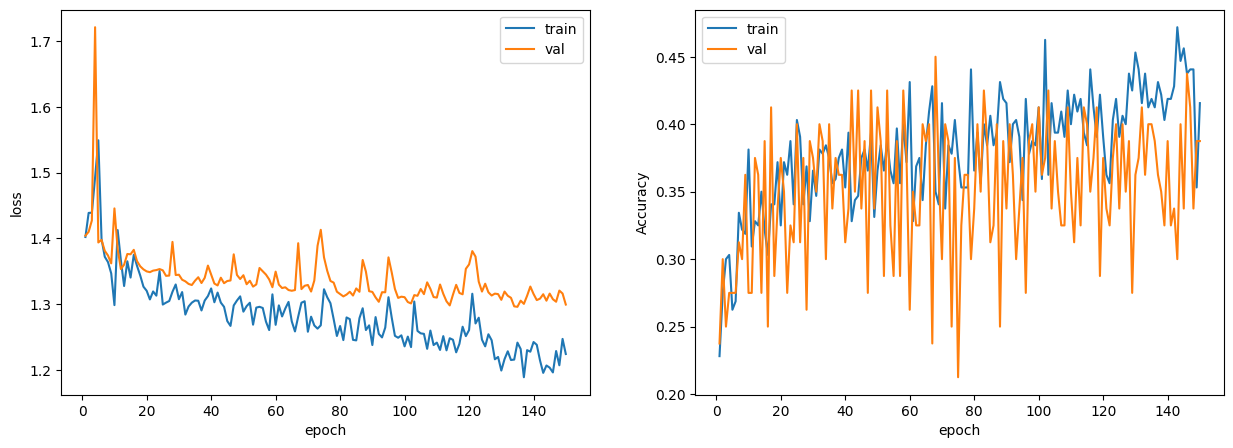

In [ ]:
train_acc_numpy = [tensor.cpu() for tensor in train_acc]
train_acc_numpy = np.array(train_acc_numpy)

plot_losses(train_loss, train_acc_numpy, val_loss, val_acc)


In [ ]:
preds = predict(model,test_loader)

conc_preds = torch.cat(preds, dim=0)
res = torch.argmax(conc_preds, dim=1)
res = res.cpu().numpy()

Testing: 100%|██████████| 2/2 [00:00<00:00, 371.37it/s]


In [56]:
acc = accuracy_score(y_test, res)
print(f"Accuracy: {acc}")

Accuracy: 0.55
